In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 2116)
(4629816, 8)
validation
(621056, 2116)
(621056, 8)
test
(624904, 2116)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2116)]            0         


 dense (Dense)               (None, 1024)              2167808   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2857864 (10.90 MB)


Trainable params: 2857864 (10.90 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:22 - loss: 2.2403 - STD: 0.0596 - MAE: 0.2200

  3/463 [..............................] - ETA: 12s - loss: 2.1258 - STD: 0.0453 - MAE: 0.2178  

  5/463 [..............................] - ETA: 13s - loss: 2.1098 - STD: 0.0499 - MAE: 0.2169

  7/463 [..............................] - ETA: 16s - loss: 2.1031 - STD: 0.0504 - MAE: 0.2167

  9/463 [..............................] - ETA: 17s - loss: 2.0941 - STD: 0.0485 - MAE: 0.2166

 11/463 [..............................] - ETA: 18s - loss: 2.0868 - STD: 0.0463 - MAE: 0.2166

 13/463 [..............................] - ETA: 18s - loss: 2.0817 - STD: 0.0440 - MAE: 0.2166

 15/463 [..............................] - ETA: 19s - loss: 2.0791 - STD: 0.0420 - MAE: 0.2167

 17/463 [>.............................] - ETA: 19s - loss: 2.0768 - STD: 0.0403 - MAE: 0.2167

 19/463 [>.............................] - ETA: 19s - loss: 2.0742 - STD: 0.0389 - MAE: 0.2168

 21/463 [>.............................] - ETA: 19s - loss: 2.0716 - STD: 0.0383 - MAE: 0.2167

 23/463 [>.............................] - ETA: 19s - loss: 2.0694 - STD: 0.0384 - MAE: 0.2167

 25/463 [>.............................] - ETA: 19s - loss: 2.0676 - STD: 0.0385 - MAE: 0.2166

 27/463 [>.............................] - ETA: 19s - loss: 2.0663 - STD: 0.0383 - MAE: 0.2166

 29/463 [>.............................] - ETA: 19s - loss: 2.0645 - STD: 0.0379 - MAE: 0.2166

 31/463 [=>............................] - ETA: 19s - loss: 2.0624 - STD: 0.0376 - MAE: 0.2165

 33/463 [=>............................] - ETA: 19s - loss: 2.0604 - STD: 0.0373 - MAE: 0.2165

 35/463 [=>............................] - ETA: 19s - loss: 2.0582 - STD: 0.0370 - MAE: 0.2165

 37/463 [=>............................] - ETA: 19s - loss: 2.0555 - STD: 0.0368 - MAE: 0.2164

 39/463 [=>............................] - ETA: 19s - loss: 2.0524 - STD: 0.0367 - MAE: 0.2163

 41/463 [=>............................] - ETA: 19s - loss: 2.0485 - STD: 0.0368 - MAE: 0.2162

 43/463 [=>............................] - ETA: 19s - loss: 2.0439 - STD: 0.0372 - MAE: 0.2160

 45/463 [=>............................] - ETA: 19s - loss: 2.0391 - STD: 0.0379 - MAE: 0.2158

 47/463 [==>...........................] - ETA: 19s - loss: 2.0341 - STD: 0.0389 - MAE: 0.2155

 49/463 [==>...........................] - ETA: 19s - loss: 2.0286 - STD: 0.0399 - MAE: 0.2153

 51/463 [==>...........................] - ETA: 19s - loss: 2.0228 - STD: 0.0410 - MAE: 0.2150

 53/463 [==>...........................] - ETA: 19s - loss: 2.0166 - STD: 0.0421 - MAE: 0.2147

 55/463 [==>...........................] - ETA: 19s - loss: 2.0100 - STD: 0.0432 - MAE: 0.2144

 57/463 [==>...........................] - ETA: 18s - loss: 2.0032 - STD: 0.0443 - MAE: 0.2141

 59/463 [==>...........................] - ETA: 18s - loss: 1.9965 - STD: 0.0455 - MAE: 0.2137

 61/463 [==>...........................] - ETA: 18s - loss: 1.9896 - STD: 0.0466 - MAE: 0.2134

 63/463 [===>..........................] - ETA: 18s - loss: 1.9824 - STD: 0.0477 - MAE: 0.2131

 65/463 [===>..........................] - ETA: 18s - loss: 1.9750 - STD: 0.0488 - MAE: 0.2127

 67/463 [===>..........................] - ETA: 18s - loss: 1.9679 - STD: 0.0499 - MAE: 0.2124

 69/463 [===>..........................] - ETA: 18s - loss: 1.9606 - STD: 0.0510 - MAE: 0.2120

 71/463 [===>..........................] - ETA: 18s - loss: 1.9536 - STD: 0.0521 - MAE: 0.2117

 73/463 [===>..........................] - ETA: 18s - loss: 1.9467 - STD: 0.0531 - MAE: 0.2114

 75/463 [===>..........................] - ETA: 18s - loss: 1.9397 - STD: 0.0542 - MAE: 0.2110

 77/463 [===>..........................] - ETA: 18s - loss: 1.9327 - STD: 0.0552 - MAE: 0.2107

 79/463 [====>.........................] - ETA: 18s - loss: 1.9261 - STD: 0.0563 - MAE: 0.2104

 81/463 [====>.........................] - ETA: 17s - loss: 1.9195 - STD: 0.0573 - MAE: 0.2100

 83/463 [====>.........................] - ETA: 17s - loss: 1.9128 - STD: 0.0583 - MAE: 0.2097

 84/463 [====>.........................] - ETA: 17s - loss: 1.9095 - STD: 0.0588 - MAE: 0.2095

 86/463 [====>.........................] - ETA: 17s - loss: 1.9030 - STD: 0.0598 - MAE: 0.2092

 88/463 [====>.........................] - ETA: 17s - loss: 1.8965 - STD: 0.0608 - MAE: 0.2088

 90/463 [====>.........................] - ETA: 17s - loss: 1.8899 - STD: 0.0618 - MAE: 0.2084

 92/463 [====>.........................] - ETA: 17s - loss: 1.8833 - STD: 0.0628 - MAE: 0.2081

 94/463 [=====>........................] - ETA: 17s - loss: 1.8767 - STD: 0.0638 - MAE: 0.2077

 96/463 [=====>........................] - ETA: 17s - loss: 1.8705 - STD: 0.0649 - MAE: 0.2073

 98/463 [=====>........................] - ETA: 17s - loss: 1.8640 - STD: 0.0659 - MAE: 0.2069

100/463 [=====>........................] - ETA: 17s - loss: 1.8575 - STD: 0.0670 - MAE: 0.2065

102/463 [=====>........................] - ETA: 17s - loss: 1.8512 - STD: 0.0681 - MAE: 0.2061

104/463 [=====>........................] - ETA: 16s - loss: 1.8447 - STD: 0.0692 - MAE: 0.2057

105/463 [=====>........................] - ETA: 16s - loss: 1.8417 - STD: 0.0697 - MAE: 0.2055

107/463 [=====>........................] - ETA: 16s - loss: 1.8354 - STD: 0.0707 - MAE: 0.2050

109/463 [======>.......................] - ETA: 16s - loss: 1.8291 - STD: 0.0718 - MAE: 0.2046

111/463 [======>.......................] - ETA: 16s - loss: 1.8226 - STD: 0.0728 - MAE: 0.2042

113/463 [======>.......................] - ETA: 16s - loss: 1.8165 - STD: 0.0738 - MAE: 0.2038

115/463 [======>.......................] - ETA: 16s - loss: 1.8102 - STD: 0.0748 - MAE: 0.2034

117/463 [======>.......................] - ETA: 16s - loss: 1.8041 - STD: 0.0758 - MAE: 0.2030

119/463 [======>.......................] - ETA: 16s - loss: 1.7980 - STD: 0.0768 - MAE: 0.2025

121/463 [======>.......................] - ETA: 16s - loss: 1.7920 - STD: 0.0778 - MAE: 0.2021

123/463 [======>.......................] - ETA: 16s - loss: 1.7861 - STD: 0.0788 - MAE: 0.2017

125/463 [=======>......................] - ETA: 16s - loss: 1.7804 - STD: 0.0798 - MAE: 0.2013

127/463 [=======>......................] - ETA: 15s - loss: 1.7746 - STD: 0.0808 - MAE: 0.2009

129/463 [=======>......................] - ETA: 15s - loss: 1.7688 - STD: 0.0817 - MAE: 0.2004

131/463 [=======>......................] - ETA: 15s - loss: 1.7631 - STD: 0.0827 - MAE: 0.2000

133/463 [=======>......................] - ETA: 15s - loss: 1.7573 - STD: 0.0836 - MAE: 0.1996

135/463 [=======>......................] - ETA: 15s - loss: 1.7516 - STD: 0.0846 - MAE: 0.1992

137/463 [=======>......................] - ETA: 15s - loss: 1.7461 - STD: 0.0855 - MAE: 0.1988

139/463 [========>.....................] - ETA: 15s - loss: 1.7407 - STD: 0.0864 - MAE: 0.1984

141/463 [========>.....................] - ETA: 15s - loss: 1.7355 - STD: 0.0873 - MAE: 0.1980

143/463 [========>.....................] - ETA: 15s - loss: 1.7304 - STD: 0.0882 - MAE: 0.1976

145/463 [========>.....................] - ETA: 15s - loss: 1.7252 - STD: 0.0891 - MAE: 0.1972

147/463 [========>.....................] - ETA: 15s - loss: 1.7200 - STD: 0.0899 - MAE: 0.1968

149/463 [========>.....................] - ETA: 14s - loss: 1.7151 - STD: 0.0907 - MAE: 0.1965

151/463 [========>.....................] - ETA: 14s - loss: 1.7103 - STD: 0.0916 - MAE: 0.1961

153/463 [========>.....................] - ETA: 14s - loss: 1.7059 - STD: 0.0924 - MAE: 0.1957

155/463 [=========>....................] - ETA: 14s - loss: 1.7014 - STD: 0.0932 - MAE: 0.1954

157/463 [=========>....................] - ETA: 14s - loss: 1.6977 - STD: 0.0940 - MAE: 0.1951

159/463 [=========>....................] - ETA: 14s - loss: 1.6933 - STD: 0.0948 - MAE: 0.1947

161/463 [=========>....................] - ETA: 14s - loss: 1.6890 - STD: 0.0955 - MAE: 0.1944

163/463 [=========>....................] - ETA: 14s - loss: 1.6847 - STD: 0.0963 - MAE: 0.1941

165/463 [=========>....................] - ETA: 14s - loss: 1.6803 - STD: 0.0970 - MAE: 0.1937

167/463 [=========>....................] - ETA: 14s - loss: 1.6759 - STD: 0.0977 - MAE: 0.1934

169/463 [=========>....................] - ETA: 13s - loss: 1.6716 - STD: 0.0984 - MAE: 0.1931

171/463 [==========>...................] - ETA: 13s - loss: 1.6674 - STD: 0.0991 - MAE: 0.1927

173/463 [==========>...................] - ETA: 13s - loss: 1.6632 - STD: 0.0998 - MAE: 0.1924

175/463 [==========>...................] - ETA: 13s - loss: 1.6589 - STD: 0.1005 - MAE: 0.1921

177/463 [==========>...................] - ETA: 13s - loss: 1.6549 - STD: 0.1011 - MAE: 0.1918

179/463 [==========>...................] - ETA: 13s - loss: 1.6509 - STD: 0.1018 - MAE: 0.1915

181/463 [==========>...................] - ETA: 13s - loss: 1.6471 - STD: 0.1025 - MAE: 0.1912

183/463 [==========>...................] - ETA: 13s - loss: 1.6432 - STD: 0.1031 - MAE: 0.1909

185/463 [==========>...................] - ETA: 13s - loss: 1.6392 - STD: 0.1037 - MAE: 0.1905

187/463 [===========>..................] - ETA: 13s - loss: 1.6353 - STD: 0.1044 - MAE: 0.1902

189/463 [===========>..................] - ETA: 13s - loss: 1.6315 - STD: 0.1050 - MAE: 0.1899

191/463 [===========>..................] - ETA: 12s - loss: 1.6279 - STD: 0.1056 - MAE: 0.1896

193/463 [===========>..................] - ETA: 12s - loss: 1.6242 - STD: 0.1062 - MAE: 0.1893

195/463 [===========>..................] - ETA: 12s - loss: 1.6205 - STD: 0.1069 - MAE: 0.1890

197/463 [===========>..................] - ETA: 12s - loss: 1.6169 - STD: 0.1075 - MAE: 0.1887

199/463 [===========>..................] - ETA: 12s - loss: 1.6132 - STD: 0.1081 - MAE: 0.1885

201/463 [============>.................] - ETA: 12s - loss: 1.6097 - STD: 0.1086 - MAE: 0.1882

203/463 [============>.................] - ETA: 12s - loss: 1.6064 - STD: 0.1092 - MAE: 0.1879

205/463 [============>.................] - ETA: 12s - loss: 1.6031 - STD: 0.1098 - MAE: 0.1876

207/463 [============>.................] - ETA: 12s - loss: 1.5997 - STD: 0.1104 - MAE: 0.1873

209/463 [============>.................] - ETA: 12s - loss: 1.5965 - STD: 0.1109 - MAE: 0.1871

211/463 [============>.................] - ETA: 11s - loss: 1.5931 - STD: 0.1115 - MAE: 0.1868

213/463 [============>.................] - ETA: 11s - loss: 1.5898 - STD: 0.1120 - MAE: 0.1865

215/463 [============>.................] - ETA: 11s - loss: 1.5865 - STD: 0.1126 - MAE: 0.1863

217/463 [=============>................] - ETA: 11s - loss: 1.5834 - STD: 0.1131 - MAE: 0.1860

219/463 [=============>................] - ETA: 11s - loss: 1.5802 - STD: 0.1137 - MAE: 0.1857

221/463 [=============>................] - ETA: 11s - loss: 1.5771 - STD: 0.1142 - MAE: 0.1855

223/463 [=============>................] - ETA: 11s - loss: 1.5740 - STD: 0.1147 - MAE: 0.1852

225/463 [=============>................] - ETA: 11s - loss: 1.5710 - STD: 0.1152 - MAE: 0.1850

227/463 [=============>................] - ETA: 11s - loss: 1.5680 - STD: 0.1157 - MAE: 0.1847

229/463 [=============>................] - ETA: 11s - loss: 1.5651 - STD: 0.1162 - MAE: 0.1845

231/463 [=============>................] - ETA: 11s - loss: 1.5623 - STD: 0.1167 - MAE: 0.1842

233/463 [==============>...............] - ETA: 10s - loss: 1.5594 - STD: 0.1172 - MAE: 0.1840

235/463 [==============>...............] - ETA: 10s - loss: 1.5566 - STD: 0.1177 - MAE: 0.1838

237/463 [==============>...............] - ETA: 10s - loss: 1.5537 - STD: 0.1182 - MAE: 0.1835

239/463 [==============>...............] - ETA: 10s - loss: 1.5510 - STD: 0.1186 - MAE: 0.1833

241/463 [==============>...............] - ETA: 10s - loss: 1.5482 - STD: 0.1191 - MAE: 0.1831

243/463 [==============>...............] - ETA: 10s - loss: 1.5454 - STD: 0.1195 - MAE: 0.1828

245/463 [==============>...............] - ETA: 10s - loss: 1.5427 - STD: 0.1200 - MAE: 0.1826

247/463 [===============>..............] - ETA: 10s - loss: 1.5400 - STD: 0.1204 - MAE: 0.1824

249/463 [===============>..............] - ETA: 10s - loss: 1.5373 - STD: 0.1209 - MAE: 0.1822

251/463 [===============>..............] - ETA: 10s - loss: 1.5347 - STD: 0.1213 - MAE: 0.1819

253/463 [===============>..............] - ETA: 10s - loss: 1.5322 - STD: 0.1218 - MAE: 0.1817

255/463 [===============>..............] - ETA: 9s - loss: 1.5298 - STD: 0.1222 - MAE: 0.1815 

257/463 [===============>..............] - ETA: 9s - loss: 1.5281 - STD: 0.1226 - MAE: 0.1813

259/463 [===============>..............] - ETA: 9s - loss: 1.5261 - STD: 0.1230 - MAE: 0.1811

261/463 [===============>..............] - ETA: 9s - loss: 1.5242 - STD: 0.1234 - MAE: 0.1810

263/463 [================>.............] - ETA: 9s - loss: 1.5218 - STD: 0.1239 - MAE: 0.1808

265/463 [================>.............] - ETA: 9s - loss: 1.5197 - STD: 0.1243 - MAE: 0.1806

267/463 [================>.............] - ETA: 9s - loss: 1.5177 - STD: 0.1246 - MAE: 0.1804

269/463 [================>.............] - ETA: 9s - loss: 1.5155 - STD: 0.1250 - MAE: 0.1802

271/463 [================>.............] - ETA: 9s - loss: 1.5132 - STD: 0.1254 - MAE: 0.1800

273/463 [================>.............] - ETA: 9s - loss: 1.5109 - STD: 0.1258 - MAE: 0.1798

275/463 [================>.............] - ETA: 8s - loss: 1.5086 - STD: 0.1262 - MAE: 0.1796

277/463 [================>.............] - ETA: 8s - loss: 1.5064 - STD: 0.1265 - MAE: 0.1794

279/463 [=================>............] - ETA: 8s - loss: 1.5041 - STD: 0.1269 - MAE: 0.1792

281/463 [=================>............] - ETA: 8s - loss: 1.5018 - STD: 0.1273 - MAE: 0.1791

283/463 [=================>............] - ETA: 8s - loss: 1.4997 - STD: 0.1276 - MAE: 0.1789

285/463 [=================>............] - ETA: 8s - loss: 1.4975 - STD: 0.1280 - MAE: 0.1787

287/463 [=================>............] - ETA: 8s - loss: 1.4954 - STD: 0.1283 - MAE: 0.1785

289/463 [=================>............] - ETA: 8s - loss: 1.4933 - STD: 0.1287 - MAE: 0.1783

291/463 [=================>............] - ETA: 8s - loss: 1.4910 - STD: 0.1290 - MAE: 0.1781

293/463 [=================>............] - ETA: 8s - loss: 1.4889 - STD: 0.1294 - MAE: 0.1780

295/463 [==================>...........] - ETA: 8s - loss: 1.4868 - STD: 0.1297 - MAE: 0.1778

297/463 [==================>...........] - ETA: 7s - loss: 1.4847 - STD: 0.1300 - MAE: 0.1776

299/463 [==================>...........] - ETA: 7s - loss: 1.4827 - STD: 0.1304 - MAE: 0.1774

301/463 [==================>...........] - ETA: 7s - loss: 1.4806 - STD: 0.1307 - MAE: 0.1772

303/463 [==================>...........] - ETA: 7s - loss: 1.4786 - STD: 0.1310 - MAE: 0.1771

305/463 [==================>...........] - ETA: 7s - loss: 1.4766 - STD: 0.1314 - MAE: 0.1769

307/463 [==================>...........] - ETA: 7s - loss: 1.4747 - STD: 0.1317 - MAE: 0.1767

309/463 [===================>..........] - ETA: 7s - loss: 1.4728 - STD: 0.1320 - MAE: 0.1766

311/463 [===================>..........] - ETA: 7s - loss: 1.4708 - STD: 0.1323 - MAE: 0.1764

313/463 [===================>..........] - ETA: 7s - loss: 1.4689 - STD: 0.1326 - MAE: 0.1762

315/463 [===================>..........] - ETA: 7s - loss: 1.4670 - STD: 0.1329 - MAE: 0.1761

317/463 [===================>..........] - ETA: 6s - loss: 1.4651 - STD: 0.1333 - MAE: 0.1759

319/463 [===================>..........] - ETA: 6s - loss: 1.4632 - STD: 0.1336 - MAE: 0.1757

321/463 [===================>..........] - ETA: 6s - loss: 1.4612 - STD: 0.1339 - MAE: 0.1756

323/463 [===================>..........] - ETA: 6s - loss: 1.4594 - STD: 0.1342 - MAE: 0.1754

325/463 [====================>.........] - ETA: 6s - loss: 1.4576 - STD: 0.1345 - MAE: 0.1753

327/463 [====================>.........] - ETA: 6s - loss: 1.4558 - STD: 0.1348 - MAE: 0.1751

329/463 [====================>.........] - ETA: 6s - loss: 1.4543 - STD: 0.1351 - MAE: 0.1750

331/463 [====================>.........] - ETA: 6s - loss: 1.4526 - STD: 0.1354 - MAE: 0.1748

333/463 [====================>.........] - ETA: 6s - loss: 1.4509 - STD: 0.1357 - MAE: 0.1747

335/463 [====================>.........] - ETA: 6s - loss: 1.4492 - STD: 0.1359 - MAE: 0.1745

337/463 [====================>.........] - ETA: 6s - loss: 1.4475 - STD: 0.1362 - MAE: 0.1744

339/463 [====================>.........] - ETA: 5s - loss: 1.4458 - STD: 0.1365 - MAE: 0.1742

341/463 [=====================>........] - ETA: 5s - loss: 1.4441 - STD: 0.1368 - MAE: 0.1741

343/463 [=====================>........] - ETA: 5s - loss: 1.4426 - STD: 0.1371 - MAE: 0.1739

345/463 [=====================>........] - ETA: 5s - loss: 1.4409 - STD: 0.1373 - MAE: 0.1738

347/463 [=====================>........] - ETA: 5s - loss: 1.4393 - STD: 0.1376 - MAE: 0.1736

349/463 [=====================>........] - ETA: 5s - loss: 1.4376 - STD: 0.1379 - MAE: 0.1735

351/463 [=====================>........] - ETA: 5s - loss: 1.4361 - STD: 0.1381 - MAE: 0.1733

353/463 [=====================>........] - ETA: 5s - loss: 1.4345 - STD: 0.1384 - MAE: 0.1732

355/463 [======================>.......] - ETA: 5s - loss: 1.4330 - STD: 0.1387 - MAE: 0.1731

357/463 [======================>.......] - ETA: 5s - loss: 1.4314 - STD: 0.1389 - MAE: 0.1729

359/463 [======================>.......] - ETA: 4s - loss: 1.4299 - STD: 0.1392 - MAE: 0.1728

361/463 [======================>.......] - ETA: 4s - loss: 1.4283 - STD: 0.1394 - MAE: 0.1727

363/463 [======================>.......] - ETA: 4s - loss: 1.4267 - STD: 0.1397 - MAE: 0.1725

365/463 [======================>.......] - ETA: 4s - loss: 1.4252 - STD: 0.1399 - MAE: 0.1724

367/463 [======================>.......] - ETA: 4s - loss: 1.4238 - STD: 0.1402 - MAE: 0.1723

369/463 [======================>.......] - ETA: 4s - loss: 1.4223 - STD: 0.1404 - MAE: 0.1721

371/463 [=======================>......] - ETA: 4s - loss: 1.4207 - STD: 0.1407 - MAE: 0.1720

373/463 [=======================>......] - ETA: 4s - loss: 1.4193 - STD: 0.1409 - MAE: 0.1719

375/463 [=======================>......] - ETA: 4s - loss: 1.4181 - STD: 0.1412 - MAE: 0.1717

377/463 [=======================>......] - ETA: 4s - loss: 1.4166 - STD: 0.1414 - MAE: 0.1716

379/463 [=======================>......] - ETA: 4s - loss: 1.4152 - STD: 0.1417 - MAE: 0.1715

381/463 [=======================>......] - ETA: 3s - loss: 1.4137 - STD: 0.1419 - MAE: 0.1714

383/463 [=======================>......] - ETA: 3s - loss: 1.4123 - STD: 0.1421 - MAE: 0.1712

385/463 [=======================>......] - ETA: 3s - loss: 1.4109 - STD: 0.1424 - MAE: 0.1711

387/463 [========================>.....] - ETA: 3s - loss: 1.4096 - STD: 0.1426 - MAE: 0.1710

389/463 [========================>.....] - ETA: 3s - loss: 1.4081 - STD: 0.1428 - MAE: 0.1709

391/463 [========================>.....] - ETA: 3s - loss: 1.4067 - STD: 0.1430 - MAE: 0.1707

393/463 [========================>.....] - ETA: 3s - loss: 1.4053 - STD: 0.1433 - MAE: 0.1706

395/463 [========================>.....] - ETA: 3s - loss: 1.4039 - STD: 0.1435 - MAE: 0.1705

397/463 [========================>.....] - ETA: 3s - loss: 1.4024 - STD: 0.1437 - MAE: 0.1704

399/463 [========================>.....] - ETA: 3s - loss: 1.4010 - STD: 0.1439 - MAE: 0.1702

401/463 [========================>.....] - ETA: 2s - loss: 1.3997 - STD: 0.1442 - MAE: 0.1701

403/463 [=========================>....] - ETA: 2s - loss: 1.3984 - STD: 0.1444 - MAE: 0.1700

405/463 [=========================>....] - ETA: 2s - loss: 1.3971 - STD: 0.1446 - MAE: 0.1699

407/463 [=========================>....] - ETA: 2s - loss: 1.3957 - STD: 0.1448 - MAE: 0.1697

409/463 [=========================>....] - ETA: 2s - loss: 1.3945 - STD: 0.1450 - MAE: 0.1696

411/463 [=========================>....] - ETA: 2s - loss: 1.3932 - STD: 0.1453 - MAE: 0.1695

413/463 [=========================>....] - ETA: 2s - loss: 1.3920 - STD: 0.1455 - MAE: 0.1694

415/463 [=========================>....] - ETA: 2s - loss: 1.3908 - STD: 0.1457 - MAE: 0.1693

417/463 [==========================>...] - ETA: 2s - loss: 1.3895 - STD: 0.1459 - MAE: 0.1692

419/463 [==========================>...] - ETA: 2s - loss: 1.3883 - STD: 0.1461 - MAE: 0.1691

420/463 [==========================>...] - ETA: 2s - loss: 1.3876 - STD: 0.1462 - MAE: 0.1690

422/463 [==========================>...] - ETA: 2s - loss: 1.3864 - STD: 0.1464 - MAE: 0.1689

424/463 [==========================>...] - ETA: 1s - loss: 1.3851 - STD: 0.1466 - MAE: 0.1688

426/463 [==========================>...] - ETA: 1s - loss: 1.3838 - STD: 0.1468 - MAE: 0.1687

428/463 [==========================>...] - ETA: 1s - loss: 1.3826 - STD: 0.1470 - MAE: 0.1685

430/463 [==========================>...] - ETA: 1s - loss: 1.3814 - STD: 0.1472 - MAE: 0.1684

432/463 [==========================>...] - ETA: 1s - loss: 1.3802 - STD: 0.1474 - MAE: 0.1683

434/463 [===========================>..] - ETA: 1s - loss: 1.3790 - STD: 0.1476 - MAE: 0.1682

436/463 [===========================>..] - ETA: 1s - loss: 1.3778 - STD: 0.1478 - MAE: 0.1681

438/463 [===========================>..] - ETA: 1s - loss: 1.3766 - STD: 0.1480 - MAE: 0.1680

440/463 [===========================>..] - ETA: 1s - loss: 1.3754 - STD: 0.1482 - MAE: 0.1679

442/463 [===========================>..] - ETA: 1s - loss: 1.3742 - STD: 0.1484 - MAE: 0.1678

444/463 [===========================>..] - ETA: 0s - loss: 1.3730 - STD: 0.1486 - MAE: 0.1677

446/463 [===========================>..] - ETA: 0s - loss: 1.3718 - STD: 0.1487 - MAE: 0.1676

448/463 [============================>.] - ETA: 0s - loss: 1.3706 - STD: 0.1489 - MAE: 0.1675

450/463 [============================>.] - ETA: 0s - loss: 1.3694 - STD: 0.1491 - MAE: 0.1674

452/463 [============================>.] - ETA: 0s - loss: 1.3682 - STD: 0.1493 - MAE: 0.1673

454/463 [============================>.] - ETA: 0s - loss: 1.3670 - STD: 0.1495 - MAE: 0.1671

456/463 [============================>.] - ETA: 0s - loss: 1.3658 - STD: 0.1497 - MAE: 0.1670

458/463 [============================>.] - ETA: 0s - loss: 1.3647 - STD: 0.1498 - MAE: 0.1669

460/463 [============================>.] - ETA: 0s - loss: 1.3634 - STD: 0.1500 - MAE: 0.1668

462/463 [============================>.] - ETA: 0s - loss: 1.3624 - STD: 0.1502 - MAE: 0.1667

463/463 [==============================] - 27s 56ms/step - loss: 1.3618 - STD: 0.1503 - MAE: 0.1667 - val_loss: 1.2595 - val_STD: 0.1869 - val_MAE: 0.1510


Epoch 2/10000


  1/463 [..............................] - ETA: 42s - loss: 1.0993 - STD: 0.1914 - MAE: 0.1434

  3/463 [..............................] - ETA: 21s - loss: 1.0964 - STD: 0.1921 - MAE: 0.1426

  5/463 [..............................] - ETA: 21s - loss: 1.0948 - STD: 0.1921 - MAE: 0.1426

  7/463 [..............................] - ETA: 21s - loss: 1.0954 - STD: 0.1920 - MAE: 0.1426

  9/463 [..............................] - ETA: 21s - loss: 1.0938 - STD: 0.1922 - MAE: 0.1424

 11/463 [..............................] - ETA: 21s - loss: 1.0930 - STD: 0.1922 - MAE: 0.1424

 13/463 [..............................] - ETA: 21s - loss: 1.0950 - STD: 0.1924 - MAE: 0.1424

 15/463 [..............................] - ETA: 21s - loss: 1.0935 - STD: 0.1924 - MAE: 0.1423

 17/463 [>.............................] - ETA: 21s - loss: 1.0927 - STD: 0.1927 - MAE: 0.1422

 19/463 [>.............................] - ETA: 21s - loss: 1.0936 - STD: 0.1928 - MAE: 0.1422

 21/463 [>.............................] - ETA: 21s - loss: 1.0931 - STD: 0.1929 - MAE: 0.1421

 23/463 [>.............................] - ETA: 20s - loss: 1.0962 - STD: 0.1930 - MAE: 0.1423

 25/463 [>.............................] - ETA: 20s - loss: 1.0960 - STD: 0.1932 - MAE: 0.1422

 27/463 [>.............................] - ETA: 20s - loss: 1.0979 - STD: 0.1932 - MAE: 0.1423

 29/463 [>.............................] - ETA: 20s - loss: 1.0967 - STD: 0.1932 - MAE: 0.1423

 31/463 [=>............................] - ETA: 20s - loss: 1.0983 - STD: 0.1932 - MAE: 0.1423

 33/463 [=>............................] - ETA: 20s - loss: 1.0977 - STD: 0.1931 - MAE: 0.1423

 35/463 [=>............................] - ETA: 20s - loss: 1.0967 - STD: 0.1930 - MAE: 0.1423

 37/463 [=>............................] - ETA: 20s - loss: 1.0966 - STD: 0.1930 - MAE: 0.1423

 39/463 [=>............................] - ETA: 20s - loss: 1.0960 - STD: 0.1931 - MAE: 0.1423

 41/463 [=>............................] - ETA: 20s - loss: 1.0953 - STD: 0.1930 - MAE: 0.1422

 43/463 [=>............................] - ETA: 20s - loss: 1.0952 - STD: 0.1930 - MAE: 0.1422

 45/463 [=>............................] - ETA: 20s - loss: 1.0947 - STD: 0.1930 - MAE: 0.1422

 46/463 [=>............................] - ETA: 20s - loss: 1.0945 - STD: 0.1930 - MAE: 0.1422

 48/463 [==>...........................] - ETA: 19s - loss: 1.0935 - STD: 0.1931 - MAE: 0.1421

 50/463 [==>...........................] - ETA: 19s - loss: 1.0936 - STD: 0.1932 - MAE: 0.1421

 52/463 [==>...........................] - ETA: 19s - loss: 1.0929 - STD: 0.1932 - MAE: 0.1420

 54/463 [==>...........................] - ETA: 19s - loss: 1.0934 - STD: 0.1932 - MAE: 0.1421

 56/463 [==>...........................] - ETA: 19s - loss: 1.0935 - STD: 0.1933 - MAE: 0.1421

 58/463 [==>...........................] - ETA: 19s - loss: 1.0930 - STD: 0.1934 - MAE: 0.1420

 59/463 [==>...........................] - ETA: 19s - loss: 1.0931 - STD: 0.1934 - MAE: 0.1420

 61/463 [==>...........................] - ETA: 19s - loss: 1.0926 - STD: 0.1934 - MAE: 0.1420

 63/463 [===>..........................] - ETA: 19s - loss: 1.0928 - STD: 0.1935 - MAE: 0.1419

 65/463 [===>..........................] - ETA: 19s - loss: 1.0931 - STD: 0.1935 - MAE: 0.1419

 67/463 [===>..........................] - ETA: 19s - loss: 1.0926 - STD: 0.1936 - MAE: 0.1419

 69/463 [===>..........................] - ETA: 18s - loss: 1.0924 - STD: 0.1936 - MAE: 0.1419

 71/463 [===>..........................] - ETA: 18s - loss: 1.0922 - STD: 0.1937 - MAE: 0.1418

 73/463 [===>..........................] - ETA: 18s - loss: 1.0919 - STD: 0.1937 - MAE: 0.1418

 75/463 [===>..........................] - ETA: 18s - loss: 1.0914 - STD: 0.1938 - MAE: 0.1417

 77/463 [===>..........................] - ETA: 18s - loss: 1.0911 - STD: 0.1939 - MAE: 0.1417

 79/463 [====>.........................] - ETA: 18s - loss: 1.0907 - STD: 0.1939 - MAE: 0.1417

 81/463 [====>.........................] - ETA: 18s - loss: 1.0905 - STD: 0.1940 - MAE: 0.1416

 83/463 [====>.........................] - ETA: 18s - loss: 1.0904 - STD: 0.1940 - MAE: 0.1416

 85/463 [====>.........................] - ETA: 18s - loss: 1.0897 - STD: 0.1941 - MAE: 0.1415

 87/463 [====>.........................] - ETA: 18s - loss: 1.0894 - STD: 0.1940 - MAE: 0.1415

 89/463 [====>.........................] - ETA: 17s - loss: 1.0891 - STD: 0.1940 - MAE: 0.1415

 91/463 [====>.........................] - ETA: 17s - loss: 1.0883 - STD: 0.1941 - MAE: 0.1414

 93/463 [=====>........................] - ETA: 17s - loss: 1.0878 - STD: 0.1941 - MAE: 0.1414

 95/463 [=====>........................] - ETA: 17s - loss: 1.0873 - STD: 0.1942 - MAE: 0.1414

 97/463 [=====>........................] - ETA: 17s - loss: 1.0868 - STD: 0.1942 - MAE: 0.1413

 99/463 [=====>........................] - ETA: 17s - loss: 1.0863 - STD: 0.1942 - MAE: 0.1413

101/463 [=====>........................] - ETA: 17s - loss: 1.0856 - STD: 0.1943 - MAE: 0.1412

103/463 [=====>........................] - ETA: 17s - loss: 1.0849 - STD: 0.1943 - MAE: 0.1411

105/463 [=====>........................] - ETA: 17s - loss: 1.0844 - STD: 0.1944 - MAE: 0.1411

107/463 [=====>........................] - ETA: 17s - loss: 1.0839 - STD: 0.1944 - MAE: 0.1411

109/463 [======>.......................] - ETA: 17s - loss: 1.0833 - STD: 0.1945 - MAE: 0.1410

111/463 [======>.......................] - ETA: 16s - loss: 1.0826 - STD: 0.1946 - MAE: 0.1409

113/463 [======>.......................] - ETA: 16s - loss: 1.0820 - STD: 0.1946 - MAE: 0.1409

115/463 [======>.......................] - ETA: 16s - loss: 1.0815 - STD: 0.1947 - MAE: 0.1408

117/463 [======>.......................] - ETA: 16s - loss: 1.0809 - STD: 0.1947 - MAE: 0.1408

119/463 [======>.......................] - ETA: 16s - loss: 1.0804 - STD: 0.1948 - MAE: 0.1407

121/463 [======>.......................] - ETA: 16s - loss: 1.0796 - STD: 0.1949 - MAE: 0.1407

123/463 [======>.......................] - ETA: 16s - loss: 1.0791 - STD: 0.1949 - MAE: 0.1406

125/463 [=======>......................] - ETA: 16s - loss: 1.0784 - STD: 0.1950 - MAE: 0.1405

127/463 [=======>......................] - ETA: 16s - loss: 1.0780 - STD: 0.1950 - MAE: 0.1405

129/463 [=======>......................] - ETA: 16s - loss: 1.0774 - STD: 0.1951 - MAE: 0.1404

131/463 [=======>......................] - ETA: 15s - loss: 1.0769 - STD: 0.1952 - MAE: 0.1404

133/463 [=======>......................] - ETA: 15s - loss: 1.0767 - STD: 0.1952 - MAE: 0.1403

135/463 [=======>......................] - ETA: 15s - loss: 1.0771 - STD: 0.1953 - MAE: 0.1403

137/463 [=======>......................] - ETA: 15s - loss: 1.0768 - STD: 0.1954 - MAE: 0.1403

139/463 [========>.....................] - ETA: 15s - loss: 1.0771 - STD: 0.1954 - MAE: 0.1403

141/463 [========>.....................] - ETA: 15s - loss: 1.0768 - STD: 0.1955 - MAE: 0.1402

143/463 [========>.....................] - ETA: 15s - loss: 1.0765 - STD: 0.1955 - MAE: 0.1402

145/463 [========>.....................] - ETA: 15s - loss: 1.0765 - STD: 0.1956 - MAE: 0.1402

147/463 [========>.....................] - ETA: 15s - loss: 1.0759 - STD: 0.1956 - MAE: 0.1401

149/463 [========>.....................] - ETA: 15s - loss: 1.0757 - STD: 0.1957 - MAE: 0.1401

151/463 [========>.....................] - ETA: 14s - loss: 1.0751 - STD: 0.1957 - MAE: 0.1400

153/463 [========>.....................] - ETA: 14s - loss: 1.0746 - STD: 0.1958 - MAE: 0.1400

155/463 [=========>....................] - ETA: 14s - loss: 1.0740 - STD: 0.1958 - MAE: 0.1400

157/463 [=========>....................] - ETA: 14s - loss: 1.0735 - STD: 0.1959 - MAE: 0.1399

159/463 [=========>....................] - ETA: 14s - loss: 1.0729 - STD: 0.1959 - MAE: 0.1399

161/463 [=========>....................] - ETA: 14s - loss: 1.0723 - STD: 0.1960 - MAE: 0.1398

163/463 [=========>....................] - ETA: 14s - loss: 1.0720 - STD: 0.1960 - MAE: 0.1398

165/463 [=========>....................] - ETA: 14s - loss: 1.0714 - STD: 0.1961 - MAE: 0.1397

167/463 [=========>....................] - ETA: 14s - loss: 1.0712 - STD: 0.1962 - MAE: 0.1397

169/463 [=========>....................] - ETA: 14s - loss: 1.0708 - STD: 0.1962 - MAE: 0.1396

171/463 [==========>...................] - ETA: 14s - loss: 1.0706 - STD: 0.1963 - MAE: 0.1396

173/463 [==========>...................] - ETA: 13s - loss: 1.0703 - STD: 0.1963 - MAE: 0.1395

175/463 [==========>...................] - ETA: 13s - loss: 1.0699 - STD: 0.1964 - MAE: 0.1395

177/463 [==========>...................] - ETA: 13s - loss: 1.0698 - STD: 0.1964 - MAE: 0.1395

179/463 [==========>...................] - ETA: 13s - loss: 1.0693 - STD: 0.1965 - MAE: 0.1394

181/463 [==========>...................] - ETA: 13s - loss: 1.0689 - STD: 0.1966 - MAE: 0.1394

183/463 [==========>...................] - ETA: 13s - loss: 1.0686 - STD: 0.1966 - MAE: 0.1393

185/463 [==========>...................] - ETA: 13s - loss: 1.0681 - STD: 0.1967 - MAE: 0.1393

187/463 [===========>..................] - ETA: 13s - loss: 1.0675 - STD: 0.1967 - MAE: 0.1392

189/463 [===========>..................] - ETA: 13s - loss: 1.0673 - STD: 0.1968 - MAE: 0.1392

191/463 [===========>..................] - ETA: 13s - loss: 1.0668 - STD: 0.1968 - MAE: 0.1392

193/463 [===========>..................] - ETA: 12s - loss: 1.0664 - STD: 0.1969 - MAE: 0.1391

195/463 [===========>..................] - ETA: 12s - loss: 1.0657 - STD: 0.1969 - MAE: 0.1390

197/463 [===========>..................] - ETA: 12s - loss: 1.0653 - STD: 0.1970 - MAE: 0.1390

199/463 [===========>..................] - ETA: 12s - loss: 1.0647 - STD: 0.1970 - MAE: 0.1389

201/463 [============>.................] - ETA: 12s - loss: 1.0641 - STD: 0.1971 - MAE: 0.1389

203/463 [============>.................] - ETA: 12s - loss: 1.0636 - STD: 0.1972 - MAE: 0.1388

205/463 [============>.................] - ETA: 12s - loss: 1.0634 - STD: 0.1972 - MAE: 0.1388

207/463 [============>.................] - ETA: 12s - loss: 1.0636 - STD: 0.1973 - MAE: 0.1388

209/463 [============>.................] - ETA: 12s - loss: 1.0637 - STD: 0.1973 - MAE: 0.1388

211/463 [============>.................] - ETA: 12s - loss: 1.0633 - STD: 0.1974 - MAE: 0.1387

213/463 [============>.................] - ETA: 12s - loss: 1.0634 - STD: 0.1974 - MAE: 0.1387

215/463 [============>.................] - ETA: 11s - loss: 1.0632 - STD: 0.1975 - MAE: 0.1387

217/463 [=============>................] - ETA: 11s - loss: 1.0630 - STD: 0.1975 - MAE: 0.1386

219/463 [=============>................] - ETA: 11s - loss: 1.0628 - STD: 0.1976 - MAE: 0.1386

221/463 [=============>................] - ETA: 11s - loss: 1.0624 - STD: 0.1976 - MAE: 0.1386

223/463 [=============>................] - ETA: 11s - loss: 1.0621 - STD: 0.1977 - MAE: 0.1385

225/463 [=============>................] - ETA: 11s - loss: 1.0619 - STD: 0.1977 - MAE: 0.1385

227/463 [=============>................] - ETA: 11s - loss: 1.0616 - STD: 0.1978 - MAE: 0.1385

229/463 [=============>................] - ETA: 11s - loss: 1.0613 - STD: 0.1978 - MAE: 0.1384

231/463 [=============>................] - ETA: 11s - loss: 1.0608 - STD: 0.1978 - MAE: 0.1384

233/463 [==============>...............] - ETA: 11s - loss: 1.0604 - STD: 0.1979 - MAE: 0.1384

235/463 [==============>...............] - ETA: 10s - loss: 1.0601 - STD: 0.1979 - MAE: 0.1383

237/463 [==============>...............] - ETA: 10s - loss: 1.0597 - STD: 0.1980 - MAE: 0.1383

239/463 [==============>...............] - ETA: 10s - loss: 1.0592 - STD: 0.1980 - MAE: 0.1382

241/463 [==============>...............] - ETA: 10s - loss: 1.0588 - STD: 0.1981 - MAE: 0.1382

243/463 [==============>...............] - ETA: 10s - loss: 1.0585 - STD: 0.1981 - MAE: 0.1381

245/463 [==============>...............] - ETA: 10s - loss: 1.0580 - STD: 0.1982 - MAE: 0.1381

247/463 [===============>..............] - ETA: 10s - loss: 1.0576 - STD: 0.1982 - MAE: 0.1381

249/463 [===============>..............] - ETA: 10s - loss: 1.0571 - STD: 0.1983 - MAE: 0.1380

251/463 [===============>..............] - ETA: 10s - loss: 1.0567 - STD: 0.1983 - MAE: 0.1380

253/463 [===============>..............] - ETA: 10s - loss: 1.0563 - STD: 0.1984 - MAE: 0.1379

255/463 [===============>..............] - ETA: 10s - loss: 1.0558 - STD: 0.1984 - MAE: 0.1379

257/463 [===============>..............] - ETA: 9s - loss: 1.0555 - STD: 0.1985 - MAE: 0.1378 

259/463 [===============>..............] - ETA: 9s - loss: 1.0551 - STD: 0.1985 - MAE: 0.1378

261/463 [===============>..............] - ETA: 9s - loss: 1.0546 - STD: 0.1986 - MAE: 0.1377

263/463 [================>.............] - ETA: 9s - loss: 1.0540 - STD: 0.1987 - MAE: 0.1377

265/463 [================>.............] - ETA: 9s - loss: 1.0535 - STD: 0.1987 - MAE: 0.1376

267/463 [================>.............] - ETA: 9s - loss: 1.0531 - STD: 0.1988 - MAE: 0.1376

269/463 [================>.............] - ETA: 9s - loss: 1.0526 - STD: 0.1988 - MAE: 0.1375

271/463 [================>.............] - ETA: 9s - loss: 1.0521 - STD: 0.1989 - MAE: 0.1375

273/463 [================>.............] - ETA: 9s - loss: 1.0518 - STD: 0.1989 - MAE: 0.1374

275/463 [================>.............] - ETA: 9s - loss: 1.0514 - STD: 0.1990 - MAE: 0.1374

277/463 [================>.............] - ETA: 8s - loss: 1.0510 - STD: 0.1990 - MAE: 0.1373

279/463 [=================>............] - ETA: 8s - loss: 1.0505 - STD: 0.1991 - MAE: 0.1373

281/463 [=================>............] - ETA: 8s - loss: 1.0501 - STD: 0.1992 - MAE: 0.1372

283/463 [=================>............] - ETA: 8s - loss: 1.0496 - STD: 0.1992 - MAE: 0.1372

285/463 [=================>............] - ETA: 8s - loss: 1.0491 - STD: 0.1993 - MAE: 0.1372

287/463 [=================>............] - ETA: 8s - loss: 1.0486 - STD: 0.1993 - MAE: 0.1371

289/463 [=================>............] - ETA: 8s - loss: 1.0482 - STD: 0.1994 - MAE: 0.1371

291/463 [=================>............] - ETA: 8s - loss: 1.0481 - STD: 0.1994 - MAE: 0.1370

293/463 [=================>............] - ETA: 8s - loss: 1.0480 - STD: 0.1995 - MAE: 0.1370

295/463 [==================>...........] - ETA: 8s - loss: 1.0477 - STD: 0.1995 - MAE: 0.1370

297/463 [==================>...........] - ETA: 7s - loss: 1.0476 - STD: 0.1996 - MAE: 0.1369

299/463 [==================>...........] - ETA: 7s - loss: 1.0472 - STD: 0.1996 - MAE: 0.1369

301/463 [==================>...........] - ETA: 7s - loss: 1.0467 - STD: 0.1997 - MAE: 0.1368

303/463 [==================>...........] - ETA: 7s - loss: 1.0465 - STD: 0.1998 - MAE: 0.1368

305/463 [==================>...........] - ETA: 7s - loss: 1.0461 - STD: 0.1998 - MAE: 0.1368

307/463 [==================>...........] - ETA: 7s - loss: 1.0457 - STD: 0.1999 - MAE: 0.1367

309/463 [===================>..........] - ETA: 7s - loss: 1.0452 - STD: 0.1999 - MAE: 0.1367

311/463 [===================>..........] - ETA: 7s - loss: 1.0447 - STD: 0.2000 - MAE: 0.1366

313/463 [===================>..........] - ETA: 7s - loss: 1.0444 - STD: 0.2000 - MAE: 0.1366

315/463 [===================>..........] - ETA: 7s - loss: 1.0440 - STD: 0.2001 - MAE: 0.1365

317/463 [===================>..........] - ETA: 7s - loss: 1.0435 - STD: 0.2001 - MAE: 0.1365

319/463 [===================>..........] - ETA: 6s - loss: 1.0431 - STD: 0.2002 - MAE: 0.1365

321/463 [===================>..........] - ETA: 6s - loss: 1.0427 - STD: 0.2002 - MAE: 0.1364

323/463 [===================>..........] - ETA: 6s - loss: 1.0424 - STD: 0.2003 - MAE: 0.1364

325/463 [====================>.........] - ETA: 6s - loss: 1.0422 - STD: 0.2003 - MAE: 0.1363

327/463 [====================>.........] - ETA: 6s - loss: 1.0418 - STD: 0.2004 - MAE: 0.1363

329/463 [====================>.........] - ETA: 6s - loss: 1.0414 - STD: 0.2004 - MAE: 0.1362

331/463 [====================>.........] - ETA: 6s - loss: 1.0412 - STD: 0.2005 - MAE: 0.1362

333/463 [====================>.........] - ETA: 6s - loss: 1.0408 - STD: 0.2005 - MAE: 0.1362

335/463 [====================>.........] - ETA: 6s - loss: 1.0404 - STD: 0.2006 - MAE: 0.1361

337/463 [====================>.........] - ETA: 6s - loss: 1.0400 - STD: 0.2006 - MAE: 0.1361

339/463 [====================>.........] - ETA: 5s - loss: 1.0397 - STD: 0.2007 - MAE: 0.1360

341/463 [=====================>........] - ETA: 5s - loss: 1.0394 - STD: 0.2007 - MAE: 0.1360

343/463 [=====================>........] - ETA: 5s - loss: 1.0391 - STD: 0.2008 - MAE: 0.1360

345/463 [=====================>........] - ETA: 5s - loss: 1.0387 - STD: 0.2008 - MAE: 0.1359

346/463 [=====================>........] - ETA: 5s - loss: 1.0385 - STD: 0.2009 - MAE: 0.1359

348/463 [=====================>........] - ETA: 5s - loss: 1.0382 - STD: 0.2009 - MAE: 0.1359

350/463 [=====================>........] - ETA: 5s - loss: 1.0378 - STD: 0.2009 - MAE: 0.1358

352/463 [=====================>........] - ETA: 5s - loss: 1.0375 - STD: 0.2010 - MAE: 0.1358

354/463 [=====================>........] - ETA: 5s - loss: 1.0372 - STD: 0.2010 - MAE: 0.1358

356/463 [======================>.......] - ETA: 5s - loss: 1.0368 - STD: 0.2011 - MAE: 0.1357

358/463 [======================>.......] - ETA: 5s - loss: 1.0368 - STD: 0.2011 - MAE: 0.1357

360/463 [======================>.......] - ETA: 4s - loss: 1.0364 - STD: 0.2012 - MAE: 0.1356

362/463 [======================>.......] - ETA: 4s - loss: 1.0362 - STD: 0.2012 - MAE: 0.1356

364/463 [======================>.......] - ETA: 4s - loss: 1.0358 - STD: 0.2013 - MAE: 0.1356

366/463 [======================>.......] - ETA: 4s - loss: 1.0355 - STD: 0.2013 - MAE: 0.1355

368/463 [======================>.......] - ETA: 4s - loss: 1.0353 - STD: 0.2014 - MAE: 0.1355

370/463 [======================>.......] - ETA: 4s - loss: 1.0351 - STD: 0.2014 - MAE: 0.1355

372/463 [=======================>......] - ETA: 4s - loss: 1.0347 - STD: 0.2015 - MAE: 0.1354

374/463 [=======================>......] - ETA: 4s - loss: 1.0343 - STD: 0.2015 - MAE: 0.1354

376/463 [=======================>......] - ETA: 4s - loss: 1.0340 - STD: 0.2015 - MAE: 0.1354

378/463 [=======================>......] - ETA: 4s - loss: 1.0336 - STD: 0.2016 - MAE: 0.1353

380/463 [=======================>......] - ETA: 3s - loss: 1.0335 - STD: 0.2016 - MAE: 0.1353

382/463 [=======================>......] - ETA: 3s - loss: 1.0332 - STD: 0.2017 - MAE: 0.1353

383/463 [=======================>......] - ETA: 3s - loss: 1.0330 - STD: 0.2017 - MAE: 0.1353

385/463 [=======================>......] - ETA: 3s - loss: 1.0327 - STD: 0.2017 - MAE: 0.1352

387/463 [========================>.....] - ETA: 3s - loss: 1.0325 - STD: 0.2018 - MAE: 0.1352

389/463 [========================>.....] - ETA: 3s - loss: 1.0321 - STD: 0.2018 - MAE: 0.1351

391/463 [========================>.....] - ETA: 3s - loss: 1.0318 - STD: 0.2019 - MAE: 0.1351

393/463 [========================>.....] - ETA: 3s - loss: 1.0315 - STD: 0.2019 - MAE: 0.1351

395/463 [========================>.....] - ETA: 3s - loss: 1.0312 - STD: 0.2020 - MAE: 0.1350

397/463 [========================>.....] - ETA: 3s - loss: 1.0308 - STD: 0.2020 - MAE: 0.1350

399/463 [========================>.....] - ETA: 3s - loss: 1.0305 - STD: 0.2021 - MAE: 0.1350

401/463 [========================>.....] - ETA: 2s - loss: 1.0301 - STD: 0.2021 - MAE: 0.1349

403/463 [=========================>....] - ETA: 2s - loss: 1.0297 - STD: 0.2021 - MAE: 0.1349

405/463 [=========================>....] - ETA: 2s - loss: 1.0293 - STD: 0.2022 - MAE: 0.1348

406/463 [=========================>....] - ETA: 2s - loss: 1.0291 - STD: 0.2022 - MAE: 0.1348

408/463 [=========================>....] - ETA: 2s - loss: 1.0287 - STD: 0.2023 - MAE: 0.1348

410/463 [=========================>....] - ETA: 2s - loss: 1.0284 - STD: 0.2023 - MAE: 0.1347

412/463 [=========================>....] - ETA: 2s - loss: 1.0281 - STD: 0.2023 - MAE: 0.1347

414/463 [=========================>....] - ETA: 2s - loss: 1.0276 - STD: 0.2024 - MAE: 0.1347

416/463 [=========================>....] - ETA: 2s - loss: 1.0272 - STD: 0.2024 - MAE: 0.1346

418/463 [==========================>...] - ETA: 2s - loss: 1.0269 - STD: 0.2025 - MAE: 0.1346

420/463 [==========================>...] - ETA: 2s - loss: 1.0265 - STD: 0.2025 - MAE: 0.1345

422/463 [==========================>...] - ETA: 1s - loss: 1.0263 - STD: 0.2026 - MAE: 0.1345

424/463 [==========================>...] - ETA: 1s - loss: 1.0259 - STD: 0.2026 - MAE: 0.1345

426/463 [==========================>...] - ETA: 1s - loss: 1.0257 - STD: 0.2027 - MAE: 0.1344

428/463 [==========================>...] - ETA: 1s - loss: 1.0253 - STD: 0.2027 - MAE: 0.1344

430/463 [==========================>...] - ETA: 1s - loss: 1.0250 - STD: 0.2028 - MAE: 0.1344

432/463 [==========================>...] - ETA: 1s - loss: 1.0246 - STD: 0.2028 - MAE: 0.1343

434/463 [===========================>..] - ETA: 1s - loss: 1.0243 - STD: 0.2028 - MAE: 0.1343

436/463 [===========================>..] - ETA: 1s - loss: 1.0239 - STD: 0.2029 - MAE: 0.1342

438/463 [===========================>..] - ETA: 1s - loss: 1.0236 - STD: 0.2029 - MAE: 0.1342

440/463 [===========================>..] - ETA: 1s - loss: 1.0232 - STD: 0.2030 - MAE: 0.1342

442/463 [===========================>..] - ETA: 1s - loss: 1.0229 - STD: 0.2030 - MAE: 0.1341

444/463 [===========================>..] - ETA: 0s - loss: 1.0227 - STD: 0.2031 - MAE: 0.1341

446/463 [===========================>..] - ETA: 0s - loss: 1.0224 - STD: 0.2031 - MAE: 0.1340

448/463 [============================>.] - ETA: 0s - loss: 1.0222 - STD: 0.2032 - MAE: 0.1340

450/463 [============================>.] - ETA: 0s - loss: 1.0220 - STD: 0.2032 - MAE: 0.1340

452/463 [============================>.] - ETA: 0s - loss: 1.0217 - STD: 0.2033 - MAE: 0.1340

454/463 [============================>.] - ETA: 0s - loss: 1.0213 - STD: 0.2033 - MAE: 0.1339

456/463 [============================>.] - ETA: 0s - loss: 1.0211 - STD: 0.2034 - MAE: 0.1339

458/463 [============================>.] - ETA: 0s - loss: 1.0208 - STD: 0.2034 - MAE: 0.1338

460/463 [============================>.] - ETA: 0s - loss: 1.0205 - STD: 0.2034 - MAE: 0.1338

462/463 [============================>.] - ETA: 0s - loss: 1.0203 - STD: 0.2035 - MAE: 0.1338

463/463 [==============================] - 25s 54ms/step - loss: 1.0203 - STD: 0.2035 - MAE: 0.1338 - val_loss: 1.3995 - val_STD: 0.2115 - val_MAE: 0.1472


Epoch 3/10000


  1/463 [..............................] - ETA: 41s - loss: 0.9576 - STD: 0.2153 - MAE: 0.1257

  3/463 [..............................] - ETA: 21s - loss: 0.9558 - STD: 0.2130 - MAE: 0.1262

  5/463 [..............................] - ETA: 21s - loss: 0.9626 - STD: 0.2134 - MAE: 0.1265

  7/463 [..............................] - ETA: 21s - loss: 0.9563 - STD: 0.2134 - MAE: 0.1261

  9/463 [..............................] - ETA: 21s - loss: 0.9532 - STD: 0.2134 - MAE: 0.1259

 11/463 [..............................] - ETA: 21s - loss: 0.9500 - STD: 0.2133 - MAE: 0.1257

 13/463 [..............................] - ETA: 21s - loss: 0.9495 - STD: 0.2133 - MAE: 0.1257

 15/463 [..............................] - ETA: 21s - loss: 0.9475 - STD: 0.2134 - MAE: 0.1255

 17/463 [>.............................] - ETA: 21s - loss: 0.9482 - STD: 0.2133 - MAE: 0.1256

 19/463 [>.............................] - ETA: 21s - loss: 0.9473 - STD: 0.2134 - MAE: 0.1255

 21/463 [>.............................] - ETA: 21s - loss: 0.9467 - STD: 0.2133 - MAE: 0.1255

 23/463 [>.............................] - ETA: 21s - loss: 0.9451 - STD: 0.2134 - MAE: 0.1254

 25/463 [>.............................] - ETA: 21s - loss: 0.9458 - STD: 0.2135 - MAE: 0.1254

 27/463 [>.............................] - ETA: 21s - loss: 0.9454 - STD: 0.2134 - MAE: 0.1254

 29/463 [>.............................] - ETA: 20s - loss: 0.9452 - STD: 0.2135 - MAE: 0.1253

 31/463 [=>............................] - ETA: 20s - loss: 0.9443 - STD: 0.2135 - MAE: 0.1253

 33/463 [=>............................] - ETA: 20s - loss: 0.9447 - STD: 0.2135 - MAE: 0.1253

 35/463 [=>............................] - ETA: 20s - loss: 0.9482 - STD: 0.2136 - MAE: 0.1255

 37/463 [=>............................] - ETA: 20s - loss: 0.9496 - STD: 0.2136 - MAE: 0.1256

 39/463 [=>............................] - ETA: 20s - loss: 0.9489 - STD: 0.2137 - MAE: 0.1255

 41/463 [=>............................] - ETA: 20s - loss: 0.9478 - STD: 0.2138 - MAE: 0.1254

 43/463 [=>............................] - ETA: 20s - loss: 0.9471 - STD: 0.2137 - MAE: 0.1253

 45/463 [=>............................] - ETA: 20s - loss: 0.9468 - STD: 0.2138 - MAE: 0.1253

 47/463 [==>...........................] - ETA: 20s - loss: 0.9471 - STD: 0.2139 - MAE: 0.1253

 49/463 [==>...........................] - ETA: 19s - loss: 0.9462 - STD: 0.2139 - MAE: 0.1252

 51/463 [==>...........................] - ETA: 19s - loss: 0.9461 - STD: 0.2139 - MAE: 0.1252

 53/463 [==>...........................] - ETA: 19s - loss: 0.9458 - STD: 0.2140 - MAE: 0.1252

 55/463 [==>...........................] - ETA: 19s - loss: 0.9450 - STD: 0.2140 - MAE: 0.1251

 57/463 [==>...........................] - ETA: 19s - loss: 0.9443 - STD: 0.2141 - MAE: 0.1250

 59/463 [==>...........................] - ETA: 19s - loss: 0.9444 - STD: 0.2141 - MAE: 0.1250

 61/463 [==>...........................] - ETA: 19s - loss: 0.9445 - STD: 0.2142 - MAE: 0.1250

 63/463 [===>..........................] - ETA: 19s - loss: 0.9449 - STD: 0.2143 - MAE: 0.1250

 65/463 [===>..........................] - ETA: 19s - loss: 0.9441 - STD: 0.2143 - MAE: 0.1249

 67/463 [===>..........................] - ETA: 19s - loss: 0.9436 - STD: 0.2143 - MAE: 0.1249

 69/463 [===>..........................] - ETA: 18s - loss: 0.9438 - STD: 0.2144 - MAE: 0.1249

 71/463 [===>..........................] - ETA: 18s - loss: 0.9439 - STD: 0.2144 - MAE: 0.1248

 73/463 [===>..........................] - ETA: 18s - loss: 0.9437 - STD: 0.2144 - MAE: 0.1248

 75/463 [===>..........................] - ETA: 18s - loss: 0.9436 - STD: 0.2145 - MAE: 0.1248

 77/463 [===>..........................] - ETA: 18s - loss: 0.9443 - STD: 0.2145 - MAE: 0.1248

 79/463 [====>.........................] - ETA: 18s - loss: 0.9440 - STD: 0.2145 - MAE: 0.1248

 81/463 [====>.........................] - ETA: 18s - loss: 0.9453 - STD: 0.2146 - MAE: 0.1249

 82/463 [====>.........................] - ETA: 18s - loss: 0.9456 - STD: 0.2146 - MAE: 0.1249

 84/463 [====>.........................] - ETA: 18s - loss: 0.9451 - STD: 0.2146 - MAE: 0.1248

 86/463 [====>.........................] - ETA: 18s - loss: 0.9448 - STD: 0.2146 - MAE: 0.1248

 88/463 [====>.........................] - ETA: 18s - loss: 0.9452 - STD: 0.2146 - MAE: 0.1248

 90/463 [====>.........................] - ETA: 18s - loss: 0.9450 - STD: 0.2146 - MAE: 0.1248

 92/463 [====>.........................] - ETA: 17s - loss: 0.9450 - STD: 0.2146 - MAE: 0.1248

 94/463 [=====>........................] - ETA: 17s - loss: 0.9452 - STD: 0.2147 - MAE: 0.1248

 96/463 [=====>........................] - ETA: 17s - loss: 0.9454 - STD: 0.2147 - MAE: 0.1248

 98/463 [=====>........................] - ETA: 17s - loss: 0.9454 - STD: 0.2147 - MAE: 0.1248

100/463 [=====>........................] - ETA: 17s - loss: 0.9459 - STD: 0.2147 - MAE: 0.1249

102/463 [=====>........................] - ETA: 17s - loss: 0.9456 - STD: 0.2147 - MAE: 0.1248

104/463 [=====>........................] - ETA: 17s - loss: 0.9455 - STD: 0.2148 - MAE: 0.1248

106/463 [=====>........................] - ETA: 17s - loss: 0.9449 - STD: 0.2147 - MAE: 0.1248

108/463 [=====>........................] - ETA: 17s - loss: 0.9446 - STD: 0.2148 - MAE: 0.1248

110/463 [======>.......................] - ETA: 17s - loss: 0.9443 - STD: 0.2148 - MAE: 0.1247

112/463 [======>.......................] - ETA: 16s - loss: 0.9441 - STD: 0.2148 - MAE: 0.1247

114/463 [======>.......................] - ETA: 16s - loss: 0.9441 - STD: 0.2149 - MAE: 0.1247

116/463 [======>.......................] - ETA: 16s - loss: 0.9446 - STD: 0.2149 - MAE: 0.1247

118/463 [======>.......................] - ETA: 16s - loss: 0.9446 - STD: 0.2149 - MAE: 0.1247

120/463 [======>.......................] - ETA: 16s - loss: 0.9458 - STD: 0.2149 - MAE: 0.1248

122/463 [======>.......................] - ETA: 16s - loss: 0.9460 - STD: 0.2150 - MAE: 0.1248

124/463 [=======>......................] - ETA: 16s - loss: 0.9466 - STD: 0.2150 - MAE: 0.1248

126/463 [=======>......................] - ETA: 16s - loss: 0.9466 - STD: 0.2150 - MAE: 0.1248

128/463 [=======>......................] - ETA: 16s - loss: 0.9467 - STD: 0.2150 - MAE: 0.1248

130/463 [=======>......................] - ETA: 16s - loss: 0.9466 - STD: 0.2150 - MAE: 0.1248

132/463 [=======>......................] - ETA: 15s - loss: 0.9463 - STD: 0.2150 - MAE: 0.1248

134/463 [=======>......................] - ETA: 15s - loss: 0.9460 - STD: 0.2150 - MAE: 0.1248

136/463 [=======>......................] - ETA: 15s - loss: 0.9456 - STD: 0.2150 - MAE: 0.1247

138/463 [=======>......................] - ETA: 15s - loss: 0.9454 - STD: 0.2150 - MAE: 0.1247

140/463 [========>.....................] - ETA: 15s - loss: 0.9454 - STD: 0.2150 - MAE: 0.1247

142/463 [========>.....................] - ETA: 15s - loss: 0.9455 - STD: 0.2150 - MAE: 0.1247

144/463 [========>.....................] - ETA: 15s - loss: 0.9452 - STD: 0.2150 - MAE: 0.1247

146/463 [========>.....................] - ETA: 15s - loss: 0.9451 - STD: 0.2151 - MAE: 0.1247

148/463 [========>.....................] - ETA: 15s - loss: 0.9447 - STD: 0.2151 - MAE: 0.1247

150/463 [========>.....................] - ETA: 15s - loss: 0.9443 - STD: 0.2151 - MAE: 0.1246

152/463 [========>.....................] - ETA: 14s - loss: 0.9441 - STD: 0.2151 - MAE: 0.1246

154/463 [========>.....................] - ETA: 14s - loss: 0.9437 - STD: 0.2151 - MAE: 0.1246

156/463 [=========>....................] - ETA: 14s - loss: 0.9433 - STD: 0.2151 - MAE: 0.1246

158/463 [=========>....................] - ETA: 14s - loss: 0.9429 - STD: 0.2151 - MAE: 0.1245

160/463 [=========>....................] - ETA: 14s - loss: 0.9428 - STD: 0.2152 - MAE: 0.1245

162/463 [=========>....................] - ETA: 14s - loss: 0.9425 - STD: 0.2152 - MAE: 0.1245

164/463 [=========>....................] - ETA: 14s - loss: 0.9423 - STD: 0.2152 - MAE: 0.1245

166/463 [=========>....................] - ETA: 14s - loss: 0.9419 - STD: 0.2152 - MAE: 0.1244

168/463 [=========>....................] - ETA: 14s - loss: 0.9415 - STD: 0.2153 - MAE: 0.1244

170/463 [==========>...................] - ETA: 14s - loss: 0.9412 - STD: 0.2153 - MAE: 0.1244

172/463 [==========>...................] - ETA: 13s - loss: 0.9410 - STD: 0.2153 - MAE: 0.1243

174/463 [==========>...................] - ETA: 13s - loss: 0.9407 - STD: 0.2154 - MAE: 0.1243

176/463 [==========>...................] - ETA: 13s - loss: 0.9406 - STD: 0.2154 - MAE: 0.1243

178/463 [==========>...................] - ETA: 13s - loss: 0.9402 - STD: 0.2155 - MAE: 0.1242

180/463 [==========>...................] - ETA: 13s - loss: 0.9400 - STD: 0.2155 - MAE: 0.1242

182/463 [==========>...................] - ETA: 13s - loss: 0.9397 - STD: 0.2155 - MAE: 0.1242

184/463 [==========>...................] - ETA: 13s - loss: 0.9394 - STD: 0.2155 - MAE: 0.1241

186/463 [===========>..................] - ETA: 13s - loss: 0.9392 - STD: 0.2156 - MAE: 0.1241

188/463 [===========>..................] - ETA: 13s - loss: 0.9387 - STD: 0.2156 - MAE: 0.1241

190/463 [===========>..................] - ETA: 13s - loss: 0.9384 - STD: 0.2156 - MAE: 0.1240

192/463 [===========>..................] - ETA: 13s - loss: 0.9380 - STD: 0.2157 - MAE: 0.1240

194/463 [===========>..................] - ETA: 12s - loss: 0.9378 - STD: 0.2157 - MAE: 0.1240

196/463 [===========>..................] - ETA: 12s - loss: 0.9376 - STD: 0.2157 - MAE: 0.1239

198/463 [===========>..................] - ETA: 12s - loss: 0.9373 - STD: 0.2158 - MAE: 0.1239

200/463 [===========>..................] - ETA: 12s - loss: 0.9369 - STD: 0.2158 - MAE: 0.1239

202/463 [============>.................] - ETA: 12s - loss: 0.9368 - STD: 0.2158 - MAE: 0.1239

204/463 [============>.................] - ETA: 12s - loss: 0.9366 - STD: 0.2159 - MAE: 0.1238

206/463 [============>.................] - ETA: 12s - loss: 0.9363 - STD: 0.2159 - MAE: 0.1238

208/463 [============>.................] - ETA: 12s - loss: 0.9362 - STD: 0.2159 - MAE: 0.1238

210/463 [============>.................] - ETA: 12s - loss: 0.9362 - STD: 0.2160 - MAE: 0.1238

212/463 [============>.................] - ETA: 12s - loss: 0.9361 - STD: 0.2160 - MAE: 0.1237

214/463 [============>.................] - ETA: 11s - loss: 0.9363 - STD: 0.2160 - MAE: 0.1238

216/463 [============>.................] - ETA: 11s - loss: 0.9363 - STD: 0.2160 - MAE: 0.1237

218/463 [=============>................] - ETA: 11s - loss: 0.9364 - STD: 0.2161 - MAE: 0.1237

220/463 [=============>................] - ETA: 11s - loss: 0.9361 - STD: 0.2161 - MAE: 0.1237

222/463 [=============>................] - ETA: 11s - loss: 0.9363 - STD: 0.2161 - MAE: 0.1237

224/463 [=============>................] - ETA: 11s - loss: 0.9361 - STD: 0.2161 - MAE: 0.1237

226/463 [=============>................] - ETA: 11s - loss: 0.9362 - STD: 0.2162 - MAE: 0.1237

228/463 [=============>................] - ETA: 11s - loss: 0.9360 - STD: 0.2162 - MAE: 0.1237

230/463 [=============>................] - ETA: 11s - loss: 0.9359 - STD: 0.2162 - MAE: 0.1236

232/463 [==============>...............] - ETA: 11s - loss: 0.9357 - STD: 0.2162 - MAE: 0.1236

234/463 [==============>...............] - ETA: 11s - loss: 0.9354 - STD: 0.2162 - MAE: 0.1236

236/463 [==============>...............] - ETA: 10s - loss: 0.9351 - STD: 0.2163 - MAE: 0.1236

238/463 [==============>...............] - ETA: 10s - loss: 0.9349 - STD: 0.2163 - MAE: 0.1236

240/463 [==============>...............] - ETA: 10s - loss: 0.9348 - STD: 0.2163 - MAE: 0.1235

242/463 [==============>...............] - ETA: 10s - loss: 0.9345 - STD: 0.2163 - MAE: 0.1235

244/463 [==============>...............] - ETA: 10s - loss: 0.9343 - STD: 0.2163 - MAE: 0.1235

246/463 [==============>...............] - ETA: 10s - loss: 0.9341 - STD: 0.2164 - MAE: 0.1235

248/463 [===============>..............] - ETA: 10s - loss: 0.9340 - STD: 0.2164 - MAE: 0.1235

250/463 [===============>..............] - ETA: 10s - loss: 0.9338 - STD: 0.2164 - MAE: 0.1234

252/463 [===============>..............] - ETA: 10s - loss: 0.9335 - STD: 0.2164 - MAE: 0.1234

254/463 [===============>..............] - ETA: 10s - loss: 0.9333 - STD: 0.2165 - MAE: 0.1234

256/463 [===============>..............] - ETA: 9s - loss: 0.9330 - STD: 0.2165 - MAE: 0.1233 

258/463 [===============>..............] - ETA: 9s - loss: 0.9326 - STD: 0.2165 - MAE: 0.1233

260/463 [===============>..............] - ETA: 9s - loss: 0.9323 - STD: 0.2166 - MAE: 0.1233

262/463 [===============>..............] - ETA: 9s - loss: 0.9321 - STD: 0.2166 - MAE: 0.1233

264/463 [================>.............] - ETA: 9s - loss: 0.9318 - STD: 0.2166 - MAE: 0.1232

266/463 [================>.............] - ETA: 9s - loss: 0.9315 - STD: 0.2166 - MAE: 0.1232

268/463 [================>.............] - ETA: 9s - loss: 0.9313 - STD: 0.2167 - MAE: 0.1232

270/463 [================>.............] - ETA: 9s - loss: 0.9312 - STD: 0.2167 - MAE: 0.1232

272/463 [================>.............] - ETA: 9s - loss: 0.9310 - STD: 0.2167 - MAE: 0.1231

274/463 [================>.............] - ETA: 9s - loss: 0.9309 - STD: 0.2167 - MAE: 0.1231

276/463 [================>.............] - ETA: 8s - loss: 0.9306 - STD: 0.2168 - MAE: 0.1231

278/463 [=================>............] - ETA: 8s - loss: 0.9303 - STD: 0.2168 - MAE: 0.1231

280/463 [=================>............] - ETA: 8s - loss: 0.9302 - STD: 0.2168 - MAE: 0.1230

282/463 [=================>............] - ETA: 8s - loss: 0.9299 - STD: 0.2168 - MAE: 0.1230

284/463 [=================>............] - ETA: 8s - loss: 0.9297 - STD: 0.2169 - MAE: 0.1230

286/463 [=================>............] - ETA: 8s - loss: 0.9295 - STD: 0.2169 - MAE: 0.1230

288/463 [=================>............] - ETA: 8s - loss: 0.9293 - STD: 0.2169 - MAE: 0.1229

290/463 [=================>............] - ETA: 8s - loss: 0.9293 - STD: 0.2169 - MAE: 0.1229

292/463 [=================>............] - ETA: 8s - loss: 0.9291 - STD: 0.2170 - MAE: 0.1229

294/463 [==================>...........] - ETA: 8s - loss: 0.9288 - STD: 0.2170 - MAE: 0.1229

296/463 [==================>...........] - ETA: 8s - loss: 0.9286 - STD: 0.2170 - MAE: 0.1228

298/463 [==================>...........] - ETA: 7s - loss: 0.9283 - STD: 0.2171 - MAE: 0.1228

300/463 [==================>...........] - ETA: 7s - loss: 0.9281 - STD: 0.2171 - MAE: 0.1228

302/463 [==================>...........] - ETA: 7s - loss: 0.9279 - STD: 0.2171 - MAE: 0.1228

304/463 [==================>...........] - ETA: 7s - loss: 0.9277 - STD: 0.2171 - MAE: 0.1227

306/463 [==================>...........] - ETA: 7s - loss: 0.9275 - STD: 0.2172 - MAE: 0.1227

308/463 [==================>...........] - ETA: 7s - loss: 0.9273 - STD: 0.2172 - MAE: 0.1227

310/463 [===================>..........] - ETA: 7s - loss: 0.9269 - STD: 0.2172 - MAE: 0.1227

312/463 [===================>..........] - ETA: 7s - loss: 0.9267 - STD: 0.2172 - MAE: 0.1226

314/463 [===================>..........] - ETA: 7s - loss: 0.9267 - STD: 0.2173 - MAE: 0.1226

316/463 [===================>..........] - ETA: 7s - loss: 0.9264 - STD: 0.2173 - MAE: 0.1226

318/463 [===================>..........] - ETA: 6s - loss: 0.9261 - STD: 0.2173 - MAE: 0.1226

320/463 [===================>..........] - ETA: 6s - loss: 0.9258 - STD: 0.2173 - MAE: 0.1225

322/463 [===================>..........] - ETA: 6s - loss: 0.9256 - STD: 0.2174 - MAE: 0.1225

324/463 [===================>..........] - ETA: 6s - loss: 0.9255 - STD: 0.2174 - MAE: 0.1225

326/463 [====================>.........] - ETA: 6s - loss: 0.9258 - STD: 0.2174 - MAE: 0.1225

328/463 [====================>.........] - ETA: 6s - loss: 0.9260 - STD: 0.2175 - MAE: 0.1225

330/463 [====================>.........] - ETA: 6s - loss: 0.9263 - STD: 0.2175 - MAE: 0.1225

332/463 [====================>.........] - ETA: 6s - loss: 0.9263 - STD: 0.2175 - MAE: 0.1225

334/463 [====================>.........] - ETA: 6s - loss: 0.9270 - STD: 0.2175 - MAE: 0.1225

336/463 [====================>.........] - ETA: 6s - loss: 0.9273 - STD: 0.2176 - MAE: 0.1225

338/463 [====================>.........] - ETA: 6s - loss: 0.9277 - STD: 0.2176 - MAE: 0.1225

340/463 [=====================>........] - ETA: 5s - loss: 0.9283 - STD: 0.2176 - MAE: 0.1226

342/463 [=====================>........] - ETA: 5s - loss: 0.9284 - STD: 0.2176 - MAE: 0.1226

344/463 [=====================>........] - ETA: 5s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1226

346/463 [=====================>........] - ETA: 5s - loss: 0.9287 - STD: 0.2176 - MAE: 0.1226

348/463 [=====================>........] - ETA: 5s - loss: 0.9289 - STD: 0.2176 - MAE: 0.1226

350/463 [=====================>........] - ETA: 5s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1226

352/463 [=====================>........] - ETA: 5s - loss: 0.9289 - STD: 0.2176 - MAE: 0.1226

354/463 [=====================>........] - ETA: 5s - loss: 0.9289 - STD: 0.2176 - MAE: 0.1226

356/463 [======================>.......] - ETA: 5s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1226

358/463 [======================>.......] - ETA: 5s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1226

360/463 [======================>.......] - ETA: 4s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1226

362/463 [======================>.......] - ETA: 4s - loss: 0.9284 - STD: 0.2176 - MAE: 0.1226

364/463 [======================>.......] - ETA: 4s - loss: 0.9283 - STD: 0.2176 - MAE: 0.1226

366/463 [======================>.......] - ETA: 4s - loss: 0.9281 - STD: 0.2176 - MAE: 0.1226

368/463 [======================>.......] - ETA: 4s - loss: 0.9279 - STD: 0.2176 - MAE: 0.1225

370/463 [======================>.......] - ETA: 4s - loss: 0.9277 - STD: 0.2176 - MAE: 0.1225

372/463 [=======================>......] - ETA: 4s - loss: 0.9275 - STD: 0.2176 - MAE: 0.1225

374/463 [=======================>......] - ETA: 4s - loss: 0.9272 - STD: 0.2177 - MAE: 0.1225

376/463 [=======================>......] - ETA: 4s - loss: 0.9270 - STD: 0.2177 - MAE: 0.1225

378/463 [=======================>......] - ETA: 4s - loss: 0.9268 - STD: 0.2177 - MAE: 0.1224

380/463 [=======================>......] - ETA: 3s - loss: 0.9266 - STD: 0.2177 - MAE: 0.1224

382/463 [=======================>......] - ETA: 3s - loss: 0.9263 - STD: 0.2177 - MAE: 0.1224

384/463 [=======================>......] - ETA: 3s - loss: 0.9262 - STD: 0.2177 - MAE: 0.1224

386/463 [========================>.....] - ETA: 3s - loss: 0.9259 - STD: 0.2178 - MAE: 0.1224

388/463 [========================>.....] - ETA: 3s - loss: 0.9257 - STD: 0.2178 - MAE: 0.1223

390/463 [========================>.....] - ETA: 3s - loss: 0.9254 - STD: 0.2178 - MAE: 0.1223

392/463 [========================>.....] - ETA: 3s - loss: 0.9252 - STD: 0.2178 - MAE: 0.1223

394/463 [========================>.....] - ETA: 3s - loss: 0.9250 - STD: 0.2178 - MAE: 0.1223

396/463 [========================>.....] - ETA: 3s - loss: 0.9248 - STD: 0.2179 - MAE: 0.1222

398/463 [========================>.....] - ETA: 3s - loss: 0.9245 - STD: 0.2179 - MAE: 0.1222

400/463 [========================>.....] - ETA: 3s - loss: 0.9243 - STD: 0.2179 - MAE: 0.1222

402/463 [=========================>....] - ETA: 2s - loss: 0.9241 - STD: 0.2179 - MAE: 0.1222

404/463 [=========================>....] - ETA: 2s - loss: 0.9238 - STD: 0.2180 - MAE: 0.1221

406/463 [=========================>....] - ETA: 2s - loss: 0.9236 - STD: 0.2180 - MAE: 0.1221

408/463 [=========================>....] - ETA: 2s - loss: 0.9235 - STD: 0.2180 - MAE: 0.1221

410/463 [=========================>....] - ETA: 2s - loss: 0.9233 - STD: 0.2180 - MAE: 0.1221

412/463 [=========================>....] - ETA: 2s - loss: 0.9231 - STD: 0.2181 - MAE: 0.1221

414/463 [=========================>....] - ETA: 2s - loss: 0.9229 - STD: 0.2181 - MAE: 0.1220

416/463 [=========================>....] - ETA: 2s - loss: 0.9227 - STD: 0.2181 - MAE: 0.1220

418/463 [==========================>...] - ETA: 2s - loss: 0.9224 - STD: 0.2181 - MAE: 0.1220

420/463 [==========================>...] - ETA: 2s - loss: 0.9221 - STD: 0.2181 - MAE: 0.1220

422/463 [==========================>...] - ETA: 1s - loss: 0.9220 - STD: 0.2182 - MAE: 0.1219

424/463 [==========================>...] - ETA: 1s - loss: 0.9217 - STD: 0.2182 - MAE: 0.1219

426/463 [==========================>...] - ETA: 1s - loss: 0.9215 - STD: 0.2182 - MAE: 0.1219

428/463 [==========================>...] - ETA: 1s - loss: 0.9213 - STD: 0.2183 - MAE: 0.1219

430/463 [==========================>...] - ETA: 1s - loss: 0.9211 - STD: 0.2183 - MAE: 0.1218

432/463 [==========================>...] - ETA: 1s - loss: 0.9209 - STD: 0.2183 - MAE: 0.1218

434/463 [===========================>..] - ETA: 1s - loss: 0.9208 - STD: 0.2183 - MAE: 0.1218

436/463 [===========================>..] - ETA: 1s - loss: 0.9206 - STD: 0.2183 - MAE: 0.1218

438/463 [===========================>..] - ETA: 1s - loss: 0.9204 - STD: 0.2184 - MAE: 0.1218

440/463 [===========================>..] - ETA: 1s - loss: 0.9202 - STD: 0.2184 - MAE: 0.1217

442/463 [===========================>..] - ETA: 1s - loss: 0.9201 - STD: 0.2184 - MAE: 0.1217

444/463 [===========================>..] - ETA: 0s - loss: 0.9199 - STD: 0.2185 - MAE: 0.1217

446/463 [===========================>..] - ETA: 0s - loss: 0.9198 - STD: 0.2185 - MAE: 0.1217

448/463 [============================>.] - ETA: 0s - loss: 0.9196 - STD: 0.2185 - MAE: 0.1217

450/463 [============================>.] - ETA: 0s - loss: 0.9194 - STD: 0.2185 - MAE: 0.1216

452/463 [============================>.] - ETA: 0s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1216

454/463 [============================>.] - ETA: 0s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1216

456/463 [============================>.] - ETA: 0s - loss: 0.9187 - STD: 0.2186 - MAE: 0.1216

458/463 [============================>.] - ETA: 0s - loss: 0.9184 - STD: 0.2186 - MAE: 0.1215

460/463 [============================>.] - ETA: 0s - loss: 0.9182 - STD: 0.2186 - MAE: 0.1215

462/463 [============================>.] - ETA: 0s - loss: 0.9180 - STD: 0.2187 - MAE: 0.1215

463/463 [==============================] - 25s 54ms/step - loss: 0.9179 - STD: 0.2187 - MAE: 0.1215 - val_loss: 1.2972 - val_STD: 0.2190 - val_MAE: 0.1399


Epoch 4/10000


  1/463 [..............................] - ETA: 39s - loss: 0.8697 - STD: 0.2224 - MAE: 0.1167

  3/463 [..............................] - ETA: 22s - loss: 0.8620 - STD: 0.2227 - MAE: 0.1162

  5/463 [..............................] - ETA: 21s - loss: 0.8661 - STD: 0.2233 - MAE: 0.1161

  7/463 [..............................] - ETA: 21s - loss: 0.8706 - STD: 0.2236 - MAE: 0.1163

  9/463 [..............................] - ETA: 21s - loss: 0.8683 - STD: 0.2239 - MAE: 0.1160

 11/463 [..............................] - ETA: 21s - loss: 0.8718 - STD: 0.2240 - MAE: 0.1162

 12/463 [..............................] - ETA: 21s - loss: 0.8727 - STD: 0.2242 - MAE: 0.1162

 14/463 [..............................] - ETA: 21s - loss: 0.8721 - STD: 0.2244 - MAE: 0.1161

 16/463 [>.............................] - ETA: 21s - loss: 0.8725 - STD: 0.2243 - MAE: 0.1161

 18/463 [>.............................] - ETA: 21s - loss: 0.8703 - STD: 0.2243 - MAE: 0.1160

 20/463 [>.............................] - ETA: 21s - loss: 0.8692 - STD: 0.2243 - MAE: 0.1159

 22/463 [>.............................] - ETA: 21s - loss: 0.8685 - STD: 0.2244 - MAE: 0.1159

 24/463 [>.............................] - ETA: 21s - loss: 0.8676 - STD: 0.2244 - MAE: 0.1158

 26/463 [>.............................] - ETA: 20s - loss: 0.8673 - STD: 0.2244 - MAE: 0.1158

 28/463 [>.............................] - ETA: 20s - loss: 0.8695 - STD: 0.2245 - MAE: 0.1159

 30/463 [>.............................] - ETA: 20s - loss: 0.8715 - STD: 0.2245 - MAE: 0.1160

 32/463 [=>............................] - ETA: 20s - loss: 0.8721 - STD: 0.2246 - MAE: 0.1160

 34/463 [=>............................] - ETA: 20s - loss: 0.8745 - STD: 0.2245 - MAE: 0.1162

 36/463 [=>............................] - ETA: 20s - loss: 0.8755 - STD: 0.2246 - MAE: 0.1162

 38/463 [=>............................] - ETA: 20s - loss: 0.8758 - STD: 0.2246 - MAE: 0.1163

 40/463 [=>............................] - ETA: 20s - loss: 0.8746 - STD: 0.2246 - MAE: 0.1162

 42/463 [=>............................] - ETA: 20s - loss: 0.8743 - STD: 0.2246 - MAE: 0.1162

 43/463 [=>............................] - ETA: 20s - loss: 0.8736 - STD: 0.2246 - MAE: 0.1161

 45/463 [=>............................] - ETA: 20s - loss: 0.8725 - STD: 0.2245 - MAE: 0.1161

 47/463 [==>...........................] - ETA: 20s - loss: 0.8718 - STD: 0.2246 - MAE: 0.1160

 49/463 [==>...........................] - ETA: 20s - loss: 0.8711 - STD: 0.2246 - MAE: 0.1160

 51/463 [==>...........................] - ETA: 19s - loss: 0.8705 - STD: 0.2246 - MAE: 0.1160

 53/463 [==>...........................] - ETA: 19s - loss: 0.8702 - STD: 0.2246 - MAE: 0.1159

 55/463 [==>...........................] - ETA: 19s - loss: 0.8701 - STD: 0.2246 - MAE: 0.1159

 57/463 [==>...........................] - ETA: 19s - loss: 0.8701 - STD: 0.2246 - MAE: 0.1159

 58/463 [==>...........................] - ETA: 19s - loss: 0.8698 - STD: 0.2246 - MAE: 0.1159

 60/463 [==>...........................] - ETA: 19s - loss: 0.8693 - STD: 0.2246 - MAE: 0.1158

 62/463 [===>..........................] - ETA: 19s - loss: 0.8689 - STD: 0.2247 - MAE: 0.1158

 64/463 [===>..........................] - ETA: 19s - loss: 0.8683 - STD: 0.2247 - MAE: 0.1157

 66/463 [===>..........................] - ETA: 19s - loss: 0.8678 - STD: 0.2248 - MAE: 0.1157

 68/463 [===>..........................] - ETA: 19s - loss: 0.8673 - STD: 0.2249 - MAE: 0.1156

 70/463 [===>..........................] - ETA: 19s - loss: 0.8666 - STD: 0.2249 - MAE: 0.1156

 72/463 [===>..........................] - ETA: 18s - loss: 0.8668 - STD: 0.2249 - MAE: 0.1156

 74/463 [===>..........................] - ETA: 18s - loss: 0.8670 - STD: 0.2250 - MAE: 0.1155

 76/463 [===>..........................] - ETA: 18s - loss: 0.8664 - STD: 0.2250 - MAE: 0.1155

 78/463 [====>.........................] - ETA: 18s - loss: 0.8670 - STD: 0.2250 - MAE: 0.1155

 80/463 [====>.........................] - ETA: 18s - loss: 0.8671 - STD: 0.2251 - MAE: 0.1155

 82/463 [====>.........................] - ETA: 18s - loss: 0.8680 - STD: 0.2251 - MAE: 0.1156

 84/463 [====>.........................] - ETA: 18s - loss: 0.8678 - STD: 0.2251 - MAE: 0.1156

 86/463 [====>.........................] - ETA: 18s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1157

 88/463 [====>.........................] - ETA: 18s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1157

 90/463 [====>.........................] - ETA: 18s - loss: 0.8715 - STD: 0.2252 - MAE: 0.1158

 91/463 [====>.........................] - ETA: 18s - loss: 0.8717 - STD: 0.2252 - MAE: 0.1158

 93/463 [=====>........................] - ETA: 17s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1158

 95/463 [=====>........................] - ETA: 17s - loss: 0.8731 - STD: 0.2252 - MAE: 0.1158

 97/463 [=====>........................] - ETA: 17s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1159

 99/463 [=====>........................] - ETA: 17s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1159

101/463 [=====>........................] - ETA: 17s - loss: 0.8741 - STD: 0.2251 - MAE: 0.1160

103/463 [=====>........................] - ETA: 17s - loss: 0.8744 - STD: 0.2251 - MAE: 0.1160

105/463 [=====>........................] - ETA: 17s - loss: 0.8745 - STD: 0.2251 - MAE: 0.1160

107/463 [=====>........................] - ETA: 17s - loss: 0.8748 - STD: 0.2251 - MAE: 0.1160

109/463 [======>.......................] - ETA: 17s - loss: 0.8750 - STD: 0.2251 - MAE: 0.1160

111/463 [======>.......................] - ETA: 17s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1160

113/463 [======>.......................] - ETA: 16s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1161

115/463 [======>.......................] - ETA: 16s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1160

117/463 [======>.......................] - ETA: 16s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1161

119/463 [======>.......................] - ETA: 16s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1161

121/463 [======>.......................] - ETA: 16s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1161

123/463 [======>.......................] - ETA: 16s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1161

125/463 [=======>......................] - ETA: 16s - loss: 0.8746 - STD: 0.2250 - MAE: 0.1161

127/463 [=======>......................] - ETA: 16s - loss: 0.8741 - STD: 0.2249 - MAE: 0.1160

129/463 [=======>......................] - ETA: 16s - loss: 0.8739 - STD: 0.2250 - MAE: 0.1160

131/463 [=======>......................] - ETA: 16s - loss: 0.8737 - STD: 0.2250 - MAE: 0.1160

133/463 [=======>......................] - ETA: 15s - loss: 0.8732 - STD: 0.2250 - MAE: 0.1159

135/463 [=======>......................] - ETA: 15s - loss: 0.8729 - STD: 0.2250 - MAE: 0.1159

137/463 [=======>......................] - ETA: 15s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1159

139/463 [========>.....................] - ETA: 15s - loss: 0.8720 - STD: 0.2251 - MAE: 0.1158

141/463 [========>.....................] - ETA: 15s - loss: 0.8717 - STD: 0.2251 - MAE: 0.1158

143/463 [========>.....................] - ETA: 15s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1158

145/463 [========>.....................] - ETA: 15s - loss: 0.8707 - STD: 0.2251 - MAE: 0.1157

147/463 [========>.....................] - ETA: 15s - loss: 0.8703 - STD: 0.2252 - MAE: 0.1157

149/463 [========>.....................] - ETA: 15s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1157

151/463 [========>.....................] - ETA: 14s - loss: 0.8695 - STD: 0.2252 - MAE: 0.1156

153/463 [========>.....................] - ETA: 14s - loss: 0.8691 - STD: 0.2252 - MAE: 0.1156

155/463 [=========>....................] - ETA: 14s - loss: 0.8689 - STD: 0.2253 - MAE: 0.1156

157/463 [=========>....................] - ETA: 14s - loss: 0.8686 - STD: 0.2253 - MAE: 0.1155

159/463 [=========>....................] - ETA: 14s - loss: 0.8683 - STD: 0.2253 - MAE: 0.1155

161/463 [=========>....................] - ETA: 14s - loss: 0.8682 - STD: 0.2254 - MAE: 0.1155

163/463 [=========>....................] - ETA: 14s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1155

165/463 [=========>....................] - ETA: 14s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1155

167/463 [=========>....................] - ETA: 14s - loss: 0.8684 - STD: 0.2254 - MAE: 0.1154

169/463 [=========>....................] - ETA: 14s - loss: 0.8682 - STD: 0.2255 - MAE: 0.1154

171/463 [==========>...................] - ETA: 13s - loss: 0.8679 - STD: 0.2255 - MAE: 0.1154

173/463 [==========>...................] - ETA: 13s - loss: 0.8677 - STD: 0.2255 - MAE: 0.1154

175/463 [==========>...................] - ETA: 13s - loss: 0.8673 - STD: 0.2255 - MAE: 0.1153

177/463 [==========>...................] - ETA: 13s - loss: 0.8671 - STD: 0.2255 - MAE: 0.1153

179/463 [==========>...................] - ETA: 13s - loss: 0.8667 - STD: 0.2255 - MAE: 0.1153

181/463 [==========>...................] - ETA: 13s - loss: 0.8665 - STD: 0.2256 - MAE: 0.1153

183/463 [==========>...................] - ETA: 13s - loss: 0.8662 - STD: 0.2256 - MAE: 0.1152

185/463 [==========>...................] - ETA: 13s - loss: 0.8661 - STD: 0.2256 - MAE: 0.1152

187/463 [===========>..................] - ETA: 13s - loss: 0.8663 - STD: 0.2257 - MAE: 0.1152

189/463 [===========>..................] - ETA: 13s - loss: 0.8661 - STD: 0.2257 - MAE: 0.1152

191/463 [===========>..................] - ETA: 12s - loss: 0.8661 - STD: 0.2257 - MAE: 0.1152

193/463 [===========>..................] - ETA: 12s - loss: 0.8659 - STD: 0.2257 - MAE: 0.1152

195/463 [===========>..................] - ETA: 12s - loss: 0.8659 - STD: 0.2257 - MAE: 0.1152

197/463 [===========>..................] - ETA: 12s - loss: 0.8656 - STD: 0.2257 - MAE: 0.1152

199/463 [===========>..................] - ETA: 12s - loss: 0.8655 - STD: 0.2257 - MAE: 0.1151

201/463 [============>.................] - ETA: 12s - loss: 0.8653 - STD: 0.2258 - MAE: 0.1151

203/463 [============>.................] - ETA: 12s - loss: 0.8651 - STD: 0.2258 - MAE: 0.1151

205/463 [============>.................] - ETA: 12s - loss: 0.8648 - STD: 0.2258 - MAE: 0.1151

207/463 [============>.................] - ETA: 12s - loss: 0.8644 - STD: 0.2258 - MAE: 0.1150

209/463 [============>.................] - ETA: 12s - loss: 0.8641 - STD: 0.2258 - MAE: 0.1150

211/463 [============>.................] - ETA: 12s - loss: 0.8639 - STD: 0.2259 - MAE: 0.1150

213/463 [============>.................] - ETA: 11s - loss: 0.8637 - STD: 0.2259 - MAE: 0.1150

215/463 [============>.................] - ETA: 11s - loss: 0.8633 - STD: 0.2259 - MAE: 0.1149

217/463 [=============>................] - ETA: 11s - loss: 0.8630 - STD: 0.2259 - MAE: 0.1149

219/463 [=============>................] - ETA: 11s - loss: 0.8629 - STD: 0.2260 - MAE: 0.1149

221/463 [=============>................] - ETA: 11s - loss: 0.8625 - STD: 0.2260 - MAE: 0.1148

223/463 [=============>................] - ETA: 11s - loss: 0.8622 - STD: 0.2260 - MAE: 0.1148

225/463 [=============>................] - ETA: 11s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1148

227/463 [=============>................] - ETA: 11s - loss: 0.8618 - STD: 0.2261 - MAE: 0.1148

229/463 [=============>................] - ETA: 11s - loss: 0.8615 - STD: 0.2261 - MAE: 0.1147

231/463 [=============>................] - ETA: 11s - loss: 0.8611 - STD: 0.2261 - MAE: 0.1147

233/463 [==============>...............] - ETA: 11s - loss: 0.8609 - STD: 0.2261 - MAE: 0.1147

235/463 [==============>...............] - ETA: 10s - loss: 0.8607 - STD: 0.2262 - MAE: 0.1146

237/463 [==============>...............] - ETA: 10s - loss: 0.8606 - STD: 0.2262 - MAE: 0.1146

239/463 [==============>...............] - ETA: 10s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1146

241/463 [==============>...............] - ETA: 10s - loss: 0.8602 - STD: 0.2262 - MAE: 0.1146

243/463 [==============>...............] - ETA: 10s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1146

245/463 [==============>...............] - ETA: 10s - loss: 0.8605 - STD: 0.2263 - MAE: 0.1146

247/463 [===============>..............] - ETA: 10s - loss: 0.8603 - STD: 0.2263 - MAE: 0.1146

249/463 [===============>..............] - ETA: 10s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1145

251/463 [===============>..............] - ETA: 10s - loss: 0.8604 - STD: 0.2263 - MAE: 0.1145

253/463 [===============>..............] - ETA: 10s - loss: 0.8601 - STD: 0.2264 - MAE: 0.1145

255/463 [===============>..............] - ETA: 9s - loss: 0.8600 - STD: 0.2264 - MAE: 0.1145 

257/463 [===============>..............] - ETA: 9s - loss: 0.8598 - STD: 0.2264 - MAE: 0.1145

259/463 [===============>..............] - ETA: 9s - loss: 0.8596 - STD: 0.2264 - MAE: 0.1145

261/463 [===============>..............] - ETA: 9s - loss: 0.8594 - STD: 0.2264 - MAE: 0.1144

263/463 [================>.............] - ETA: 9s - loss: 0.8592 - STD: 0.2264 - MAE: 0.1144

265/463 [================>.............] - ETA: 9s - loss: 0.8590 - STD: 0.2265 - MAE: 0.1144

267/463 [================>.............] - ETA: 9s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1144

269/463 [================>.............] - ETA: 9s - loss: 0.8587 - STD: 0.2265 - MAE: 0.1144

271/463 [================>.............] - ETA: 9s - loss: 0.8586 - STD: 0.2265 - MAE: 0.1144

273/463 [================>.............] - ETA: 9s - loss: 0.8583 - STD: 0.2265 - MAE: 0.1143

275/463 [================>.............] - ETA: 9s - loss: 0.8582 - STD: 0.2266 - MAE: 0.1143

277/463 [================>.............] - ETA: 8s - loss: 0.8581 - STD: 0.2266 - MAE: 0.1143

279/463 [=================>............] - ETA: 8s - loss: 0.8581 - STD: 0.2266 - MAE: 0.1143

281/463 [=================>............] - ETA: 8s - loss: 0.8581 - STD: 0.2266 - MAE: 0.1143

283/463 [=================>............] - ETA: 8s - loss: 0.8580 - STD: 0.2266 - MAE: 0.1143

285/463 [=================>............] - ETA: 8s - loss: 0.8578 - STD: 0.2267 - MAE: 0.1142

287/463 [=================>............] - ETA: 8s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1142

289/463 [=================>............] - ETA: 8s - loss: 0.8575 - STD: 0.2267 - MAE: 0.1142

291/463 [=================>............] - ETA: 8s - loss: 0.8573 - STD: 0.2267 - MAE: 0.1142

293/463 [=================>............] - ETA: 8s - loss: 0.8572 - STD: 0.2267 - MAE: 0.1142

295/463 [==================>...........] - ETA: 8s - loss: 0.8570 - STD: 0.2268 - MAE: 0.1141

297/463 [==================>...........] - ETA: 7s - loss: 0.8568 - STD: 0.2268 - MAE: 0.1141

299/463 [==================>...........] - ETA: 7s - loss: 0.8566 - STD: 0.2268 - MAE: 0.1141

301/463 [==================>...........] - ETA: 7s - loss: 0.8563 - STD: 0.2268 - MAE: 0.1141

303/463 [==================>...........] - ETA: 7s - loss: 0.8562 - STD: 0.2268 - MAE: 0.1141

305/463 [==================>...........] - ETA: 7s - loss: 0.8562 - STD: 0.2269 - MAE: 0.1140

307/463 [==================>...........] - ETA: 7s - loss: 0.8560 - STD: 0.2269 - MAE: 0.1140

309/463 [===================>..........] - ETA: 7s - loss: 0.8559 - STD: 0.2269 - MAE: 0.1140

311/463 [===================>..........] - ETA: 7s - loss: 0.8561 - STD: 0.2269 - MAE: 0.1140

313/463 [===================>..........] - ETA: 7s - loss: 0.8558 - STD: 0.2269 - MAE: 0.1140

315/463 [===================>..........] - ETA: 7s - loss: 0.8557 - STD: 0.2269 - MAE: 0.1140

317/463 [===================>..........] - ETA: 6s - loss: 0.8554 - STD: 0.2270 - MAE: 0.1140

319/463 [===================>..........] - ETA: 6s - loss: 0.8552 - STD: 0.2270 - MAE: 0.1139

321/463 [===================>..........] - ETA: 6s - loss: 0.8550 - STD: 0.2270 - MAE: 0.1139

323/463 [===================>..........] - ETA: 6s - loss: 0.8547 - STD: 0.2270 - MAE: 0.1139

325/463 [====================>.........] - ETA: 6s - loss: 0.8545 - STD: 0.2270 - MAE: 0.1139

327/463 [====================>.........] - ETA: 6s - loss: 0.8544 - STD: 0.2271 - MAE: 0.1138

329/463 [====================>.........] - ETA: 6s - loss: 0.8542 - STD: 0.2271 - MAE: 0.1138

331/463 [====================>.........] - ETA: 6s - loss: 0.8539 - STD: 0.2271 - MAE: 0.1138

333/463 [====================>.........] - ETA: 6s - loss: 0.8537 - STD: 0.2271 - MAE: 0.1138

335/463 [====================>.........] - ETA: 6s - loss: 0.8536 - STD: 0.2271 - MAE: 0.1138

337/463 [====================>.........] - ETA: 6s - loss: 0.8534 - STD: 0.2272 - MAE: 0.1137

339/463 [====================>.........] - ETA: 5s - loss: 0.8533 - STD: 0.2272 - MAE: 0.1137

341/463 [=====================>........] - ETA: 5s - loss: 0.8533 - STD: 0.2272 - MAE: 0.1137

343/463 [=====================>........] - ETA: 5s - loss: 0.8531 - STD: 0.2272 - MAE: 0.1137

345/463 [=====================>........] - ETA: 5s - loss: 0.8530 - STD: 0.2272 - MAE: 0.1137

347/463 [=====================>........] - ETA: 5s - loss: 0.8530 - STD: 0.2273 - MAE: 0.1137

349/463 [=====================>........] - ETA: 5s - loss: 0.8529 - STD: 0.2273 - MAE: 0.1136

351/463 [=====================>........] - ETA: 5s - loss: 0.8530 - STD: 0.2273 - MAE: 0.1136

353/463 [=====================>........] - ETA: 5s - loss: 0.8531 - STD: 0.2273 - MAE: 0.1136

355/463 [======================>.......] - ETA: 5s - loss: 0.8530 - STD: 0.2273 - MAE: 0.1136

357/463 [======================>.......] - ETA: 5s - loss: 0.8530 - STD: 0.2274 - MAE: 0.1136

359/463 [======================>.......] - ETA: 4s - loss: 0.8529 - STD: 0.2274 - MAE: 0.1136

361/463 [======================>.......] - ETA: 4s - loss: 0.8528 - STD: 0.2274 - MAE: 0.1136

363/463 [======================>.......] - ETA: 4s - loss: 0.8526 - STD: 0.2274 - MAE: 0.1136

365/463 [======================>.......] - ETA: 4s - loss: 0.8524 - STD: 0.2274 - MAE: 0.1136

367/463 [======================>.......] - ETA: 4s - loss: 0.8522 - STD: 0.2274 - MAE: 0.1135

369/463 [======================>.......] - ETA: 4s - loss: 0.8522 - STD: 0.2274 - MAE: 0.1135

371/463 [=======================>......] - ETA: 4s - loss: 0.8520 - STD: 0.2274 - MAE: 0.1135

373/463 [=======================>......] - ETA: 4s - loss: 0.8519 - STD: 0.2275 - MAE: 0.1135

375/463 [=======================>......] - ETA: 4s - loss: 0.8517 - STD: 0.2275 - MAE: 0.1135

377/463 [=======================>......] - ETA: 4s - loss: 0.8514 - STD: 0.2275 - MAE: 0.1135

379/463 [=======================>......] - ETA: 4s - loss: 0.8511 - STD: 0.2275 - MAE: 0.1134

381/463 [=======================>......] - ETA: 3s - loss: 0.8509 - STD: 0.2275 - MAE: 0.1134

383/463 [=======================>......] - ETA: 3s - loss: 0.8507 - STD: 0.2275 - MAE: 0.1134

385/463 [=======================>......] - ETA: 3s - loss: 0.8506 - STD: 0.2276 - MAE: 0.1134

387/463 [========================>.....] - ETA: 3s - loss: 0.8504 - STD: 0.2276 - MAE: 0.1134

389/463 [========================>.....] - ETA: 3s - loss: 0.8502 - STD: 0.2276 - MAE: 0.1133

391/463 [========================>.....] - ETA: 3s - loss: 0.8500 - STD: 0.2276 - MAE: 0.1133

393/463 [========================>.....] - ETA: 3s - loss: 0.8498 - STD: 0.2276 - MAE: 0.1133

395/463 [========================>.....] - ETA: 3s - loss: 0.8498 - STD: 0.2276 - MAE: 0.1133

397/463 [========================>.....] - ETA: 3s - loss: 0.8497 - STD: 0.2277 - MAE: 0.1133

399/463 [========================>.....] - ETA: 3s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1132

401/463 [========================>.....] - ETA: 2s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1132

403/463 [=========================>....] - ETA: 2s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1132

404/463 [=========================>....] - ETA: 2s - loss: 0.8493 - STD: 0.2277 - MAE: 0.1132

406/463 [=========================>....] - ETA: 2s - loss: 0.8491 - STD: 0.2278 - MAE: 0.1132

408/463 [=========================>....] - ETA: 2s - loss: 0.8491 - STD: 0.2278 - MAE: 0.1132

410/463 [=========================>....] - ETA: 2s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1132

412/463 [=========================>....] - ETA: 2s - loss: 0.8490 - STD: 0.2278 - MAE: 0.1132

414/463 [=========================>....] - ETA: 2s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1132

416/463 [=========================>....] - ETA: 2s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1131

418/463 [==========================>...] - ETA: 2s - loss: 0.8487 - STD: 0.2279 - MAE: 0.1131

420/463 [==========================>...] - ETA: 2s - loss: 0.8486 - STD: 0.2279 - MAE: 0.1131

422/463 [==========================>...] - ETA: 1s - loss: 0.8485 - STD: 0.2279 - MAE: 0.1131

424/463 [==========================>...] - ETA: 1s - loss: 0.8484 - STD: 0.2279 - MAE: 0.1131

426/463 [==========================>...] - ETA: 1s - loss: 0.8484 - STD: 0.2279 - MAE: 0.1131

428/463 [==========================>...] - ETA: 1s - loss: 0.8482 - STD: 0.2279 - MAE: 0.1131

430/463 [==========================>...] - ETA: 1s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1131

432/463 [==========================>...] - ETA: 1s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1130

434/463 [===========================>..] - ETA: 1s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1130

436/463 [===========================>..] - ETA: 1s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1130

438/463 [===========================>..] - ETA: 1s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1130

440/463 [===========================>..] - ETA: 1s - loss: 0.8475 - STD: 0.2280 - MAE: 0.1130

442/463 [===========================>..] - ETA: 1s - loss: 0.8474 - STD: 0.2281 - MAE: 0.1130

444/463 [===========================>..] - ETA: 0s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1129

446/463 [===========================>..] - ETA: 0s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1129

448/463 [============================>.] - ETA: 0s - loss: 0.8468 - STD: 0.2281 - MAE: 0.1129

450/463 [============================>.] - ETA: 0s - loss: 0.8466 - STD: 0.2281 - MAE: 0.1129

452/463 [============================>.] - ETA: 0s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1129

454/463 [============================>.] - ETA: 0s - loss: 0.8463 - STD: 0.2282 - MAE: 0.1128

456/463 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1128

458/463 [============================>.] - ETA: 0s - loss: 0.8459 - STD: 0.2282 - MAE: 0.1128

460/463 [============================>.] - ETA: 0s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1128

462/463 [============================>.] - ETA: 0s - loss: 0.8456 - STD: 0.2282 - MAE: 0.1128

463/463 [==============================] - 25s 54ms/step - loss: 0.8455 - STD: 0.2282 - MAE: 0.1128 - val_loss: 1.3513 - val_STD: 0.2270 - val_MAE: 0.1389


Epoch 5/10000


  1/463 [..............................] - ETA: 38s - loss: 0.8178 - STD: 0.2326 - MAE: 0.1091

  3/463 [..............................] - ETA: 22s - loss: 0.8011 - STD: 0.2329 - MAE: 0.1080

  5/463 [..............................] - ETA: 21s - loss: 0.8091 - STD: 0.2333 - MAE: 0.1083

  7/463 [..............................] - ETA: 21s - loss: 0.8128 - STD: 0.2333 - MAE: 0.1085

  9/463 [..............................] - ETA: 21s - loss: 0.8118 - STD: 0.2329 - MAE: 0.1086

 11/463 [..............................] - ETA: 21s - loss: 0.8123 - STD: 0.2330 - MAE: 0.1085

 13/463 [..............................] - ETA: 21s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1084

 15/463 [..............................] - ETA: 21s - loss: 0.8113 - STD: 0.2329 - MAE: 0.1085

 17/463 [>.............................] - ETA: 21s - loss: 0.8108 - STD: 0.2330 - MAE: 0.1084

 19/463 [>.............................] - ETA: 21s - loss: 0.8098 - STD: 0.2330 - MAE: 0.1083

 21/463 [>.............................] - ETA: 21s - loss: 0.8090 - STD: 0.2330 - MAE: 0.1083

 23/463 [>.............................] - ETA: 21s - loss: 0.8077 - STD: 0.2330 - MAE: 0.1082

 25/463 [>.............................] - ETA: 21s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1081

 27/463 [>.............................] - ETA: 20s - loss: 0.8068 - STD: 0.2331 - MAE: 0.1081

 29/463 [>.............................] - ETA: 20s - loss: 0.8065 - STD: 0.2331 - MAE: 0.1081

 31/463 [=>............................] - ETA: 20s - loss: 0.8061 - STD: 0.2331 - MAE: 0.1081

 33/463 [=>............................] - ETA: 20s - loss: 0.8050 - STD: 0.2331 - MAE: 0.1080

 35/463 [=>............................] - ETA: 20s - loss: 0.8050 - STD: 0.2331 - MAE: 0.1080

 37/463 [=>............................] - ETA: 20s - loss: 0.8051 - STD: 0.2331 - MAE: 0.1080

 39/463 [=>............................] - ETA: 20s - loss: 0.8069 - STD: 0.2332 - MAE: 0.1081

 41/463 [=>............................] - ETA: 20s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1082

 43/463 [=>............................] - ETA: 20s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1082

 45/463 [=>............................] - ETA: 20s - loss: 0.8098 - STD: 0.2331 - MAE: 0.1083

 47/463 [==>...........................] - ETA: 19s - loss: 0.8097 - STD: 0.2331 - MAE: 0.1083

 49/463 [==>...........................] - ETA: 19s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1084

 51/463 [==>...........................] - ETA: 19s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1085

 53/463 [==>...........................] - ETA: 19s - loss: 0.8122 - STD: 0.2330 - MAE: 0.1085

 55/463 [==>...........................] - ETA: 19s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1085

 57/463 [==>...........................] - ETA: 19s - loss: 0.8128 - STD: 0.2329 - MAE: 0.1086

 59/463 [==>...........................] - ETA: 19s - loss: 0.8123 - STD: 0.2329 - MAE: 0.1086

 61/463 [==>...........................] - ETA: 19s - loss: 0.8128 - STD: 0.2329 - MAE: 0.1086

 63/463 [===>..........................] - ETA: 19s - loss: 0.8124 - STD: 0.2329 - MAE: 0.1086

 65/463 [===>..........................] - ETA: 19s - loss: 0.8122 - STD: 0.2329 - MAE: 0.1085

 67/463 [===>..........................] - ETA: 18s - loss: 0.8128 - STD: 0.2329 - MAE: 0.1086

 69/463 [===>..........................] - ETA: 18s - loss: 0.8124 - STD: 0.2330 - MAE: 0.1086

 71/463 [===>..........................] - ETA: 18s - loss: 0.8138 - STD: 0.2329 - MAE: 0.1086

 73/463 [===>..........................] - ETA: 18s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1087

 75/463 [===>..........................] - ETA: 18s - loss: 0.8138 - STD: 0.2329 - MAE: 0.1087

 77/463 [===>..........................] - ETA: 18s - loss: 0.8141 - STD: 0.2329 - MAE: 0.1087

 79/463 [====>.........................] - ETA: 18s - loss: 0.8139 - STD: 0.2329 - MAE: 0.1087

 81/463 [====>.........................] - ETA: 18s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1087

 83/463 [====>.........................] - ETA: 18s - loss: 0.8139 - STD: 0.2329 - MAE: 0.1087

 85/463 [====>.........................] - ETA: 18s - loss: 0.8138 - STD: 0.2329 - MAE: 0.1087

 87/463 [====>.........................] - ETA: 17s - loss: 0.8134 - STD: 0.2329 - MAE: 0.1086

 89/463 [====>.........................] - ETA: 17s - loss: 0.8127 - STD: 0.2329 - MAE: 0.1086

 91/463 [====>.........................] - ETA: 17s - loss: 0.8125 - STD: 0.2329 - MAE: 0.1086

 93/463 [=====>........................] - ETA: 17s - loss: 0.8125 - STD: 0.2329 - MAE: 0.1086

 95/463 [=====>........................] - ETA: 17s - loss: 0.8119 - STD: 0.2329 - MAE: 0.1085

 97/463 [=====>........................] - ETA: 17s - loss: 0.8120 - STD: 0.2329 - MAE: 0.1085

 99/463 [=====>........................] - ETA: 17s - loss: 0.8119 - STD: 0.2329 - MAE: 0.1085

101/463 [=====>........................] - ETA: 17s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1085

103/463 [=====>........................] - ETA: 17s - loss: 0.8112 - STD: 0.2330 - MAE: 0.1085

105/463 [=====>........................] - ETA: 17s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1084

107/463 [=====>........................] - ETA: 17s - loss: 0.8105 - STD: 0.2330 - MAE: 0.1084

109/463 [======>.......................] - ETA: 16s - loss: 0.8100 - STD: 0.2330 - MAE: 0.1083

111/463 [======>.......................] - ETA: 16s - loss: 0.8096 - STD: 0.2331 - MAE: 0.1083

113/463 [======>.......................] - ETA: 16s - loss: 0.8089 - STD: 0.2331 - MAE: 0.1083

115/463 [======>.......................] - ETA: 16s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1082

117/463 [======>.......................] - ETA: 16s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1082

119/463 [======>.......................] - ETA: 16s - loss: 0.8085 - STD: 0.2331 - MAE: 0.1082

121/463 [======>.......................] - ETA: 16s - loss: 0.8086 - STD: 0.2332 - MAE: 0.1082

123/463 [======>.......................] - ETA: 16s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1082

125/463 [=======>......................] - ETA: 16s - loss: 0.8084 - STD: 0.2332 - MAE: 0.1082

127/463 [=======>......................] - ETA: 16s - loss: 0.8081 - STD: 0.2332 - MAE: 0.1081

129/463 [=======>......................] - ETA: 15s - loss: 0.8083 - STD: 0.2333 - MAE: 0.1081

131/463 [=======>......................] - ETA: 15s - loss: 0.8082 - STD: 0.2333 - MAE: 0.1081

133/463 [=======>......................] - ETA: 15s - loss: 0.8089 - STD: 0.2333 - MAE: 0.1082

135/463 [=======>......................] - ETA: 15s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1082

137/463 [=======>......................] - ETA: 15s - loss: 0.8089 - STD: 0.2333 - MAE: 0.1081

139/463 [========>.....................] - ETA: 15s - loss: 0.8091 - STD: 0.2333 - MAE: 0.1082

141/463 [========>.....................] - ETA: 15s - loss: 0.8090 - STD: 0.2334 - MAE: 0.1081

143/463 [========>.....................] - ETA: 15s - loss: 0.8088 - STD: 0.2334 - MAE: 0.1081

145/463 [========>.....................] - ETA: 15s - loss: 0.8087 - STD: 0.2334 - MAE: 0.1081

147/463 [========>.....................] - ETA: 15s - loss: 0.8083 - STD: 0.2334 - MAE: 0.1081

149/463 [========>.....................] - ETA: 14s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1081

151/463 [========>.....................] - ETA: 14s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1081

153/463 [========>.....................] - ETA: 14s - loss: 0.8078 - STD: 0.2334 - MAE: 0.1080

155/463 [=========>....................] - ETA: 14s - loss: 0.8077 - STD: 0.2335 - MAE: 0.1080

157/463 [=========>....................] - ETA: 14s - loss: 0.8075 - STD: 0.2335 - MAE: 0.1080

159/463 [=========>....................] - ETA: 14s - loss: 0.8074 - STD: 0.2335 - MAE: 0.1080

161/463 [=========>....................] - ETA: 14s - loss: 0.8074 - STD: 0.2335 - MAE: 0.1080

163/463 [=========>....................] - ETA: 14s - loss: 0.8073 - STD: 0.2335 - MAE: 0.1080

165/463 [=========>....................] - ETA: 14s - loss: 0.8072 - STD: 0.2335 - MAE: 0.1079

167/463 [=========>....................] - ETA: 14s - loss: 0.8071 - STD: 0.2336 - MAE: 0.1079

169/463 [=========>....................] - ETA: 13s - loss: 0.8069 - STD: 0.2336 - MAE: 0.1079

171/463 [==========>...................] - ETA: 13s - loss: 0.8068 - STD: 0.2336 - MAE: 0.1079

173/463 [==========>...................] - ETA: 13s - loss: 0.8065 - STD: 0.2336 - MAE: 0.1079

175/463 [==========>...................] - ETA: 13s - loss: 0.8063 - STD: 0.2336 - MAE: 0.1079

177/463 [==========>...................] - ETA: 13s - loss: 0.8061 - STD: 0.2336 - MAE: 0.1078

179/463 [==========>...................] - ETA: 13s - loss: 0.8058 - STD: 0.2336 - MAE: 0.1078

181/463 [==========>...................] - ETA: 13s - loss: 0.8056 - STD: 0.2337 - MAE: 0.1078

183/463 [==========>...................] - ETA: 13s - loss: 0.8055 - STD: 0.2337 - MAE: 0.1078

185/463 [==========>...................] - ETA: 13s - loss: 0.8052 - STD: 0.2337 - MAE: 0.1077

187/463 [===========>..................] - ETA: 13s - loss: 0.8050 - STD: 0.2337 - MAE: 0.1077

189/463 [===========>..................] - ETA: 13s - loss: 0.8048 - STD: 0.2337 - MAE: 0.1077

191/463 [===========>..................] - ETA: 12s - loss: 0.8045 - STD: 0.2337 - MAE: 0.1077

193/463 [===========>..................] - ETA: 12s - loss: 0.8044 - STD: 0.2338 - MAE: 0.1077

195/463 [===========>..................] - ETA: 12s - loss: 0.8043 - STD: 0.2338 - MAE: 0.1077

197/463 [===========>..................] - ETA: 12s - loss: 0.8040 - STD: 0.2338 - MAE: 0.1076

199/463 [===========>..................] - ETA: 12s - loss: 0.8039 - STD: 0.2338 - MAE: 0.1076

201/463 [============>.................] - ETA: 12s - loss: 0.8039 - STD: 0.2338 - MAE: 0.1076

203/463 [============>.................] - ETA: 12s - loss: 0.8037 - STD: 0.2339 - MAE: 0.1076

205/463 [============>.................] - ETA: 12s - loss: 0.8034 - STD: 0.2339 - MAE: 0.1076

207/463 [============>.................] - ETA: 12s - loss: 0.8032 - STD: 0.2339 - MAE: 0.1075

209/463 [============>.................] - ETA: 12s - loss: 0.8031 - STD: 0.2339 - MAE: 0.1075

211/463 [============>.................] - ETA: 12s - loss: 0.8030 - STD: 0.2339 - MAE: 0.1075

213/463 [============>.................] - ETA: 11s - loss: 0.8031 - STD: 0.2339 - MAE: 0.1075

215/463 [============>.................] - ETA: 11s - loss: 0.8030 - STD: 0.2339 - MAE: 0.1075

217/463 [=============>................] - ETA: 11s - loss: 0.8031 - STD: 0.2340 - MAE: 0.1075

219/463 [=============>................] - ETA: 11s - loss: 0.8034 - STD: 0.2340 - MAE: 0.1075

221/463 [=============>................] - ETA: 11s - loss: 0.8033 - STD: 0.2340 - MAE: 0.1075

223/463 [=============>................] - ETA: 11s - loss: 0.8032 - STD: 0.2340 - MAE: 0.1075

225/463 [=============>................] - ETA: 11s - loss: 0.8032 - STD: 0.2340 - MAE: 0.1075

227/463 [=============>................] - ETA: 11s - loss: 0.8029 - STD: 0.2340 - MAE: 0.1074

229/463 [=============>................] - ETA: 11s - loss: 0.8028 - STD: 0.2340 - MAE: 0.1074

231/463 [=============>................] - ETA: 11s - loss: 0.8027 - STD: 0.2341 - MAE: 0.1074

233/463 [==============>...............] - ETA: 10s - loss: 0.8025 - STD: 0.2341 - MAE: 0.1074

235/463 [==============>...............] - ETA: 10s - loss: 0.8023 - STD: 0.2341 - MAE: 0.1074

237/463 [==============>...............] - ETA: 10s - loss: 0.8020 - STD: 0.2341 - MAE: 0.1074

239/463 [==============>...............] - ETA: 10s - loss: 0.8018 - STD: 0.2341 - MAE: 0.1073

241/463 [==============>...............] - ETA: 10s - loss: 0.8016 - STD: 0.2341 - MAE: 0.1073

243/463 [==============>...............] - ETA: 10s - loss: 0.8016 - STD: 0.2341 - MAE: 0.1073

245/463 [==============>...............] - ETA: 10s - loss: 0.8014 - STD: 0.2341 - MAE: 0.1073

247/463 [===============>..............] - ETA: 10s - loss: 0.8013 - STD: 0.2342 - MAE: 0.1073

249/463 [===============>..............] - ETA: 10s - loss: 0.8011 - STD: 0.2342 - MAE: 0.1073

251/463 [===============>..............] - ETA: 10s - loss: 0.8008 - STD: 0.2342 - MAE: 0.1072

253/463 [===============>..............] - ETA: 9s - loss: 0.8007 - STD: 0.2342 - MAE: 0.1072 

255/463 [===============>..............] - ETA: 9s - loss: 0.8007 - STD: 0.2342 - MAE: 0.1072

257/463 [===============>..............] - ETA: 9s - loss: 0.8007 - STD: 0.2343 - MAE: 0.1072

259/463 [===============>..............] - ETA: 9s - loss: 0.8005 - STD: 0.2343 - MAE: 0.1072

261/463 [===============>..............] - ETA: 9s - loss: 0.8005 - STD: 0.2343 - MAE: 0.1072

263/463 [================>.............] - ETA: 9s - loss: 0.8004 - STD: 0.2343 - MAE: 0.1072

265/463 [================>.............] - ETA: 9s - loss: 0.8003 - STD: 0.2343 - MAE: 0.1071

267/463 [================>.............] - ETA: 9s - loss: 0.8002 - STD: 0.2343 - MAE: 0.1071

269/463 [================>.............] - ETA: 9s - loss: 0.8003 - STD: 0.2344 - MAE: 0.1071

271/463 [================>.............] - ETA: 9s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

273/463 [================>.............] - ETA: 9s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

275/463 [================>.............] - ETA: 8s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

277/463 [================>.............] - ETA: 8s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

279/463 [=================>............] - ETA: 8s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

281/463 [=================>............] - ETA: 8s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1071

283/463 [=================>............] - ETA: 8s - loss: 0.8002 - STD: 0.2345 - MAE: 0.1071

285/463 [=================>............] - ETA: 8s - loss: 0.8002 - STD: 0.2345 - MAE: 0.1071

287/463 [=================>............] - ETA: 8s - loss: 0.8000 - STD: 0.2345 - MAE: 0.1071

289/463 [=================>............] - ETA: 8s - loss: 0.7998 - STD: 0.2345 - MAE: 0.1070

291/463 [=================>............] - ETA: 8s - loss: 0.7996 - STD: 0.2345 - MAE: 0.1070

293/463 [=================>............] - ETA: 8s - loss: 0.7996 - STD: 0.2345 - MAE: 0.1070

295/463 [==================>...........] - ETA: 7s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1070

297/463 [==================>...........] - ETA: 7s - loss: 0.7992 - STD: 0.2345 - MAE: 0.1070

299/463 [==================>...........] - ETA: 7s - loss: 0.7991 - STD: 0.2346 - MAE: 0.1070

301/463 [==================>...........] - ETA: 7s - loss: 0.7988 - STD: 0.2346 - MAE: 0.1069

303/463 [==================>...........] - ETA: 7s - loss: 0.7987 - STD: 0.2346 - MAE: 0.1069

305/463 [==================>...........] - ETA: 7s - loss: 0.7985 - STD: 0.2346 - MAE: 0.1069

307/463 [==================>...........] - ETA: 7s - loss: 0.7983 - STD: 0.2346 - MAE: 0.1069

309/463 [===================>..........] - ETA: 7s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1069

311/463 [===================>..........] - ETA: 7s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1069

313/463 [===================>..........] - ETA: 7s - loss: 0.7977 - STD: 0.2347 - MAE: 0.1068

315/463 [===================>..........] - ETA: 6s - loss: 0.7976 - STD: 0.2347 - MAE: 0.1068

317/463 [===================>..........] - ETA: 6s - loss: 0.7974 - STD: 0.2347 - MAE: 0.1068

319/463 [===================>..........] - ETA: 6s - loss: 0.7973 - STD: 0.2347 - MAE: 0.1068

321/463 [===================>..........] - ETA: 6s - loss: 0.7972 - STD: 0.2347 - MAE: 0.1068

323/463 [===================>..........] - ETA: 6s - loss: 0.7971 - STD: 0.2347 - MAE: 0.1068

325/463 [====================>.........] - ETA: 6s - loss: 0.7968 - STD: 0.2347 - MAE: 0.1067

327/463 [====================>.........] - ETA: 6s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1067

329/463 [====================>.........] - ETA: 6s - loss: 0.7965 - STD: 0.2348 - MAE: 0.1067

331/463 [====================>.........] - ETA: 6s - loss: 0.7964 - STD: 0.2348 - MAE: 0.1067

333/463 [====================>.........] - ETA: 6s - loss: 0.7964 - STD: 0.2348 - MAE: 0.1067

335/463 [====================>.........] - ETA: 6s - loss: 0.7962 - STD: 0.2348 - MAE: 0.1067

337/463 [====================>.........] - ETA: 5s - loss: 0.7960 - STD: 0.2348 - MAE: 0.1066

339/463 [====================>.........] - ETA: 5s - loss: 0.7958 - STD: 0.2349 - MAE: 0.1066

341/463 [=====================>........] - ETA: 5s - loss: 0.7955 - STD: 0.2349 - MAE: 0.1066

343/463 [=====================>........] - ETA: 5s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1066

345/463 [=====================>........] - ETA: 5s - loss: 0.7951 - STD: 0.2349 - MAE: 0.1066

347/463 [=====================>........] - ETA: 5s - loss: 0.7950 - STD: 0.2349 - MAE: 0.1065

349/463 [=====================>........] - ETA: 5s - loss: 0.7948 - STD: 0.2350 - MAE: 0.1065

351/463 [=====================>........] - ETA: 5s - loss: 0.7946 - STD: 0.2350 - MAE: 0.1065

353/463 [=====================>........] - ETA: 5s - loss: 0.7945 - STD: 0.2350 - MAE: 0.1065

355/463 [======================>.......] - ETA: 5s - loss: 0.7943 - STD: 0.2350 - MAE: 0.1065

357/463 [======================>.......] - ETA: 5s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1064

359/463 [======================>.......] - ETA: 4s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1064

361/463 [======================>.......] - ETA: 4s - loss: 0.7942 - STD: 0.2351 - MAE: 0.1064

363/463 [======================>.......] - ETA: 4s - loss: 0.7940 - STD: 0.2351 - MAE: 0.1064

365/463 [======================>.......] - ETA: 4s - loss: 0.7940 - STD: 0.2351 - MAE: 0.1064

367/463 [======================>.......] - ETA: 4s - loss: 0.7939 - STD: 0.2351 - MAE: 0.1064

369/463 [======================>.......] - ETA: 4s - loss: 0.7940 - STD: 0.2351 - MAE: 0.1064

371/463 [=======================>......] - ETA: 4s - loss: 0.7938 - STD: 0.2351 - MAE: 0.1064

373/463 [=======================>......] - ETA: 4s - loss: 0.7937 - STD: 0.2351 - MAE: 0.1064

375/463 [=======================>......] - ETA: 4s - loss: 0.7936 - STD: 0.2352 - MAE: 0.1063

377/463 [=======================>......] - ETA: 4s - loss: 0.7935 - STD: 0.2352 - MAE: 0.1063

379/463 [=======================>......] - ETA: 3s - loss: 0.7934 - STD: 0.2352 - MAE: 0.1063

381/463 [=======================>......] - ETA: 3s - loss: 0.7934 - STD: 0.2352 - MAE: 0.1063

383/463 [=======================>......] - ETA: 3s - loss: 0.7933 - STD: 0.2352 - MAE: 0.1063

385/463 [=======================>......] - ETA: 3s - loss: 0.7931 - STD: 0.2352 - MAE: 0.1063

387/463 [========================>.....] - ETA: 3s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1063

389/463 [========================>.....] - ETA: 3s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1063

391/463 [========================>.....] - ETA: 3s - loss: 0.7926 - STD: 0.2353 - MAE: 0.1062

393/463 [========================>.....] - ETA: 3s - loss: 0.7924 - STD: 0.2353 - MAE: 0.1062

395/463 [========================>.....] - ETA: 3s - loss: 0.7922 - STD: 0.2353 - MAE: 0.1062

397/463 [========================>.....] - ETA: 3s - loss: 0.7920 - STD: 0.2353 - MAE: 0.1062

399/463 [========================>.....] - ETA: 3s - loss: 0.7919 - STD: 0.2353 - MAE: 0.1062

401/463 [========================>.....] - ETA: 2s - loss: 0.7917 - STD: 0.2354 - MAE: 0.1061

403/463 [=========================>....] - ETA: 2s - loss: 0.7916 - STD: 0.2354 - MAE: 0.1061

405/463 [=========================>....] - ETA: 2s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1061

407/463 [=========================>....] - ETA: 2s - loss: 0.7913 - STD: 0.2354 - MAE: 0.1061

409/463 [=========================>....] - ETA: 2s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1061

411/463 [=========================>....] - ETA: 2s - loss: 0.7910 - STD: 0.2354 - MAE: 0.1060

413/463 [=========================>....] - ETA: 2s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1060

415/463 [=========================>....] - ETA: 2s - loss: 0.7907 - STD: 0.2355 - MAE: 0.1060

417/463 [==========================>...] - ETA: 2s - loss: 0.7906 - STD: 0.2355 - MAE: 0.1060

419/463 [==========================>...] - ETA: 2s - loss: 0.7906 - STD: 0.2355 - MAE: 0.1060

421/463 [==========================>...] - ETA: 1s - loss: 0.7905 - STD: 0.2355 - MAE: 0.1060

423/463 [==========================>...] - ETA: 1s - loss: 0.7906 - STD: 0.2355 - MAE: 0.1060

425/463 [==========================>...] - ETA: 1s - loss: 0.7908 - STD: 0.2355 - MAE: 0.1060

427/463 [==========================>...] - ETA: 1s - loss: 0.7908 - STD: 0.2355 - MAE: 0.1060

429/463 [==========================>...] - ETA: 1s - loss: 0.7908 - STD: 0.2356 - MAE: 0.1060

431/463 [==========================>...] - ETA: 1s - loss: 0.7907 - STD: 0.2356 - MAE: 0.1060

433/463 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2356 - MAE: 0.1060

435/463 [===========================>..] - ETA: 1s - loss: 0.7906 - STD: 0.2356 - MAE: 0.1060

437/463 [===========================>..] - ETA: 1s - loss: 0.7905 - STD: 0.2356 - MAE: 0.1059

439/463 [===========================>..] - ETA: 1s - loss: 0.7905 - STD: 0.2356 - MAE: 0.1059

441/463 [===========================>..] - ETA: 1s - loss: 0.7904 - STD: 0.2356 - MAE: 0.1059

443/463 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2356 - MAE: 0.1059

445/463 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2357 - MAE: 0.1059

447/463 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2357 - MAE: 0.1059

449/463 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2357 - MAE: 0.1059

451/463 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2357 - MAE: 0.1059

453/463 [============================>.] - ETA: 0s - loss: 0.7906 - STD: 0.2357 - MAE: 0.1059

455/463 [============================>.] - ETA: 0s - loss: 0.7906 - STD: 0.2357 - MAE: 0.1059

457/463 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2357 - MAE: 0.1059

459/463 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1059

461/463 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2358 - MAE: 0.1059

463/463 [==============================] - ETA: 0s - loss: 0.7903 - STD: 0.2358 - MAE: 0.1058

463/463 [==============================] - 25s 53ms/step - loss: 0.7903 - STD: 0.2358 - MAE: 0.1058 - val_loss: 1.3897 - val_STD: 0.2333 - val_MAE: 0.1355


Epoch 6/10000


  1/463 [..............................] - ETA: 38s - loss: 0.7613 - STD: 0.2377 - MAE: 0.1031

  3/463 [..............................] - ETA: 21s - loss: 0.7582 - STD: 0.2376 - MAE: 0.1027

  5/463 [..............................] - ETA: 21s - loss: 0.7587 - STD: 0.2375 - MAE: 0.1029

  7/463 [..............................] - ETA: 21s - loss: 0.7611 - STD: 0.2374 - MAE: 0.1031

  8/463 [..............................] - ETA: 22s - loss: 0.7624 - STD: 0.2378 - MAE: 0.1031

 10/463 [..............................] - ETA: 22s - loss: 0.7614 - STD: 0.2380 - MAE: 0.1029

 12/463 [..............................] - ETA: 21s - loss: 0.7559 - STD: 0.2382 - MAE: 0.1024

 14/463 [..............................] - ETA: 21s - loss: 0.7555 - STD: 0.2382 - MAE: 0.1024

 16/463 [>.............................] - ETA: 21s - loss: 0.7548 - STD: 0.2384 - MAE: 0.1023

 18/463 [>.............................] - ETA: 21s - loss: 0.7534 - STD: 0.2385 - MAE: 0.1021

 20/463 [>.............................] - ETA: 21s - loss: 0.7535 - STD: 0.2386 - MAE: 0.1021

 22/463 [>.............................] - ETA: 21s - loss: 0.7523 - STD: 0.2387 - MAE: 0.1020

 24/463 [>.............................] - ETA: 21s - loss: 0.7521 - STD: 0.2387 - MAE: 0.1020

 26/463 [>.............................] - ETA: 21s - loss: 0.7532 - STD: 0.2387 - MAE: 0.1021

 28/463 [>.............................] - ETA: 21s - loss: 0.7569 - STD: 0.2387 - MAE: 0.1023

 30/463 [>.............................] - ETA: 21s - loss: 0.7582 - STD: 0.2388 - MAE: 0.1023

 32/463 [=>............................] - ETA: 20s - loss: 0.7580 - STD: 0.2389 - MAE: 0.1023

 34/463 [=>............................] - ETA: 20s - loss: 0.7583 - STD: 0.2388 - MAE: 0.1024

 36/463 [=>............................] - ETA: 20s - loss: 0.7589 - STD: 0.2389 - MAE: 0.1024

 38/463 [=>............................] - ETA: 20s - loss: 0.7599 - STD: 0.2389 - MAE: 0.1025

 40/463 [=>............................] - ETA: 20s - loss: 0.7606 - STD: 0.2389 - MAE: 0.1025

 42/463 [=>............................] - ETA: 20s - loss: 0.7608 - STD: 0.2389 - MAE: 0.1025

 44/463 [=>............................] - ETA: 20s - loss: 0.7619 - STD: 0.2389 - MAE: 0.1026

 46/463 [=>............................] - ETA: 20s - loss: 0.7612 - STD: 0.2390 - MAE: 0.1025

 48/463 [==>...........................] - ETA: 20s - loss: 0.7608 - STD: 0.2390 - MAE: 0.1025

 50/463 [==>...........................] - ETA: 19s - loss: 0.7607 - STD: 0.2389 - MAE: 0.1025

 52/463 [==>...........................] - ETA: 19s - loss: 0.7602 - STD: 0.2389 - MAE: 0.1025

 54/463 [==>...........................] - ETA: 19s - loss: 0.7600 - STD: 0.2389 - MAE: 0.1025

 56/463 [==>...........................] - ETA: 19s - loss: 0.7595 - STD: 0.2390 - MAE: 0.1024

 58/463 [==>...........................] - ETA: 19s - loss: 0.7594 - STD: 0.2390 - MAE: 0.1024

 60/463 [==>...........................] - ETA: 19s - loss: 0.7597 - STD: 0.2390 - MAE: 0.1024

 62/463 [===>..........................] - ETA: 19s - loss: 0.7595 - STD: 0.2390 - MAE: 0.1024

 64/463 [===>..........................] - ETA: 19s - loss: 0.7597 - STD: 0.2390 - MAE: 0.1024

 66/463 [===>..........................] - ETA: 19s - loss: 0.7590 - STD: 0.2391 - MAE: 0.1023

 68/463 [===>..........................] - ETA: 19s - loss: 0.7585 - STD: 0.2392 - MAE: 0.1022

 70/463 [===>..........................] - ETA: 18s - loss: 0.7580 - STD: 0.2392 - MAE: 0.1022

 72/463 [===>..........................] - ETA: 18s - loss: 0.7576 - STD: 0.2392 - MAE: 0.1022

 74/463 [===>..........................] - ETA: 18s - loss: 0.7576 - STD: 0.2392 - MAE: 0.1022

 76/463 [===>..........................] - ETA: 18s - loss: 0.7593 - STD: 0.2392 - MAE: 0.1023

 78/463 [====>.........................] - ETA: 18s - loss: 0.7596 - STD: 0.2393 - MAE: 0.1023

 80/463 [====>.........................] - ETA: 18s - loss: 0.7597 - STD: 0.2393 - MAE: 0.1023

 82/463 [====>.........................] - ETA: 18s - loss: 0.7609 - STD: 0.2393 - MAE: 0.1023

 84/463 [====>.........................] - ETA: 18s - loss: 0.7608 - STD: 0.2394 - MAE: 0.1023

 86/463 [====>.........................] - ETA: 18s - loss: 0.7610 - STD: 0.2393 - MAE: 0.1023

 88/463 [====>.........................] - ETA: 18s - loss: 0.7607 - STD: 0.2393 - MAE: 0.1023

 90/463 [====>.........................] - ETA: 17s - loss: 0.7610 - STD: 0.2394 - MAE: 0.1023

 92/463 [====>.........................] - ETA: 17s - loss: 0.7604 - STD: 0.2394 - MAE: 0.1022

 94/463 [=====>........................] - ETA: 17s - loss: 0.7603 - STD: 0.2395 - MAE: 0.1022

 96/463 [=====>........................] - ETA: 17s - loss: 0.7603 - STD: 0.2395 - MAE: 0.1022

 98/463 [=====>........................] - ETA: 17s - loss: 0.7600 - STD: 0.2395 - MAE: 0.1022

100/463 [=====>........................] - ETA: 17s - loss: 0.7598 - STD: 0.2395 - MAE: 0.1022

102/463 [=====>........................] - ETA: 17s - loss: 0.7596 - STD: 0.2395 - MAE: 0.1022

104/463 [=====>........................] - ETA: 17s - loss: 0.7595 - STD: 0.2395 - MAE: 0.1021

106/463 [=====>........................] - ETA: 17s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1022

108/463 [=====>........................] - ETA: 17s - loss: 0.7598 - STD: 0.2395 - MAE: 0.1021

110/463 [======>.......................] - ETA: 17s - loss: 0.7600 - STD: 0.2395 - MAE: 0.1022

112/463 [======>.......................] - ETA: 16s - loss: 0.7602 - STD: 0.2395 - MAE: 0.1022

114/463 [======>.......................] - ETA: 16s - loss: 0.7601 - STD: 0.2396 - MAE: 0.1022

116/463 [======>.......................] - ETA: 16s - loss: 0.7601 - STD: 0.2396 - MAE: 0.1022

118/463 [======>.......................] - ETA: 16s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1022

120/463 [======>.......................] - ETA: 16s - loss: 0.7595 - STD: 0.2396 - MAE: 0.1021

122/463 [======>.......................] - ETA: 16s - loss: 0.7592 - STD: 0.2396 - MAE: 0.1021

124/463 [=======>......................] - ETA: 16s - loss: 0.7589 - STD: 0.2395 - MAE: 0.1021

126/463 [=======>......................] - ETA: 16s - loss: 0.7587 - STD: 0.2396 - MAE: 0.1021

128/463 [=======>......................] - ETA: 16s - loss: 0.7585 - STD: 0.2396 - MAE: 0.1021

130/463 [=======>......................] - ETA: 16s - loss: 0.7582 - STD: 0.2396 - MAE: 0.1021

132/463 [=======>......................] - ETA: 15s - loss: 0.7581 - STD: 0.2396 - MAE: 0.1020

134/463 [=======>......................] - ETA: 15s - loss: 0.7578 - STD: 0.2396 - MAE: 0.1020

136/463 [=======>......................] - ETA: 15s - loss: 0.7576 - STD: 0.2396 - MAE: 0.1020

138/463 [=======>......................] - ETA: 15s - loss: 0.7572 - STD: 0.2396 - MAE: 0.1019

140/463 [========>.....................] - ETA: 15s - loss: 0.7569 - STD: 0.2397 - MAE: 0.1019

142/463 [========>.....................] - ETA: 15s - loss: 0.7566 - STD: 0.2397 - MAE: 0.1019

144/463 [========>.....................] - ETA: 15s - loss: 0.7564 - STD: 0.2397 - MAE: 0.1019

145/463 [========>.....................] - ETA: 15s - loss: 0.7563 - STD: 0.2397 - MAE: 0.1019

147/463 [========>.....................] - ETA: 15s - loss: 0.7561 - STD: 0.2397 - MAE: 0.1018

149/463 [========>.....................] - ETA: 15s - loss: 0.7559 - STD: 0.2397 - MAE: 0.1018

151/463 [========>.....................] - ETA: 15s - loss: 0.7557 - STD: 0.2398 - MAE: 0.1018

153/463 [========>.....................] - ETA: 14s - loss: 0.7558 - STD: 0.2398 - MAE: 0.1018

155/463 [=========>....................] - ETA: 14s - loss: 0.7558 - STD: 0.2398 - MAE: 0.1018

157/463 [=========>....................] - ETA: 14s - loss: 0.7560 - STD: 0.2398 - MAE: 0.1018

159/463 [=========>....................] - ETA: 14s - loss: 0.7560 - STD: 0.2398 - MAE: 0.1018

161/463 [=========>....................] - ETA: 14s - loss: 0.7568 - STD: 0.2398 - MAE: 0.1018

163/463 [=========>....................] - ETA: 14s - loss: 0.7568 - STD: 0.2399 - MAE: 0.1018

165/463 [=========>....................] - ETA: 14s - loss: 0.7570 - STD: 0.2399 - MAE: 0.1018

167/463 [=========>....................] - ETA: 14s - loss: 0.7570 - STD: 0.2399 - MAE: 0.1018

169/463 [=========>....................] - ETA: 14s - loss: 0.7566 - STD: 0.2399 - MAE: 0.1018

171/463 [==========>...................] - ETA: 14s - loss: 0.7565 - STD: 0.2399 - MAE: 0.1018

173/463 [==========>...................] - ETA: 13s - loss: 0.7562 - STD: 0.2399 - MAE: 0.1018

175/463 [==========>...................] - ETA: 13s - loss: 0.7560 - STD: 0.2399 - MAE: 0.1017

177/463 [==========>...................] - ETA: 13s - loss: 0.7557 - STD: 0.2399 - MAE: 0.1017

179/463 [==========>...................] - ETA: 13s - loss: 0.7555 - STD: 0.2399 - MAE: 0.1017

181/463 [==========>...................] - ETA: 13s - loss: 0.7556 - STD: 0.2400 - MAE: 0.1017

183/463 [==========>...................] - ETA: 13s - loss: 0.7555 - STD: 0.2400 - MAE: 0.1017

185/463 [==========>...................] - ETA: 13s - loss: 0.7555 - STD: 0.2400 - MAE: 0.1017

187/463 [===========>..................] - ETA: 13s - loss: 0.7555 - STD: 0.2400 - MAE: 0.1017

189/463 [===========>..................] - ETA: 13s - loss: 0.7556 - STD: 0.2400 - MAE: 0.1017

191/463 [===========>..................] - ETA: 13s - loss: 0.7559 - STD: 0.2400 - MAE: 0.1017

193/463 [===========>..................] - ETA: 12s - loss: 0.7560 - STD: 0.2400 - MAE: 0.1017

195/463 [===========>..................] - ETA: 12s - loss: 0.7564 - STD: 0.2400 - MAE: 0.1017

197/463 [===========>..................] - ETA: 12s - loss: 0.7564 - STD: 0.2401 - MAE: 0.1017

199/463 [===========>..................] - ETA: 12s - loss: 0.7562 - STD: 0.2401 - MAE: 0.1017

201/463 [============>.................] - ETA: 12s - loss: 0.7560 - STD: 0.2401 - MAE: 0.1017

203/463 [============>.................] - ETA: 12s - loss: 0.7558 - STD: 0.2401 - MAE: 0.1017

205/463 [============>.................] - ETA: 12s - loss: 0.7556 - STD: 0.2401 - MAE: 0.1016

207/463 [============>.................] - ETA: 12s - loss: 0.7554 - STD: 0.2401 - MAE: 0.1016

209/463 [============>.................] - ETA: 12s - loss: 0.7551 - STD: 0.2401 - MAE: 0.1016

211/463 [============>.................] - ETA: 12s - loss: 0.7549 - STD: 0.2401 - MAE: 0.1016

213/463 [============>.................] - ETA: 12s - loss: 0.7549 - STD: 0.2401 - MAE: 0.1016

215/463 [============>.................] - ETA: 11s - loss: 0.7548 - STD: 0.2401 - MAE: 0.1016

217/463 [=============>................] - ETA: 11s - loss: 0.7548 - STD: 0.2401 - MAE: 0.1016

219/463 [=============>................] - ETA: 11s - loss: 0.7548 - STD: 0.2401 - MAE: 0.1016

221/463 [=============>................] - ETA: 11s - loss: 0.7547 - STD: 0.2402 - MAE: 0.1015

223/463 [=============>................] - ETA: 11s - loss: 0.7547 - STD: 0.2402 - MAE: 0.1015

225/463 [=============>................] - ETA: 11s - loss: 0.7545 - STD: 0.2402 - MAE: 0.1015

227/463 [=============>................] - ETA: 11s - loss: 0.7544 - STD: 0.2402 - MAE: 0.1015

229/463 [=============>................] - ETA: 11s - loss: 0.7542 - STD: 0.2402 - MAE: 0.1015

231/463 [=============>................] - ETA: 11s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1015

233/463 [==============>...............] - ETA: 11s - loss: 0.7540 - STD: 0.2402 - MAE: 0.1015

235/463 [==============>...............] - ETA: 10s - loss: 0.7539 - STD: 0.2402 - MAE: 0.1015

237/463 [==============>...............] - ETA: 10s - loss: 0.7537 - STD: 0.2403 - MAE: 0.1014

239/463 [==============>...............] - ETA: 10s - loss: 0.7534 - STD: 0.2403 - MAE: 0.1014

241/463 [==============>...............] - ETA: 10s - loss: 0.7532 - STD: 0.2403 - MAE: 0.1014

243/463 [==============>...............] - ETA: 10s - loss: 0.7530 - STD: 0.2403 - MAE: 0.1014

245/463 [==============>...............] - ETA: 10s - loss: 0.7528 - STD: 0.2403 - MAE: 0.1014

247/463 [===============>..............] - ETA: 10s - loss: 0.7527 - STD: 0.2403 - MAE: 0.1013

249/463 [===============>..............] - ETA: 10s - loss: 0.7526 - STD: 0.2404 - MAE: 0.1013

251/463 [===============>..............] - ETA: 10s - loss: 0.7530 - STD: 0.2404 - MAE: 0.1013

253/463 [===============>..............] - ETA: 10s - loss: 0.7528 - STD: 0.2404 - MAE: 0.1013

255/463 [===============>..............] - ETA: 9s - loss: 0.7529 - STD: 0.2404 - MAE: 0.1013 

257/463 [===============>..............] - ETA: 9s - loss: 0.7531 - STD: 0.2404 - MAE: 0.1013

259/463 [===============>..............] - ETA: 9s - loss: 0.7529 - STD: 0.2405 - MAE: 0.1013

261/463 [===============>..............] - ETA: 9s - loss: 0.7528 - STD: 0.2405 - MAE: 0.1013

263/463 [================>.............] - ETA: 9s - loss: 0.7526 - STD: 0.2405 - MAE: 0.1013

265/463 [================>.............] - ETA: 9s - loss: 0.7525 - STD: 0.2405 - MAE: 0.1013

267/463 [================>.............] - ETA: 9s - loss: 0.7525 - STD: 0.2405 - MAE: 0.1012

269/463 [================>.............] - ETA: 9s - loss: 0.7525 - STD: 0.2405 - MAE: 0.1012

271/463 [================>.............] - ETA: 9s - loss: 0.7523 - STD: 0.2405 - MAE: 0.1012

273/463 [================>.............] - ETA: 9s - loss: 0.7521 - STD: 0.2405 - MAE: 0.1012

275/463 [================>.............] - ETA: 9s - loss: 0.7519 - STD: 0.2406 - MAE: 0.1012

277/463 [================>.............] - ETA: 8s - loss: 0.7517 - STD: 0.2406 - MAE: 0.1012

279/463 [=================>............] - ETA: 8s - loss: 0.7516 - STD: 0.2406 - MAE: 0.1011

281/463 [=================>............] - ETA: 8s - loss: 0.7514 - STD: 0.2406 - MAE: 0.1011

283/463 [=================>............] - ETA: 8s - loss: 0.7512 - STD: 0.2406 - MAE: 0.1011

285/463 [=================>............] - ETA: 8s - loss: 0.7511 - STD: 0.2406 - MAE: 0.1011

287/463 [=================>............] - ETA: 8s - loss: 0.7511 - STD: 0.2407 - MAE: 0.1011

289/463 [=================>............] - ETA: 8s - loss: 0.7512 - STD: 0.2407 - MAE: 0.1011

291/463 [=================>............] - ETA: 8s - loss: 0.7513 - STD: 0.2407 - MAE: 0.1011

293/463 [=================>............] - ETA: 8s - loss: 0.7513 - STD: 0.2407 - MAE: 0.1011

295/463 [==================>...........] - ETA: 8s - loss: 0.7513 - STD: 0.2407 - MAE: 0.1011

297/463 [==================>...........] - ETA: 7s - loss: 0.7514 - STD: 0.2407 - MAE: 0.1011

298/463 [==================>...........] - ETA: 7s - loss: 0.7512 - STD: 0.2407 - MAE: 0.1011

300/463 [==================>...........] - ETA: 7s - loss: 0.7511 - STD: 0.2408 - MAE: 0.1010

302/463 [==================>...........] - ETA: 7s - loss: 0.7511 - STD: 0.2408 - MAE: 0.1010

304/463 [==================>...........] - ETA: 7s - loss: 0.7512 - STD: 0.2408 - MAE: 0.1010

306/463 [==================>...........] - ETA: 7s - loss: 0.7511 - STD: 0.2408 - MAE: 0.1010

307/463 [==================>...........] - ETA: 7s - loss: 0.7514 - STD: 0.2408 - MAE: 0.1011

309/463 [===================>..........] - ETA: 7s - loss: 0.7516 - STD: 0.2408 - MAE: 0.1011

311/463 [===================>..........] - ETA: 7s - loss: 0.7517 - STD: 0.2408 - MAE: 0.1011

313/463 [===================>..........] - ETA: 7s - loss: 0.7517 - STD: 0.2408 - MAE: 0.1011

315/463 [===================>..........] - ETA: 7s - loss: 0.7518 - STD: 0.2408 - MAE: 0.1011

317/463 [===================>..........] - ETA: 7s - loss: 0.7521 - STD: 0.2409 - MAE: 0.1011

319/463 [===================>..........] - ETA: 6s - loss: 0.7522 - STD: 0.2409 - MAE: 0.1011

321/463 [===================>..........] - ETA: 6s - loss: 0.7523 - STD: 0.2409 - MAE: 0.1011

323/463 [===================>..........] - ETA: 6s - loss: 0.7527 - STD: 0.2409 - MAE: 0.1011

325/463 [====================>.........] - ETA: 6s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011

327/463 [====================>.........] - ETA: 6s - loss: 0.7529 - STD: 0.2409 - MAE: 0.1011

329/463 [====================>.........] - ETA: 6s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011

331/463 [====================>.........] - ETA: 6s - loss: 0.7532 - STD: 0.2409 - MAE: 0.1011

333/463 [====================>.........] - ETA: 6s - loss: 0.7532 - STD: 0.2409 - MAE: 0.1011

335/463 [====================>.........] - ETA: 6s - loss: 0.7532 - STD: 0.2409 - MAE: 0.1011

337/463 [====================>.........] - ETA: 6s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011

339/463 [====================>.........] - ETA: 5s - loss: 0.7531 - STD: 0.2409 - MAE: 0.1011

341/463 [=====================>........] - ETA: 5s - loss: 0.7530 - STD: 0.2409 - MAE: 0.1011

343/463 [=====================>........] - ETA: 5s - loss: 0.7528 - STD: 0.2409 - MAE: 0.1011

345/463 [=====================>........] - ETA: 5s - loss: 0.7527 - STD: 0.2409 - MAE: 0.1011

347/463 [=====================>........] - ETA: 5s - loss: 0.7526 - STD: 0.2409 - MAE: 0.1011

349/463 [=====================>........] - ETA: 5s - loss: 0.7524 - STD: 0.2409 - MAE: 0.1011

351/463 [=====================>........] - ETA: 5s - loss: 0.7523 - STD: 0.2409 - MAE: 0.1011

353/463 [=====================>........] - ETA: 5s - loss: 0.7522 - STD: 0.2409 - MAE: 0.1011

355/463 [======================>.......] - ETA: 5s - loss: 0.7520 - STD: 0.2409 - MAE: 0.1010

357/463 [======================>.......] - ETA: 5s - loss: 0.7518 - STD: 0.2409 - MAE: 0.1010

359/463 [======================>.......] - ETA: 5s - loss: 0.7516 - STD: 0.2410 - MAE: 0.1010

361/463 [======================>.......] - ETA: 4s - loss: 0.7514 - STD: 0.2410 - MAE: 0.1010

363/463 [======================>.......] - ETA: 4s - loss: 0.7511 - STD: 0.2410 - MAE: 0.1010

365/463 [======================>.......] - ETA: 4s - loss: 0.7510 - STD: 0.2410 - MAE: 0.1010

367/463 [======================>.......] - ETA: 4s - loss: 0.7509 - STD: 0.2410 - MAE: 0.1009

369/463 [======================>.......] - ETA: 4s - loss: 0.7508 - STD: 0.2410 - MAE: 0.1009

371/463 [=======================>......] - ETA: 4s - loss: 0.7506 - STD: 0.2410 - MAE: 0.1009

373/463 [=======================>......] - ETA: 4s - loss: 0.7505 - STD: 0.2410 - MAE: 0.1009

375/463 [=======================>......] - ETA: 4s - loss: 0.7504 - STD: 0.2410 - MAE: 0.1009

377/463 [=======================>......] - ETA: 4s - loss: 0.7503 - STD: 0.2410 - MAE: 0.1009

379/463 [=======================>......] - ETA: 4s - loss: 0.7503 - STD: 0.2411 - MAE: 0.1009

380/463 [=======================>......] - ETA: 3s - loss: 0.7501 - STD: 0.2411 - MAE: 0.1009

382/463 [=======================>......] - ETA: 3s - loss: 0.7501 - STD: 0.2411 - MAE: 0.1009

384/463 [=======================>......] - ETA: 3s - loss: 0.7501 - STD: 0.2411 - MAE: 0.1009

386/463 [========================>.....] - ETA: 3s - loss: 0.7499 - STD: 0.2411 - MAE: 0.1008

388/463 [========================>.....] - ETA: 3s - loss: 0.7499 - STD: 0.2411 - MAE: 0.1008

390/463 [========================>.....] - ETA: 3s - loss: 0.7498 - STD: 0.2411 - MAE: 0.1008

392/463 [========================>.....] - ETA: 3s - loss: 0.7497 - STD: 0.2411 - MAE: 0.1008

394/463 [========================>.....] - ETA: 3s - loss: 0.7495 - STD: 0.2411 - MAE: 0.1008

396/463 [========================>.....] - ETA: 3s - loss: 0.7494 - STD: 0.2411 - MAE: 0.1008

398/463 [========================>.....] - ETA: 3s - loss: 0.7491 - STD: 0.2411 - MAE: 0.1008

400/463 [========================>.....] - ETA: 3s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1007

402/463 [=========================>....] - ETA: 2s - loss: 0.7488 - STD: 0.2412 - MAE: 0.1007

404/463 [=========================>....] - ETA: 2s - loss: 0.7486 - STD: 0.2412 - MAE: 0.1007

406/463 [=========================>....] - ETA: 2s - loss: 0.7484 - STD: 0.2412 - MAE: 0.1007

408/463 [=========================>....] - ETA: 2s - loss: 0.7482 - STD: 0.2412 - MAE: 0.1007

410/463 [=========================>....] - ETA: 2s - loss: 0.7480 - STD: 0.2412 - MAE: 0.1006

412/463 [=========================>....] - ETA: 2s - loss: 0.7479 - STD: 0.2412 - MAE: 0.1006

414/463 [=========================>....] - ETA: 2s - loss: 0.7477 - STD: 0.2413 - MAE: 0.1006

416/463 [=========================>....] - ETA: 2s - loss: 0.7476 - STD: 0.2413 - MAE: 0.1006

418/463 [==========================>...] - ETA: 2s - loss: 0.7474 - STD: 0.2413 - MAE: 0.1006

420/463 [==========================>...] - ETA: 2s - loss: 0.7473 - STD: 0.2413 - MAE: 0.1006

422/463 [==========================>...] - ETA: 1s - loss: 0.7471 - STD: 0.2413 - MAE: 0.1005

424/463 [==========================>...] - ETA: 1s - loss: 0.7470 - STD: 0.2413 - MAE: 0.1005

426/463 [==========================>...] - ETA: 1s - loss: 0.7468 - STD: 0.2414 - MAE: 0.1005

428/463 [==========================>...] - ETA: 1s - loss: 0.7467 - STD: 0.2414 - MAE: 0.1005

430/463 [==========================>...] - ETA: 1s - loss: 0.7465 - STD: 0.2414 - MAE: 0.1005

432/463 [==========================>...] - ETA: 1s - loss: 0.7465 - STD: 0.2414 - MAE: 0.1005

434/463 [===========================>..] - ETA: 1s - loss: 0.7465 - STD: 0.2414 - MAE: 0.1005

436/463 [===========================>..] - ETA: 1s - loss: 0.7464 - STD: 0.2414 - MAE: 0.1005

438/463 [===========================>..] - ETA: 1s - loss: 0.7463 - STD: 0.2414 - MAE: 0.1004

440/463 [===========================>..] - ETA: 1s - loss: 0.7461 - STD: 0.2414 - MAE: 0.1004

442/463 [===========================>..] - ETA: 1s - loss: 0.7460 - STD: 0.2414 - MAE: 0.1004

444/463 [===========================>..] - ETA: 0s - loss: 0.7458 - STD: 0.2414 - MAE: 0.1004

446/463 [===========================>..] - ETA: 0s - loss: 0.7456 - STD: 0.2414 - MAE: 0.1004

448/463 [============================>.] - ETA: 0s - loss: 0.7455 - STD: 0.2415 - MAE: 0.1004

450/463 [============================>.] - ETA: 0s - loss: 0.7454 - STD: 0.2415 - MAE: 0.1004

452/463 [============================>.] - ETA: 0s - loss: 0.7453 - STD: 0.2415 - MAE: 0.1003

454/463 [============================>.] - ETA: 0s - loss: 0.7452 - STD: 0.2415 - MAE: 0.1003

456/463 [============================>.] - ETA: 0s - loss: 0.7451 - STD: 0.2415 - MAE: 0.1003

458/463 [============================>.] - ETA: 0s - loss: 0.7450 - STD: 0.2415 - MAE: 0.1003

460/463 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2415 - MAE: 0.1003

462/463 [============================>.] - ETA: 0s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1003

463/463 [==============================] - 25s 55ms/step - loss: 0.7448 - STD: 0.2416 - MAE: 0.1003 - val_loss: 1.4695 - val_STD: 0.2413 - val_MAE: 0.1347


Epoch 7/10000


  1/463 [..............................] - ETA: 38s - loss: 0.7415 - STD: 0.2457 - MAE: 0.0980

  3/463 [..............................] - ETA: 22s - loss: 0.7310 - STD: 0.2447 - MAE: 0.0978

  5/463 [..............................] - ETA: 21s - loss: 0.7255 - STD: 0.2446 - MAE: 0.0975

  7/463 [..............................] - ETA: 21s - loss: 0.7240 - STD: 0.2447 - MAE: 0.0974

  9/463 [..............................] - ETA: 21s - loss: 0.7202 - STD: 0.2448 - MAE: 0.0971

 11/463 [..............................] - ETA: 21s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0970

 13/463 [..............................] - ETA: 21s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0972

 15/463 [..............................] - ETA: 21s - loss: 0.7209 - STD: 0.2448 - MAE: 0.0971

 17/463 [>.............................] - ETA: 21s - loss: 0.7216 - STD: 0.2448 - MAE: 0.0972

 19/463 [>.............................] - ETA: 21s - loss: 0.7206 - STD: 0.2449 - MAE: 0.0971

 21/463 [>.............................] - ETA: 21s - loss: 0.7190 - STD: 0.2449 - MAE: 0.0969

 22/463 [>.............................] - ETA: 21s - loss: 0.7177 - STD: 0.2449 - MAE: 0.0969

 24/463 [>.............................] - ETA: 21s - loss: 0.7160 - STD: 0.2449 - MAE: 0.0968

 26/463 [>.............................] - ETA: 21s - loss: 0.7141 - STD: 0.2449 - MAE: 0.0966

 28/463 [>.............................] - ETA: 21s - loss: 0.7129 - STD: 0.2449 - MAE: 0.0965

 30/463 [>.............................] - ETA: 20s - loss: 0.7125 - STD: 0.2449 - MAE: 0.0965

 32/463 [=>............................] - ETA: 20s - loss: 0.7119 - STD: 0.2450 - MAE: 0.0964

 34/463 [=>............................] - ETA: 20s - loss: 0.7114 - STD: 0.2450 - MAE: 0.0964

 36/463 [=>............................] - ETA: 20s - loss: 0.7108 - STD: 0.2451 - MAE: 0.0963

 38/463 [=>............................] - ETA: 20s - loss: 0.7107 - STD: 0.2451 - MAE: 0.0963

 40/463 [=>............................] - ETA: 20s - loss: 0.7108 - STD: 0.2451 - MAE: 0.0963

 42/463 [=>............................] - ETA: 20s - loss: 0.7105 - STD: 0.2451 - MAE: 0.0963

 44/463 [=>............................] - ETA: 20s - loss: 0.7108 - STD: 0.2451 - MAE: 0.0963

 46/463 [=>............................] - ETA: 20s - loss: 0.7122 - STD: 0.2452 - MAE: 0.0964

 48/463 [==>...........................] - ETA: 20s - loss: 0.7151 - STD: 0.2452 - MAE: 0.0966

 50/463 [==>...........................] - ETA: 19s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0966

 52/463 [==>...........................] - ETA: 19s - loss: 0.7167 - STD: 0.2452 - MAE: 0.0967

 54/463 [==>...........................] - ETA: 19s - loss: 0.7169 - STD: 0.2452 - MAE: 0.0967

 55/463 [==>...........................] - ETA: 19s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0967

 57/463 [==>...........................] - ETA: 19s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0968

 59/463 [==>...........................] - ETA: 19s - loss: 0.7183 - STD: 0.2451 - MAE: 0.0968

 61/463 [==>...........................] - ETA: 19s - loss: 0.7182 - STD: 0.2451 - MAE: 0.0968

 63/463 [===>..........................] - ETA: 19s - loss: 0.7180 - STD: 0.2451 - MAE: 0.0968

 65/463 [===>..........................] - ETA: 19s - loss: 0.7176 - STD: 0.2451 - MAE: 0.0968

 67/463 [===>..........................] - ETA: 19s - loss: 0.7171 - STD: 0.2452 - MAE: 0.0967

 69/463 [===>..........................] - ETA: 19s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0967

 71/463 [===>..........................] - ETA: 18s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0967

 73/463 [===>..........................] - ETA: 18s - loss: 0.7159 - STD: 0.2451 - MAE: 0.0967

 75/463 [===>..........................] - ETA: 18s - loss: 0.7156 - STD: 0.2451 - MAE: 0.0966

 77/463 [===>..........................] - ETA: 18s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0966

 79/463 [====>.........................] - ETA: 18s - loss: 0.7148 - STD: 0.2452 - MAE: 0.0966

 81/463 [====>.........................] - ETA: 18s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0966

 83/463 [====>.........................] - ETA: 18s - loss: 0.7142 - STD: 0.2452 - MAE: 0.0965

 85/463 [====>.........................] - ETA: 18s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0966

 87/463 [====>.........................] - ETA: 18s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0965

 89/463 [====>.........................] - ETA: 18s - loss: 0.7140 - STD: 0.2452 - MAE: 0.0965

 91/463 [====>.........................] - ETA: 17s - loss: 0.7151 - STD: 0.2452 - MAE: 0.0966

 93/463 [=====>........................] - ETA: 17s - loss: 0.7154 - STD: 0.2452 - MAE: 0.0966

 95/463 [=====>........................] - ETA: 17s - loss: 0.7149 - STD: 0.2452 - MAE: 0.0966

 97/463 [=====>........................] - ETA: 17s - loss: 0.7146 - STD: 0.2452 - MAE: 0.0965

 99/463 [=====>........................] - ETA: 17s - loss: 0.7141 - STD: 0.2453 - MAE: 0.0965

101/463 [=====>........................] - ETA: 17s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0964

103/463 [=====>........................] - ETA: 17s - loss: 0.7139 - STD: 0.2453 - MAE: 0.0964

105/463 [=====>........................] - ETA: 17s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0965

107/463 [=====>........................] - ETA: 17s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0964

109/463 [======>.......................] - ETA: 17s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0964

111/463 [======>.......................] - ETA: 16s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0964

113/463 [======>.......................] - ETA: 16s - loss: 0.7133 - STD: 0.2453 - MAE: 0.0964

115/463 [======>.......................] - ETA: 16s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0964

117/463 [======>.......................] - ETA: 16s - loss: 0.7135 - STD: 0.2454 - MAE: 0.0964

119/463 [======>.......................] - ETA: 16s - loss: 0.7146 - STD: 0.2453 - MAE: 0.0965

121/463 [======>.......................] - ETA: 16s - loss: 0.7154 - STD: 0.2454 - MAE: 0.0965

123/463 [======>.......................] - ETA: 16s - loss: 0.7158 - STD: 0.2454 - MAE: 0.0966

125/463 [=======>......................] - ETA: 16s - loss: 0.7163 - STD: 0.2454 - MAE: 0.0966

127/463 [=======>......................] - ETA: 16s - loss: 0.7164 - STD: 0.2454 - MAE: 0.0966

129/463 [=======>......................] - ETA: 16s - loss: 0.7168 - STD: 0.2454 - MAE: 0.0966

131/463 [=======>......................] - ETA: 16s - loss: 0.7174 - STD: 0.2454 - MAE: 0.0967

133/463 [=======>......................] - ETA: 15s - loss: 0.7174 - STD: 0.2454 - MAE: 0.0967

135/463 [=======>......................] - ETA: 15s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0967

137/463 [=======>......................] - ETA: 15s - loss: 0.7190 - STD: 0.2453 - MAE: 0.0968

139/463 [========>.....................] - ETA: 15s - loss: 0.7196 - STD: 0.2454 - MAE: 0.0968

141/463 [========>.....................] - ETA: 15s - loss: 0.7204 - STD: 0.2454 - MAE: 0.0969

143/463 [========>.....................] - ETA: 15s - loss: 0.7207 - STD: 0.2454 - MAE: 0.0969

144/463 [========>.....................] - ETA: 15s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0969

146/463 [========>.....................] - ETA: 15s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0970

148/463 [========>.....................] - ETA: 15s - loss: 0.7215 - STD: 0.2453 - MAE: 0.0970

150/463 [========>.....................] - ETA: 15s - loss: 0.7217 - STD: 0.2453 - MAE: 0.0970

152/463 [========>.....................] - ETA: 15s - loss: 0.7223 - STD: 0.2453 - MAE: 0.0971

154/463 [========>.....................] - ETA: 14s - loss: 0.7223 - STD: 0.2453 - MAE: 0.0971

156/463 [=========>....................] - ETA: 14s - loss: 0.7223 - STD: 0.2452 - MAE: 0.0971

158/463 [=========>....................] - ETA: 14s - loss: 0.7223 - STD: 0.2452 - MAE: 0.0971

160/463 [=========>....................] - ETA: 14s - loss: 0.7222 - STD: 0.2452 - MAE: 0.0971

162/463 [=========>....................] - ETA: 14s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0971

164/463 [=========>....................] - ETA: 14s - loss: 0.7222 - STD: 0.2452 - MAE: 0.0971

166/463 [=========>....................] - ETA: 14s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0971

168/463 [=========>....................] - ETA: 14s - loss: 0.7216 - STD: 0.2452 - MAE: 0.0971

170/463 [==========>...................] - ETA: 14s - loss: 0.7213 - STD: 0.2452 - MAE: 0.0971

172/463 [==========>...................] - ETA: 14s - loss: 0.7211 - STD: 0.2452 - MAE: 0.0971

174/463 [==========>...................] - ETA: 13s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0970

176/463 [==========>...................] - ETA: 13s - loss: 0.7207 - STD: 0.2452 - MAE: 0.0970

178/463 [==========>...................] - ETA: 13s - loss: 0.7206 - STD: 0.2452 - MAE: 0.0970

180/463 [==========>...................] - ETA: 13s - loss: 0.7204 - STD: 0.2451 - MAE: 0.0970

182/463 [==========>...................] - ETA: 13s - loss: 0.7201 - STD: 0.2452 - MAE: 0.0970

184/463 [==========>...................] - ETA: 13s - loss: 0.7198 - STD: 0.2452 - MAE: 0.0970

186/463 [===========>..................] - ETA: 13s - loss: 0.7196 - STD: 0.2452 - MAE: 0.0969

188/463 [===========>..................] - ETA: 13s - loss: 0.7193 - STD: 0.2452 - MAE: 0.0969

190/463 [===========>..................] - ETA: 13s - loss: 0.7191 - STD: 0.2452 - MAE: 0.0969

192/463 [===========>..................] - ETA: 12s - loss: 0.7188 - STD: 0.2452 - MAE: 0.0969

194/463 [===========>..................] - ETA: 12s - loss: 0.7188 - STD: 0.2452 - MAE: 0.0969

196/463 [===========>..................] - ETA: 12s - loss: 0.7185 - STD: 0.2452 - MAE: 0.0969

198/463 [===========>..................] - ETA: 12s - loss: 0.7186 - STD: 0.2452 - MAE: 0.0969

200/463 [===========>..................] - ETA: 12s - loss: 0.7185 - STD: 0.2452 - MAE: 0.0968

202/463 [============>.................] - ETA: 12s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0968

204/463 [============>.................] - ETA: 12s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0968

206/463 [============>.................] - ETA: 12s - loss: 0.7179 - STD: 0.2453 - MAE: 0.0968

208/463 [============>.................] - ETA: 12s - loss: 0.7176 - STD: 0.2453 - MAE: 0.0968

210/463 [============>.................] - ETA: 12s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0967

212/463 [============>.................] - ETA: 11s - loss: 0.7171 - STD: 0.2453 - MAE: 0.0967

214/463 [============>.................] - ETA: 11s - loss: 0.7168 - STD: 0.2453 - MAE: 0.0967

216/463 [============>.................] - ETA: 11s - loss: 0.7166 - STD: 0.2453 - MAE: 0.0967

218/463 [=============>................] - ETA: 11s - loss: 0.7163 - STD: 0.2453 - MAE: 0.0966

220/463 [=============>................] - ETA: 11s - loss: 0.7162 - STD: 0.2454 - MAE: 0.0966

222/463 [=============>................] - ETA: 11s - loss: 0.7161 - STD: 0.2454 - MAE: 0.0966

224/463 [=============>................] - ETA: 11s - loss: 0.7159 - STD: 0.2454 - MAE: 0.0966

226/463 [=============>................] - ETA: 11s - loss: 0.7156 - STD: 0.2454 - MAE: 0.0966

228/463 [=============>................] - ETA: 11s - loss: 0.7154 - STD: 0.2454 - MAE: 0.0966

230/463 [=============>................] - ETA: 11s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0965

232/463 [==============>...............] - ETA: 10s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0965

234/463 [==============>...............] - ETA: 10s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0965

236/463 [==============>...............] - ETA: 10s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0965

238/463 [==============>...............] - ETA: 10s - loss: 0.7145 - STD: 0.2455 - MAE: 0.0965

240/463 [==============>...............] - ETA: 10s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0964

242/463 [==============>...............] - ETA: 10s - loss: 0.7143 - STD: 0.2455 - MAE: 0.0964

244/463 [==============>...............] - ETA: 10s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0964

246/463 [==============>...............] - ETA: 10s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0964

248/463 [===============>..............] - ETA: 10s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0964

250/463 [===============>..............] - ETA: 10s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0964

252/463 [===============>..............] - ETA: 10s - loss: 0.7140 - STD: 0.2455 - MAE: 0.0964

254/463 [===============>..............] - ETA: 9s - loss: 0.7139 - STD: 0.2456 - MAE: 0.0964 

256/463 [===============>..............] - ETA: 9s - loss: 0.7138 - STD: 0.2456 - MAE: 0.0964

258/463 [===============>..............] - ETA: 9s - loss: 0.7138 - STD: 0.2456 - MAE: 0.0964

260/463 [===============>..............] - ETA: 9s - loss: 0.7137 - STD: 0.2456 - MAE: 0.0964

262/463 [===============>..............] - ETA: 9s - loss: 0.7136 - STD: 0.2456 - MAE: 0.0963

264/463 [================>.............] - ETA: 9s - loss: 0.7135 - STD: 0.2456 - MAE: 0.0963

266/463 [================>.............] - ETA: 9s - loss: 0.7134 - STD: 0.2456 - MAE: 0.0963

268/463 [================>.............] - ETA: 9s - loss: 0.7136 - STD: 0.2456 - MAE: 0.0963

270/463 [================>.............] - ETA: 9s - loss: 0.7134 - STD: 0.2456 - MAE: 0.0963

272/463 [================>.............] - ETA: 9s - loss: 0.7133 - STD: 0.2456 - MAE: 0.0963

274/463 [================>.............] - ETA: 9s - loss: 0.7131 - STD: 0.2457 - MAE: 0.0963

276/463 [================>.............] - ETA: 8s - loss: 0.7129 - STD: 0.2457 - MAE: 0.0963

278/463 [=================>............] - ETA: 8s - loss: 0.7128 - STD: 0.2457 - MAE: 0.0963

280/463 [=================>............] - ETA: 8s - loss: 0.7126 - STD: 0.2457 - MAE: 0.0962

281/463 [=================>............] - ETA: 8s - loss: 0.7126 - STD: 0.2457 - MAE: 0.0962

283/463 [=================>............] - ETA: 8s - loss: 0.7124 - STD: 0.2457 - MAE: 0.0962

285/463 [=================>............] - ETA: 8s - loss: 0.7123 - STD: 0.2457 - MAE: 0.0962

287/463 [=================>............] - ETA: 8s - loss: 0.7121 - STD: 0.2457 - MAE: 0.0962

289/463 [=================>............] - ETA: 8s - loss: 0.7120 - STD: 0.2457 - MAE: 0.0962

291/463 [=================>............] - ETA: 8s - loss: 0.7120 - STD: 0.2457 - MAE: 0.0962

293/463 [=================>............] - ETA: 8s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0962

295/463 [==================>...........] - ETA: 8s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0962

297/463 [==================>...........] - ETA: 7s - loss: 0.7116 - STD: 0.2458 - MAE: 0.0961

299/463 [==================>...........] - ETA: 7s - loss: 0.7115 - STD: 0.2458 - MAE: 0.0961

301/463 [==================>...........] - ETA: 7s - loss: 0.7114 - STD: 0.2458 - MAE: 0.0961

303/463 [==================>...........] - ETA: 7s - loss: 0.7112 - STD: 0.2458 - MAE: 0.0961

305/463 [==================>...........] - ETA: 7s - loss: 0.7111 - STD: 0.2458 - MAE: 0.0961

307/463 [==================>...........] - ETA: 7s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0961

309/463 [===================>..........] - ETA: 7s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0960

311/463 [===================>..........] - ETA: 7s - loss: 0.7107 - STD: 0.2459 - MAE: 0.0960

313/463 [===================>..........] - ETA: 7s - loss: 0.7105 - STD: 0.2459 - MAE: 0.0960

315/463 [===================>..........] - ETA: 7s - loss: 0.7105 - STD: 0.2459 - MAE: 0.0960

317/463 [===================>..........] - ETA: 6s - loss: 0.7104 - STD: 0.2459 - MAE: 0.0960

319/463 [===================>..........] - ETA: 6s - loss: 0.7104 - STD: 0.2459 - MAE: 0.0960

321/463 [===================>..........] - ETA: 6s - loss: 0.7104 - STD: 0.2460 - MAE: 0.0960

323/463 [===================>..........] - ETA: 6s - loss: 0.7104 - STD: 0.2460 - MAE: 0.0960

325/463 [====================>.........] - ETA: 6s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0960

327/463 [====================>.........] - ETA: 6s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0959

329/463 [====================>.........] - ETA: 6s - loss: 0.7102 - STD: 0.2460 - MAE: 0.0959

331/463 [====================>.........] - ETA: 6s - loss: 0.7100 - STD: 0.2460 - MAE: 0.0959

333/463 [====================>.........] - ETA: 6s - loss: 0.7099 - STD: 0.2461 - MAE: 0.0959

335/463 [====================>.........] - ETA: 6s - loss: 0.7097 - STD: 0.2461 - MAE: 0.0959

337/463 [====================>.........] - ETA: 6s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0959

339/463 [====================>.........] - ETA: 5s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0959

341/463 [=====================>........] - ETA: 5s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0958

343/463 [=====================>........] - ETA: 5s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0958

345/463 [=====================>........] - ETA: 5s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0958

347/463 [=====================>........] - ETA: 5s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0958

349/463 [=====================>........] - ETA: 5s - loss: 0.7101 - STD: 0.2461 - MAE: 0.0959

351/463 [=====================>........] - ETA: 5s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

353/463 [=====================>........] - ETA: 5s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

355/463 [======================>.......] - ETA: 5s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

357/463 [======================>.......] - ETA: 5s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

359/463 [======================>.......] - ETA: 4s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

361/463 [======================>.......] - ETA: 4s - loss: 0.7102 - STD: 0.2462 - MAE: 0.0959

363/463 [======================>.......] - ETA: 4s - loss: 0.7100 - STD: 0.2462 - MAE: 0.0958

365/463 [======================>.......] - ETA: 4s - loss: 0.7098 - STD: 0.2462 - MAE: 0.0958

367/463 [======================>.......] - ETA: 4s - loss: 0.7098 - STD: 0.2462 - MAE: 0.0958

369/463 [======================>.......] - ETA: 4s - loss: 0.7096 - STD: 0.2462 - MAE: 0.0958

371/463 [=======================>......] - ETA: 4s - loss: 0.7094 - STD: 0.2462 - MAE: 0.0958

372/463 [=======================>......] - ETA: 4s - loss: 0.7094 - STD: 0.2462 - MAE: 0.0958

374/463 [=======================>......] - ETA: 4s - loss: 0.7093 - STD: 0.2462 - MAE: 0.0958

376/463 [=======================>......] - ETA: 4s - loss: 0.7091 - STD: 0.2463 - MAE: 0.0958

378/463 [=======================>......] - ETA: 4s - loss: 0.7091 - STD: 0.2463 - MAE: 0.0958

380/463 [=======================>......] - ETA: 3s - loss: 0.7091 - STD: 0.2463 - MAE: 0.0957

382/463 [=======================>......] - ETA: 3s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0957

384/463 [=======================>......] - ETA: 3s - loss: 0.7089 - STD: 0.2463 - MAE: 0.0957

386/463 [========================>.....] - ETA: 3s - loss: 0.7091 - STD: 0.2463 - MAE: 0.0957

388/463 [========================>.....] - ETA: 3s - loss: 0.7091 - STD: 0.2463 - MAE: 0.0957

390/463 [========================>.....] - ETA: 3s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0957

392/463 [========================>.....] - ETA: 3s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0957

394/463 [========================>.....] - ETA: 3s - loss: 0.7090 - STD: 0.2463 - MAE: 0.0957

396/463 [========================>.....] - ETA: 3s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0957

397/463 [========================>.....] - ETA: 3s - loss: 0.7092 - STD: 0.2464 - MAE: 0.0957

398/463 [========================>.....] - ETA: 3s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0957

400/463 [========================>.....] - ETA: 3s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0957

402/463 [=========================>....] - ETA: 2s - loss: 0.7091 - STD: 0.2464 - MAE: 0.0957

404/463 [=========================>....] - ETA: 2s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0957

406/463 [=========================>....] - ETA: 2s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0957

408/463 [=========================>....] - ETA: 2s - loss: 0.7089 - STD: 0.2464 - MAE: 0.0957

410/463 [=========================>....] - ETA: 2s - loss: 0.7088 - STD: 0.2464 - MAE: 0.0957

412/463 [=========================>....] - ETA: 2s - loss: 0.7087 - STD: 0.2464 - MAE: 0.0957

414/463 [=========================>....] - ETA: 2s - loss: 0.7087 - STD: 0.2464 - MAE: 0.0957

416/463 [=========================>....] - ETA: 2s - loss: 0.7086 - STD: 0.2464 - MAE: 0.0956

418/463 [==========================>...] - ETA: 2s - loss: 0.7084 - STD: 0.2464 - MAE: 0.0956

420/463 [==========================>...] - ETA: 2s - loss: 0.7083 - STD: 0.2464 - MAE: 0.0956

421/463 [==========================>...] - ETA: 2s - loss: 0.7082 - STD: 0.2464 - MAE: 0.0956

423/463 [==========================>...] - ETA: 1s - loss: 0.7081 - STD: 0.2464 - MAE: 0.0956

425/463 [==========================>...] - ETA: 1s - loss: 0.7080 - STD: 0.2464 - MAE: 0.0956

427/463 [==========================>...] - ETA: 1s - loss: 0.7079 - STD: 0.2464 - MAE: 0.0956

429/463 [==========================>...] - ETA: 1s - loss: 0.7078 - STD: 0.2465 - MAE: 0.0956

431/463 [==========================>...] - ETA: 1s - loss: 0.7077 - STD: 0.2465 - MAE: 0.0956

433/463 [===========================>..] - ETA: 1s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0955

435/463 [===========================>..] - ETA: 1s - loss: 0.7074 - STD: 0.2465 - MAE: 0.0955

437/463 [===========================>..] - ETA: 1s - loss: 0.7072 - STD: 0.2465 - MAE: 0.0955

439/463 [===========================>..] - ETA: 1s - loss: 0.7070 - STD: 0.2465 - MAE: 0.0955

441/463 [===========================>..] - ETA: 1s - loss: 0.7069 - STD: 0.2465 - MAE: 0.0955

443/463 [===========================>..] - ETA: 0s - loss: 0.7068 - STD: 0.2465 - MAE: 0.0955

445/463 [===========================>..] - ETA: 0s - loss: 0.7067 - STD: 0.2465 - MAE: 0.0955

447/463 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2465 - MAE: 0.0954

449/463 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2466 - MAE: 0.0954

450/463 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2466 - MAE: 0.0954

452/463 [============================>.] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0954

454/463 [============================>.] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0954

456/463 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0954

458/463 [============================>.] - ETA: 0s - loss: 0.7061 - STD: 0.2466 - MAE: 0.0954

460/463 [============================>.] - ETA: 0s - loss: 0.7060 - STD: 0.2466 - MAE: 0.0954

462/463 [============================>.] - ETA: 0s - loss: 0.7058 - STD: 0.2466 - MAE: 0.0954

463/463 [==============================] - 25s 54ms/step - loss: 0.7058 - STD: 0.2466 - MAE: 0.0954 - val_loss: 1.5355 - val_STD: 0.2399 - val_MAE: 0.1367


Epoch 8/10000


  1/463 [..............................] - ETA: 41s - loss: 0.6723 - STD: 0.2499 - MAE: 0.0914

  3/463 [..............................] - ETA: 21s - loss: 0.6710 - STD: 0.2489 - MAE: 0.0920

  5/463 [..............................] - ETA: 21s - loss: 0.6750 - STD: 0.2486 - MAE: 0.0924

  7/463 [..............................] - ETA: 21s - loss: 0.6747 - STD: 0.2488 - MAE: 0.0923

  9/463 [..............................] - ETA: 21s - loss: 0.6721 - STD: 0.2489 - MAE: 0.0920

 11/463 [..............................] - ETA: 21s - loss: 0.6715 - STD: 0.2490 - MAE: 0.0920

 13/463 [..............................] - ETA: 21s - loss: 0.6714 - STD: 0.2491 - MAE: 0.0919

 15/463 [..............................] - ETA: 21s - loss: 0.6729 - STD: 0.2492 - MAE: 0.0920

 17/463 [>.............................] - ETA: 21s - loss: 0.6750 - STD: 0.2492 - MAE: 0.0921

 19/463 [>.............................] - ETA: 21s - loss: 0.6754 - STD: 0.2492 - MAE: 0.0921

 21/463 [>.............................] - ETA: 21s - loss: 0.6751 - STD: 0.2492 - MAE: 0.0921

 23/463 [>.............................] - ETA: 21s - loss: 0.6749 - STD: 0.2493 - MAE: 0.0920

 25/463 [>.............................] - ETA: 21s - loss: 0.6754 - STD: 0.2494 - MAE: 0.0920

 27/463 [>.............................] - ETA: 20s - loss: 0.6758 - STD: 0.2494 - MAE: 0.0920

 29/463 [>.............................] - ETA: 20s - loss: 0.6758 - STD: 0.2494 - MAE: 0.0920

 31/463 [=>............................] - ETA: 20s - loss: 0.6757 - STD: 0.2494 - MAE: 0.0920

 33/463 [=>............................] - ETA: 20s - loss: 0.6769 - STD: 0.2494 - MAE: 0.0921

 35/463 [=>............................] - ETA: 20s - loss: 0.6770 - STD: 0.2494 - MAE: 0.0921

 37/463 [=>............................] - ETA: 20s - loss: 0.6763 - STD: 0.2494 - MAE: 0.0921

 39/463 [=>............................] - ETA: 20s - loss: 0.6775 - STD: 0.2494 - MAE: 0.0922

 41/463 [=>............................] - ETA: 20s - loss: 0.6781 - STD: 0.2494 - MAE: 0.0922

 43/463 [=>............................] - ETA: 20s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0922

 45/463 [=>............................] - ETA: 19s - loss: 0.6784 - STD: 0.2495 - MAE: 0.0922

 47/463 [==>...........................] - ETA: 19s - loss: 0.6784 - STD: 0.2495 - MAE: 0.0922

 49/463 [==>...........................] - ETA: 19s - loss: 0.6787 - STD: 0.2494 - MAE: 0.0923

 51/463 [==>...........................] - ETA: 19s - loss: 0.6784 - STD: 0.2494 - MAE: 0.0922

 53/463 [==>...........................] - ETA: 19s - loss: 0.6782 - STD: 0.2495 - MAE: 0.0922

 55/463 [==>...........................] - ETA: 19s - loss: 0.6780 - STD: 0.2495 - MAE: 0.0922

 57/463 [==>...........................] - ETA: 19s - loss: 0.6782 - STD: 0.2495 - MAE: 0.0922

 59/463 [==>...........................] - ETA: 19s - loss: 0.6778 - STD: 0.2495 - MAE: 0.0922

 61/463 [==>...........................] - ETA: 19s - loss: 0.6776 - STD: 0.2495 - MAE: 0.0921

 63/463 [===>..........................] - ETA: 19s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0921

 65/463 [===>..........................] - ETA: 19s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0921

 67/463 [===>..........................] - ETA: 18s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0921

 69/463 [===>..........................] - ETA: 18s - loss: 0.6775 - STD: 0.2496 - MAE: 0.0921

 71/463 [===>..........................] - ETA: 18s - loss: 0.6776 - STD: 0.2496 - MAE: 0.0921

 73/463 [===>..........................] - ETA: 18s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0921

 75/463 [===>..........................] - ETA: 18s - loss: 0.6769 - STD: 0.2495 - MAE: 0.0921

 77/463 [===>..........................] - ETA: 18s - loss: 0.6764 - STD: 0.2496 - MAE: 0.0920

 79/463 [====>.........................] - ETA: 18s - loss: 0.6768 - STD: 0.2496 - MAE: 0.0921

 81/463 [====>.........................] - ETA: 18s - loss: 0.6769 - STD: 0.2496 - MAE: 0.0921

 83/463 [====>.........................] - ETA: 18s - loss: 0.6765 - STD: 0.2496 - MAE: 0.0920

 85/463 [====>.........................] - ETA: 18s - loss: 0.6767 - STD: 0.2496 - MAE: 0.0920

 87/463 [====>.........................] - ETA: 17s - loss: 0.6766 - STD: 0.2496 - MAE: 0.0920

 89/463 [====>.........................] - ETA: 17s - loss: 0.6766 - STD: 0.2496 - MAE: 0.0920

 91/463 [====>.........................] - ETA: 17s - loss: 0.6769 - STD: 0.2496 - MAE: 0.0920

 93/463 [=====>........................] - ETA: 17s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0920

 95/463 [=====>........................] - ETA: 17s - loss: 0.6767 - STD: 0.2497 - MAE: 0.0920

 97/463 [=====>........................] - ETA: 17s - loss: 0.6772 - STD: 0.2497 - MAE: 0.0920

 99/463 [=====>........................] - ETA: 17s - loss: 0.6775 - STD: 0.2497 - MAE: 0.0921

101/463 [=====>........................] - ETA: 17s - loss: 0.6771 - STD: 0.2497 - MAE: 0.0920

103/463 [=====>........................] - ETA: 17s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0920

105/463 [=====>........................] - ETA: 17s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0920

107/463 [=====>........................] - ETA: 16s - loss: 0.6767 - STD: 0.2497 - MAE: 0.0920

109/463 [======>.......................] - ETA: 16s - loss: 0.6765 - STD: 0.2497 - MAE: 0.0920

111/463 [======>.......................] - ETA: 16s - loss: 0.6764 - STD: 0.2497 - MAE: 0.0920

113/463 [======>.......................] - ETA: 16s - loss: 0.6765 - STD: 0.2497 - MAE: 0.0920

115/463 [======>.......................] - ETA: 16s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0919

117/463 [======>.......................] - ETA: 16s - loss: 0.6765 - STD: 0.2498 - MAE: 0.0919

119/463 [======>.......................] - ETA: 16s - loss: 0.6765 - STD: 0.2498 - MAE: 0.0920

121/463 [======>.......................] - ETA: 16s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0919

123/463 [======>.......................] - ETA: 16s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0920

125/463 [=======>......................] - ETA: 16s - loss: 0.6771 - STD: 0.2498 - MAE: 0.0920

127/463 [=======>......................] - ETA: 16s - loss: 0.6771 - STD: 0.2498 - MAE: 0.0920

129/463 [=======>......................] - ETA: 15s - loss: 0.6771 - STD: 0.2498 - MAE: 0.0920

131/463 [=======>......................] - ETA: 15s - loss: 0.6771 - STD: 0.2498 - MAE: 0.0920

133/463 [=======>......................] - ETA: 15s - loss: 0.6773 - STD: 0.2498 - MAE: 0.0920

135/463 [=======>......................] - ETA: 15s - loss: 0.6773 - STD: 0.2498 - MAE: 0.0920

137/463 [=======>......................] - ETA: 15s - loss: 0.6771 - STD: 0.2498 - MAE: 0.0920

139/463 [========>.....................] - ETA: 15s - loss: 0.6773 - STD: 0.2498 - MAE: 0.0920

141/463 [========>.....................] - ETA: 15s - loss: 0.6770 - STD: 0.2498 - MAE: 0.0919

143/463 [========>.....................] - ETA: 15s - loss: 0.6772 - STD: 0.2499 - MAE: 0.0919

145/463 [========>.....................] - ETA: 15s - loss: 0.6775 - STD: 0.2499 - MAE: 0.0920

147/463 [========>.....................] - ETA: 15s - loss: 0.6780 - STD: 0.2498 - MAE: 0.0920

149/463 [========>.....................] - ETA: 14s - loss: 0.6785 - STD: 0.2499 - MAE: 0.0920

151/463 [========>.....................] - ETA: 14s - loss: 0.6789 - STD: 0.2499 - MAE: 0.0921

153/463 [========>.....................] - ETA: 14s - loss: 0.6793 - STD: 0.2499 - MAE: 0.0921

155/463 [=========>....................] - ETA: 14s - loss: 0.6794 - STD: 0.2499 - MAE: 0.0921

157/463 [=========>....................] - ETA: 14s - loss: 0.6797 - STD: 0.2499 - MAE: 0.0921

159/463 [=========>....................] - ETA: 14s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0921

161/463 [=========>....................] - ETA: 14s - loss: 0.6794 - STD: 0.2499 - MAE: 0.0921

163/463 [=========>....................] - ETA: 14s - loss: 0.6793 - STD: 0.2499 - MAE: 0.0921

165/463 [=========>....................] - ETA: 14s - loss: 0.6791 - STD: 0.2499 - MAE: 0.0920

167/463 [=========>....................] - ETA: 14s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0920

169/463 [=========>....................] - ETA: 14s - loss: 0.6790 - STD: 0.2500 - MAE: 0.0920

171/463 [==========>...................] - ETA: 13s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0920

173/463 [==========>...................] - ETA: 13s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0920

175/463 [==========>...................] - ETA: 13s - loss: 0.6786 - STD: 0.2500 - MAE: 0.0920

177/463 [==========>...................] - ETA: 13s - loss: 0.6785 - STD: 0.2500 - MAE: 0.0920

179/463 [==========>...................] - ETA: 13s - loss: 0.6782 - STD: 0.2500 - MAE: 0.0919

181/463 [==========>...................] - ETA: 13s - loss: 0.6780 - STD: 0.2500 - MAE: 0.0919

183/463 [==========>...................] - ETA: 13s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0919

185/463 [==========>...................] - ETA: 13s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0919

187/463 [===========>..................] - ETA: 13s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0919

189/463 [===========>..................] - ETA: 13s - loss: 0.6777 - STD: 0.2500 - MAE: 0.0919

191/463 [===========>..................] - ETA: 12s - loss: 0.6775 - STD: 0.2501 - MAE: 0.0919

193/463 [===========>..................] - ETA: 12s - loss: 0.6774 - STD: 0.2501 - MAE: 0.0919

195/463 [===========>..................] - ETA: 12s - loss: 0.6773 - STD: 0.2501 - MAE: 0.0919

197/463 [===========>..................] - ETA: 12s - loss: 0.6772 - STD: 0.2501 - MAE: 0.0918

199/463 [===========>..................] - ETA: 12s - loss: 0.6771 - STD: 0.2501 - MAE: 0.0918

201/463 [============>.................] - ETA: 12s - loss: 0.6768 - STD: 0.2501 - MAE: 0.0918

203/463 [============>.................] - ETA: 12s - loss: 0.6769 - STD: 0.2501 - MAE: 0.0918

205/463 [============>.................] - ETA: 12s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0918

207/463 [============>.................] - ETA: 12s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0918

209/463 [============>.................] - ETA: 12s - loss: 0.6766 - STD: 0.2501 - MAE: 0.0918

211/463 [============>.................] - ETA: 12s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0918

213/463 [============>.................] - ETA: 11s - loss: 0.6769 - STD: 0.2501 - MAE: 0.0918

215/463 [============>.................] - ETA: 11s - loss: 0.6772 - STD: 0.2502 - MAE: 0.0918

217/463 [=============>................] - ETA: 11s - loss: 0.6776 - STD: 0.2502 - MAE: 0.0918

218/463 [=============>................] - ETA: 11s - loss: 0.6776 - STD: 0.2502 - MAE: 0.0918

220/463 [=============>................] - ETA: 11s - loss: 0.6780 - STD: 0.2502 - MAE: 0.0919

222/463 [=============>................] - ETA: 11s - loss: 0.6783 - STD: 0.2502 - MAE: 0.0919

224/463 [=============>................] - ETA: 11s - loss: 0.6786 - STD: 0.2502 - MAE: 0.0919

226/463 [=============>................] - ETA: 11s - loss: 0.6790 - STD: 0.2502 - MAE: 0.0919

228/463 [=============>................] - ETA: 11s - loss: 0.6792 - STD: 0.2502 - MAE: 0.0919

230/463 [=============>................] - ETA: 11s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0919

232/463 [==============>...............] - ETA: 11s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0920

234/463 [==============>...............] - ETA: 10s - loss: 0.6799 - STD: 0.2502 - MAE: 0.0920

236/463 [==============>...............] - ETA: 10s - loss: 0.6801 - STD: 0.2502 - MAE: 0.0920

238/463 [==============>...............] - ETA: 10s - loss: 0.6803 - STD: 0.2502 - MAE: 0.0920

240/463 [==============>...............] - ETA: 10s - loss: 0.6804 - STD: 0.2502 - MAE: 0.0920

242/463 [==============>...............] - ETA: 10s - loss: 0.6805 - STD: 0.2502 - MAE: 0.0920

244/463 [==============>...............] - ETA: 10s - loss: 0.6805 - STD: 0.2502 - MAE: 0.0920

246/463 [==============>...............] - ETA: 10s - loss: 0.6805 - STD: 0.2502 - MAE: 0.0920

248/463 [===============>..............] - ETA: 10s - loss: 0.6807 - STD: 0.2502 - MAE: 0.0920

250/463 [===============>..............] - ETA: 10s - loss: 0.6806 - STD: 0.2502 - MAE: 0.0920

252/463 [===============>..............] - ETA: 10s - loss: 0.6806 - STD: 0.2502 - MAE: 0.0920

254/463 [===============>..............] - ETA: 9s - loss: 0.6805 - STD: 0.2502 - MAE: 0.0920 

256/463 [===============>..............] - ETA: 9s - loss: 0.6804 - STD: 0.2502 - MAE: 0.0920

258/463 [===============>..............] - ETA: 9s - loss: 0.6804 - STD: 0.2502 - MAE: 0.0920

260/463 [===============>..............] - ETA: 9s - loss: 0.6804 - STD: 0.2502 - MAE: 0.0920

262/463 [===============>..............] - ETA: 9s - loss: 0.6804 - STD: 0.2502 - MAE: 0.0920

264/463 [================>.............] - ETA: 9s - loss: 0.6803 - STD: 0.2502 - MAE: 0.0920

266/463 [================>.............] - ETA: 9s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0920

268/463 [================>.............] - ETA: 9s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0920

270/463 [================>.............] - ETA: 9s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

272/463 [================>.............] - ETA: 9s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

274/463 [================>.............] - ETA: 9s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

276/463 [================>.............] - ETA: 8s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

278/463 [=================>............] - ETA: 8s - loss: 0.6798 - STD: 0.2502 - MAE: 0.0920

280/463 [=================>............] - ETA: 8s - loss: 0.6798 - STD: 0.2502 - MAE: 0.0920

282/463 [=================>............] - ETA: 8s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0920

284/463 [=================>............] - ETA: 8s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0920

286/463 [=================>............] - ETA: 8s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0920

288/463 [=================>............] - ETA: 8s - loss: 0.6793 - STD: 0.2502 - MAE: 0.0919

290/463 [=================>............] - ETA: 8s - loss: 0.6797 - STD: 0.2502 - MAE: 0.0920

292/463 [=================>............] - ETA: 8s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0920

294/463 [==================>...........] - ETA: 8s - loss: 0.6797 - STD: 0.2502 - MAE: 0.0920

296/463 [==================>...........] - ETA: 7s - loss: 0.6798 - STD: 0.2502 - MAE: 0.0920

298/463 [==================>...........] - ETA: 7s - loss: 0.6798 - STD: 0.2502 - MAE: 0.0920

300/463 [==================>...........] - ETA: 7s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

302/463 [==================>...........] - ETA: 7s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0920

304/463 [==================>...........] - ETA: 7s - loss: 0.6801 - STD: 0.2502 - MAE: 0.0920

306/463 [==================>...........] - ETA: 7s - loss: 0.6799 - STD: 0.2503 - MAE: 0.0920

308/463 [==================>...........] - ETA: 7s - loss: 0.6798 - STD: 0.2503 - MAE: 0.0920

310/463 [===================>..........] - ETA: 7s - loss: 0.6797 - STD: 0.2503 - MAE: 0.0919

312/463 [===================>..........] - ETA: 7s - loss: 0.6795 - STD: 0.2503 - MAE: 0.0919

314/463 [===================>..........] - ETA: 7s - loss: 0.6794 - STD: 0.2503 - MAE: 0.0919

316/463 [===================>..........] - ETA: 7s - loss: 0.6793 - STD: 0.2503 - MAE: 0.0919

318/463 [===================>..........] - ETA: 6s - loss: 0.6793 - STD: 0.2503 - MAE: 0.0919

320/463 [===================>..........] - ETA: 6s - loss: 0.6792 - STD: 0.2503 - MAE: 0.0919

322/463 [===================>..........] - ETA: 6s - loss: 0.6791 - STD: 0.2503 - MAE: 0.0919

324/463 [===================>..........] - ETA: 6s - loss: 0.6790 - STD: 0.2503 - MAE: 0.0919

326/463 [====================>.........] - ETA: 6s - loss: 0.6788 - STD: 0.2503 - MAE: 0.0919

328/463 [====================>.........] - ETA: 6s - loss: 0.6786 - STD: 0.2503 - MAE: 0.0919

329/463 [====================>.........] - ETA: 6s - loss: 0.6785 - STD: 0.2503 - MAE: 0.0918

331/463 [====================>.........] - ETA: 6s - loss: 0.6783 - STD: 0.2503 - MAE: 0.0918

333/463 [====================>.........] - ETA: 6s - loss: 0.6781 - STD: 0.2503 - MAE: 0.0918

335/463 [====================>.........] - ETA: 6s - loss: 0.6779 - STD: 0.2503 - MAE: 0.0918

337/463 [====================>.........] - ETA: 6s - loss: 0.6778 - STD: 0.2504 - MAE: 0.0918

339/463 [====================>.........] - ETA: 5s - loss: 0.6777 - STD: 0.2504 - MAE: 0.0918

341/463 [=====================>........] - ETA: 5s - loss: 0.6776 - STD: 0.2504 - MAE: 0.0918

343/463 [=====================>........] - ETA: 5s - loss: 0.6773 - STD: 0.2504 - MAE: 0.0917

345/463 [=====================>........] - ETA: 5s - loss: 0.6772 - STD: 0.2504 - MAE: 0.0917

347/463 [=====================>........] - ETA: 5s - loss: 0.6771 - STD: 0.2504 - MAE: 0.0917

349/463 [=====================>........] - ETA: 5s - loss: 0.6769 - STD: 0.2504 - MAE: 0.0917

351/463 [=====================>........] - ETA: 5s - loss: 0.6770 - STD: 0.2504 - MAE: 0.0917

353/463 [=====================>........] - ETA: 5s - loss: 0.6769 - STD: 0.2504 - MAE: 0.0917

355/463 [======================>.......] - ETA: 5s - loss: 0.6767 - STD: 0.2504 - MAE: 0.0917

357/463 [======================>.......] - ETA: 5s - loss: 0.6766 - STD: 0.2504 - MAE: 0.0917

359/463 [======================>.......] - ETA: 4s - loss: 0.6765 - STD: 0.2505 - MAE: 0.0916

361/463 [======================>.......] - ETA: 4s - loss: 0.6763 - STD: 0.2505 - MAE: 0.0916

363/463 [======================>.......] - ETA: 4s - loss: 0.6763 - STD: 0.2505 - MAE: 0.0916

365/463 [======================>.......] - ETA: 4s - loss: 0.6762 - STD: 0.2505 - MAE: 0.0916

366/463 [======================>.......] - ETA: 4s - loss: 0.6761 - STD: 0.2505 - MAE: 0.0916

368/463 [======================>.......] - ETA: 4s - loss: 0.6761 - STD: 0.2505 - MAE: 0.0916

370/463 [======================>.......] - ETA: 4s - loss: 0.6760 - STD: 0.2505 - MAE: 0.0916

372/463 [=======================>......] - ETA: 4s - loss: 0.6760 - STD: 0.2505 - MAE: 0.0916

374/463 [=======================>......] - ETA: 4s - loss: 0.6760 - STD: 0.2505 - MAE: 0.0916

376/463 [=======================>......] - ETA: 4s - loss: 0.6758 - STD: 0.2505 - MAE: 0.0916

378/463 [=======================>......] - ETA: 4s - loss: 0.6758 - STD: 0.2505 - MAE: 0.0916

380/463 [=======================>......] - ETA: 3s - loss: 0.6757 - STD: 0.2505 - MAE: 0.0915

382/463 [=======================>......] - ETA: 3s - loss: 0.6758 - STD: 0.2506 - MAE: 0.0915

384/463 [=======================>......] - ETA: 3s - loss: 0.6757 - STD: 0.2506 - MAE: 0.0915

386/463 [========================>.....] - ETA: 3s - loss: 0.6756 - STD: 0.2505 - MAE: 0.0915

388/463 [========================>.....] - ETA: 3s - loss: 0.6756 - STD: 0.2506 - MAE: 0.0915

390/463 [========================>.....] - ETA: 3s - loss: 0.6756 - STD: 0.2506 - MAE: 0.0915

392/463 [========================>.....] - ETA: 3s - loss: 0.6757 - STD: 0.2506 - MAE: 0.0915

394/463 [========================>.....] - ETA: 3s - loss: 0.6756 - STD: 0.2506 - MAE: 0.0915

396/463 [========================>.....] - ETA: 3s - loss: 0.6755 - STD: 0.2506 - MAE: 0.0915

398/463 [========================>.....] - ETA: 3s - loss: 0.6755 - STD: 0.2506 - MAE: 0.0915

400/463 [========================>.....] - ETA: 3s - loss: 0.6754 - STD: 0.2506 - MAE: 0.0915

402/463 [=========================>....] - ETA: 2s - loss: 0.6753 - STD: 0.2506 - MAE: 0.0915

404/463 [=========================>....] - ETA: 2s - loss: 0.6752 - STD: 0.2506 - MAE: 0.0915

406/463 [=========================>....] - ETA: 2s - loss: 0.6751 - STD: 0.2506 - MAE: 0.0915

408/463 [=========================>....] - ETA: 2s - loss: 0.6750 - STD: 0.2506 - MAE: 0.0915

410/463 [=========================>....] - ETA: 2s - loss: 0.6748 - STD: 0.2506 - MAE: 0.0914

412/463 [=========================>....] - ETA: 2s - loss: 0.6747 - STD: 0.2506 - MAE: 0.0914

414/463 [=========================>....] - ETA: 2s - loss: 0.6746 - STD: 0.2507 - MAE: 0.0914

416/463 [=========================>....] - ETA: 2s - loss: 0.6744 - STD: 0.2507 - MAE: 0.0914

418/463 [==========================>...] - ETA: 2s - loss: 0.6743 - STD: 0.2507 - MAE: 0.0914

420/463 [==========================>...] - ETA: 2s - loss: 0.6742 - STD: 0.2507 - MAE: 0.0914

422/463 [==========================>...] - ETA: 1s - loss: 0.6740 - STD: 0.2507 - MAE: 0.0914

424/463 [==========================>...] - ETA: 1s - loss: 0.6738 - STD: 0.2507 - MAE: 0.0913

426/463 [==========================>...] - ETA: 1s - loss: 0.6737 - STD: 0.2507 - MAE: 0.0913

428/463 [==========================>...] - ETA: 1s - loss: 0.6735 - STD: 0.2507 - MAE: 0.0913

430/463 [==========================>...] - ETA: 1s - loss: 0.6734 - STD: 0.2507 - MAE: 0.0913

432/463 [==========================>...] - ETA: 1s - loss: 0.6735 - STD: 0.2507 - MAE: 0.0913

434/463 [===========================>..] - ETA: 1s - loss: 0.6735 - STD: 0.2508 - MAE: 0.0913

436/463 [===========================>..] - ETA: 1s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

438/463 [===========================>..] - ETA: 1s - loss: 0.6735 - STD: 0.2508 - MAE: 0.0913

440/463 [===========================>..] - ETA: 1s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

442/463 [===========================>..] - ETA: 1s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

444/463 [===========================>..] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

446/463 [===========================>..] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

448/463 [============================>.] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

450/463 [============================>.] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

452/463 [============================>.] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

454/463 [============================>.] - ETA: 0s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

456/463 [============================>.] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0913

458/463 [============================>.] - ETA: 0s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

460/463 [============================>.] - ETA: 0s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913

462/463 [============================>.] - ETA: 0s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0912

463/463 [==============================] - 25s 54ms/step - loss: 0.6734 - STD: 0.2508 - MAE: 0.0913 - val_loss: 1.5069 - val_STD: 0.2442 - val_MAE: 0.1344


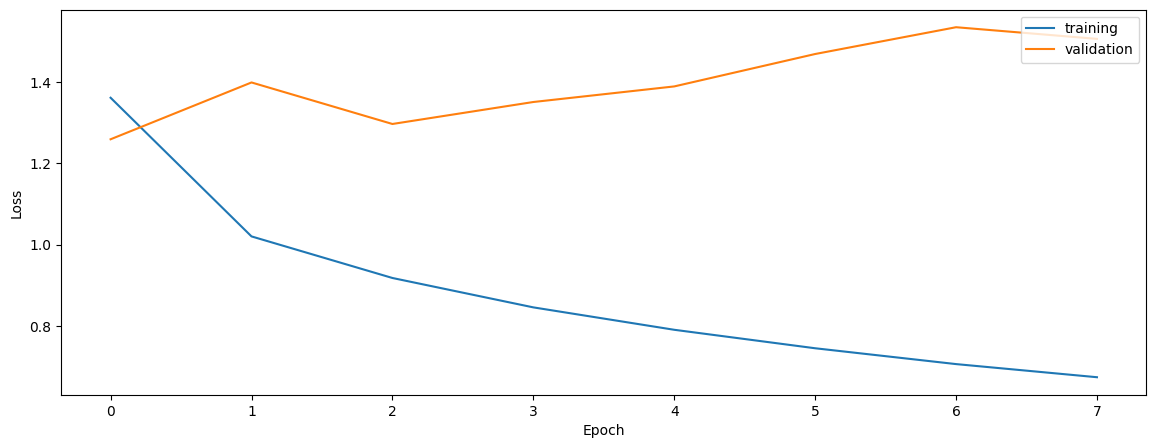

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.563741410025798
0.5197083676834295
0.5003536543213037


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5479862973972305
0.5328599083438685
0.45090405307014


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5403605944636188
0.5385917400135409
0.4536939649923054


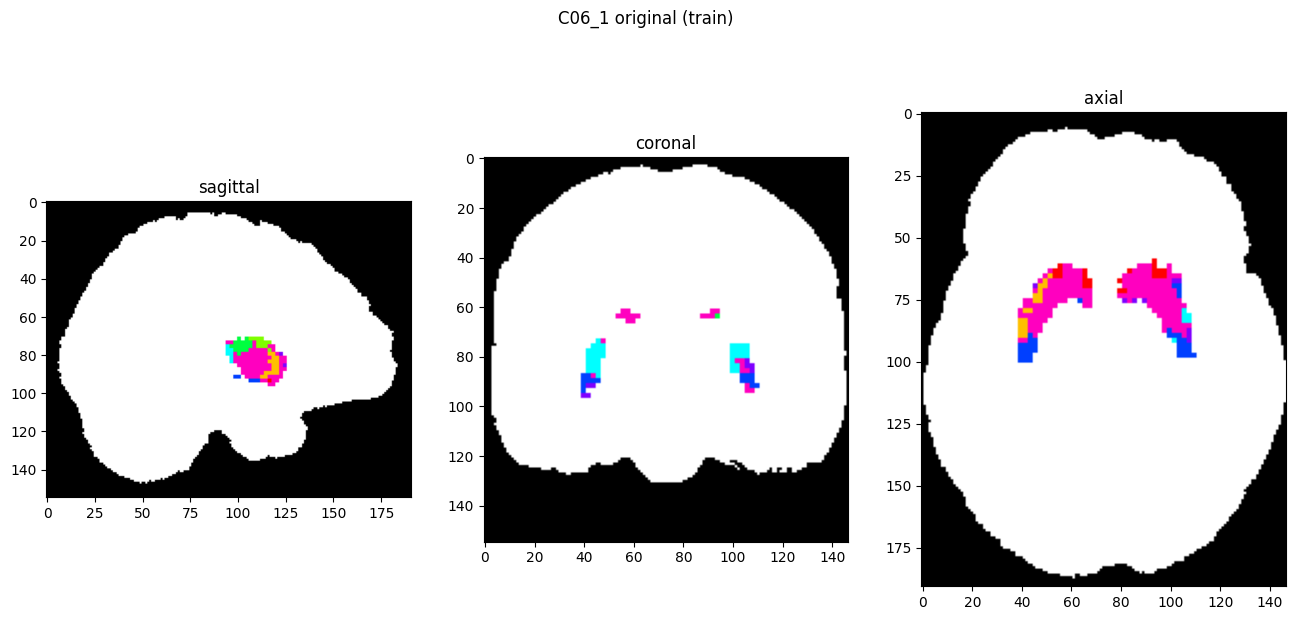

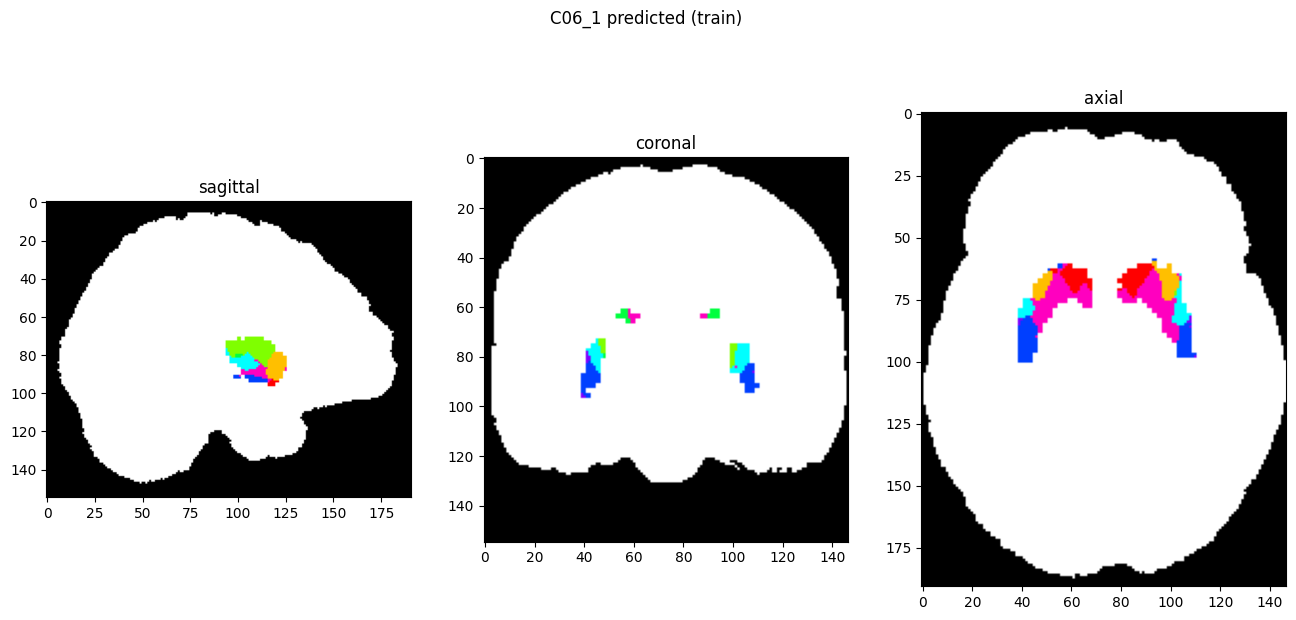

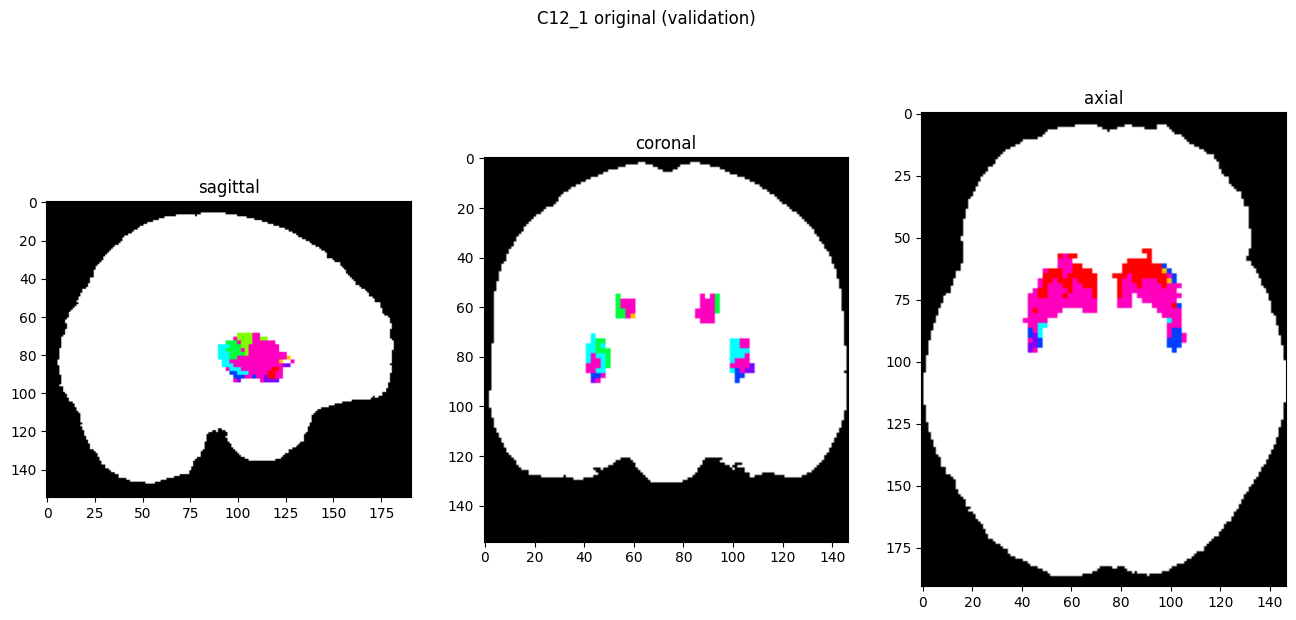

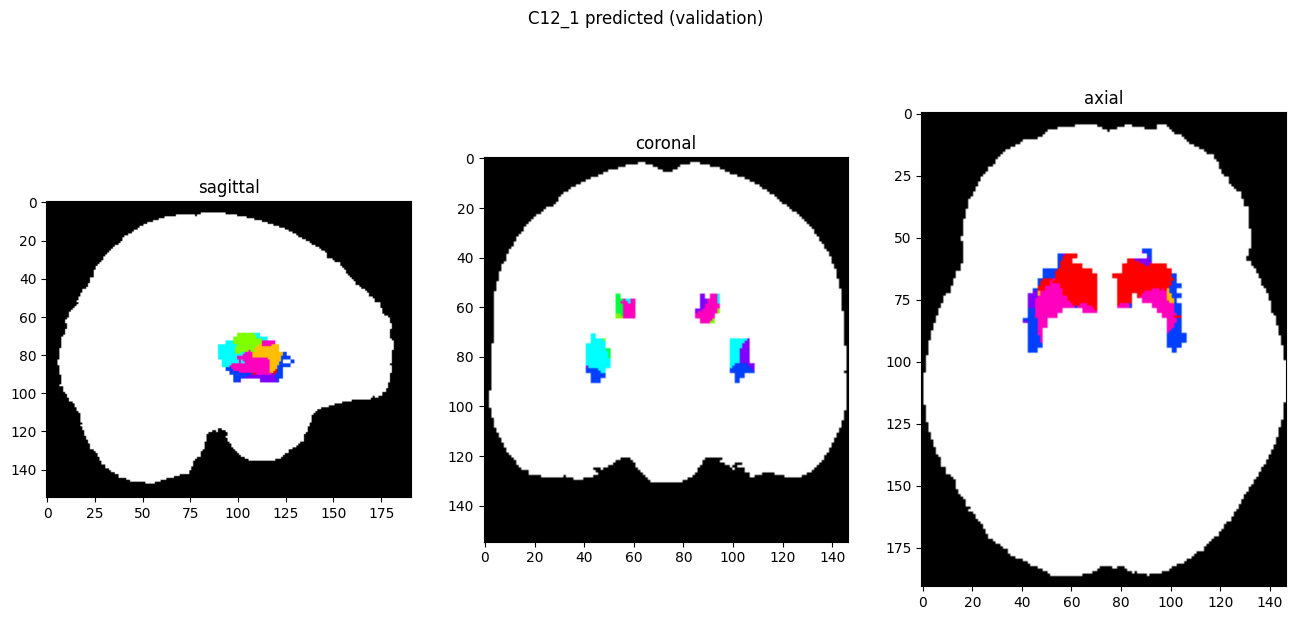

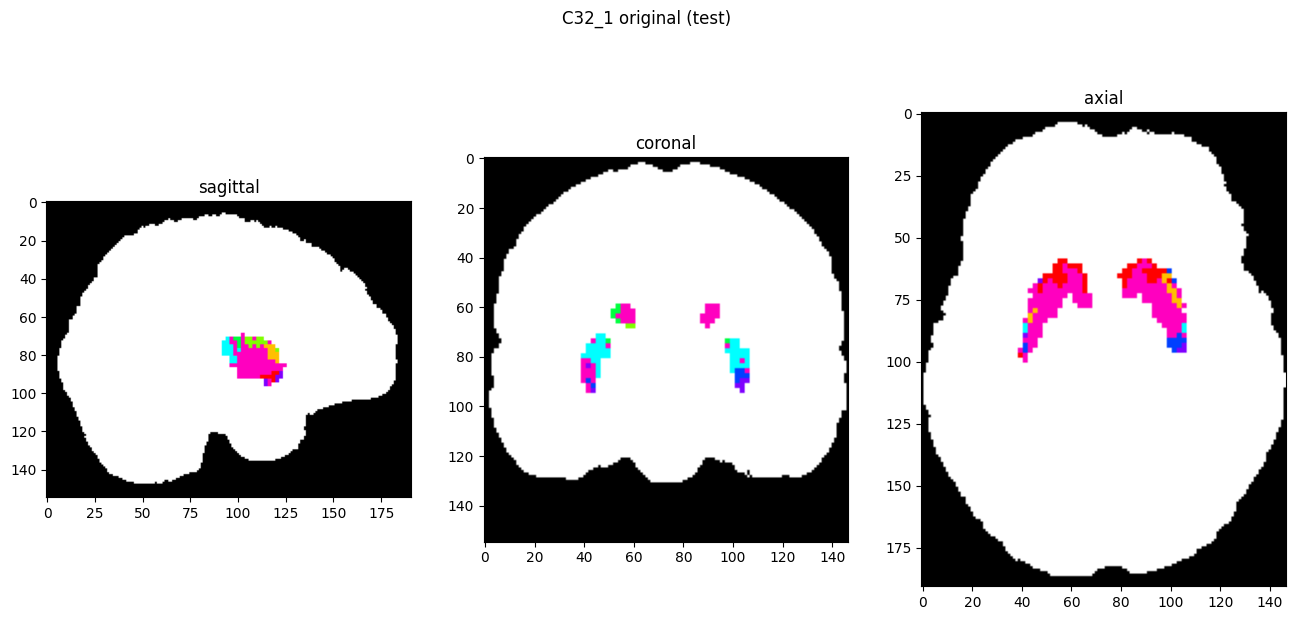

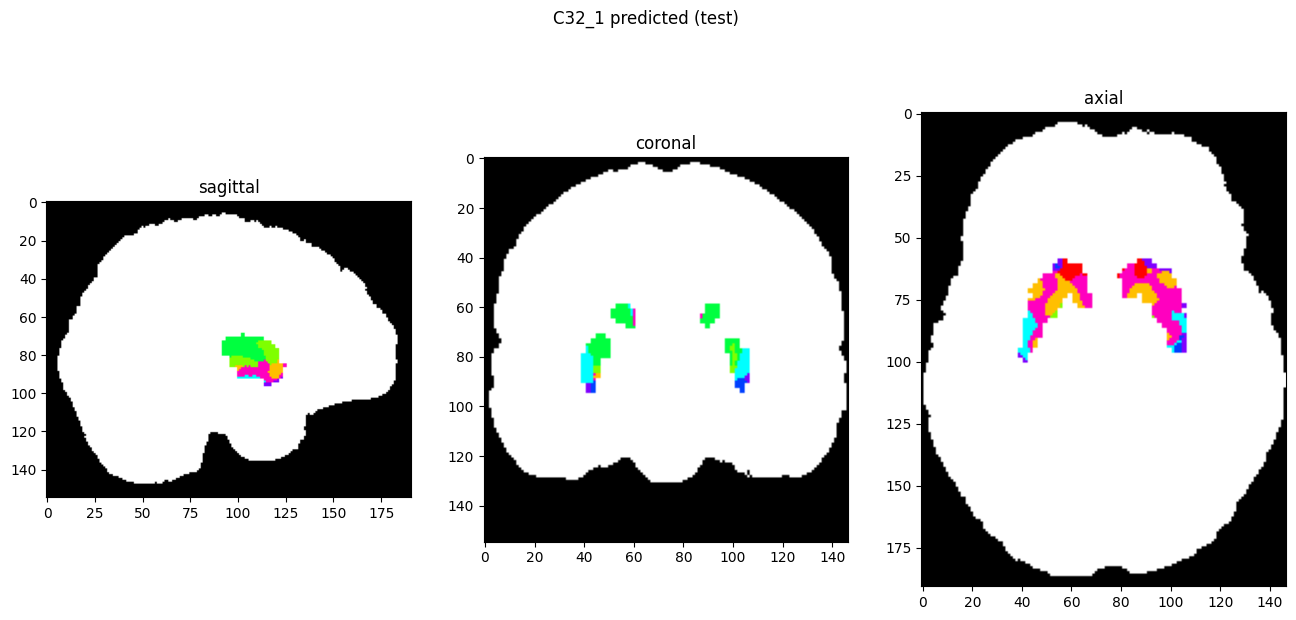

In [10]:
showResults(model, gen, threshold=0)